# first test of all code in `stancode_gallery2`
 * using all of the data for training (`i_test[:] = 0`)
 * **Note:** I accidentally used an outdated template for this notebook: Zinser reference `divrate` value is still 0.63 and not 0.69, error bar plot is not set up to handle `i_test[:] = 0` well, etc.
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import dateutil.parser

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

# Now we load in count data
seaflow = pd.read_csv('data/SeaFlow_PSD_hourlyCOUNT_m32.csv')
zinser = pd.read_csv('data/Zinser_Figure2A.csv')

# Extract cell counts from files
seaflow_counts = seaflow.values[:, 2:].T.astype(int)
zinser_counts = zinser.values[:, 1].astype(int) # cells A column
# zinser_counts = zinser.values[:, 2].astype(int) # cells B column
# zinser_counts = zinser.values[:, 1].astype(int) + zinser.values[:, 2].astype(int) # sum of both columns

# Replace SeaFlow values based on the 25-size class data with 32-size class data
data_gridded['seaflow']['m'] = seaflow_counts.shape[0]
data_gridded['seaflow']['size_bounds'] = seaflow.columns[2:].values.astype(float)/1000 # extract size classes from dataframe
data_gridded['seaflow']['v_min'] = data_gridded['seaflow']['size_bounds'][0] # note these seem to be on a different scale
data_gridded['seaflow']['delta_v_inv'] = int(np.round(1.0/np.log2(data_gridded['seaflow']['size_bounds'][1]/data_gridded['seaflow']['size_bounds'][0])))
data_gridded['seaflow']['w_obs'] = (seaflow_counts/np.sum(seaflow_counts, axis=0)[None, :]).astype(float)
data_gridded['seaflow']['counts'] = seaflow_counts
data_gridded['seaflow']['obs_time'] = np.empty(shape=seaflow_counts.shape[1])
ii = 0
for timestamp in np.asarray(seaflow['time'], dtype=str):
    datetime = dateutil.parser.isoparse(timestamp)
    if ii == 0:
        initial = datetime
    data_gridded['seaflow']['obs_time'][ii] = (datetime - initial).total_seconds()/60
    ii += 1

# Add counts to Zinser data
data_gridded['zinser']['counts'] = (data_gridded['zinser']['w_obs'] * zinser_counts[None, :]).astype(int)
data_gridded['zinser']['obs_time'] = data_gridded['zinser']['time']

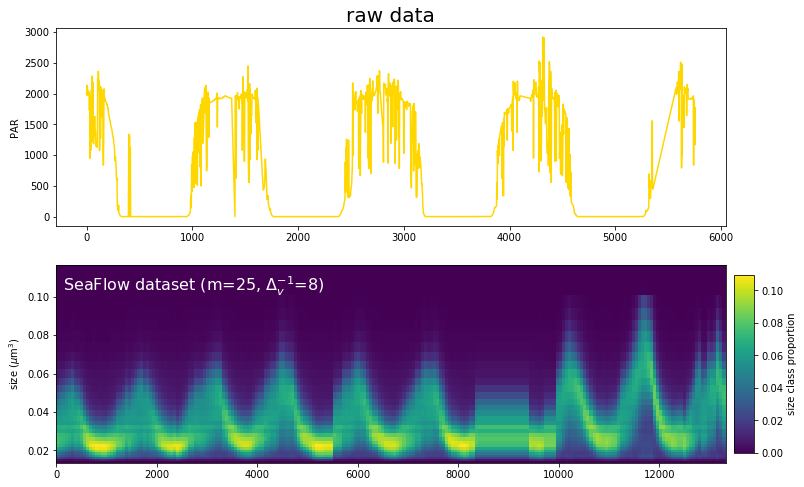

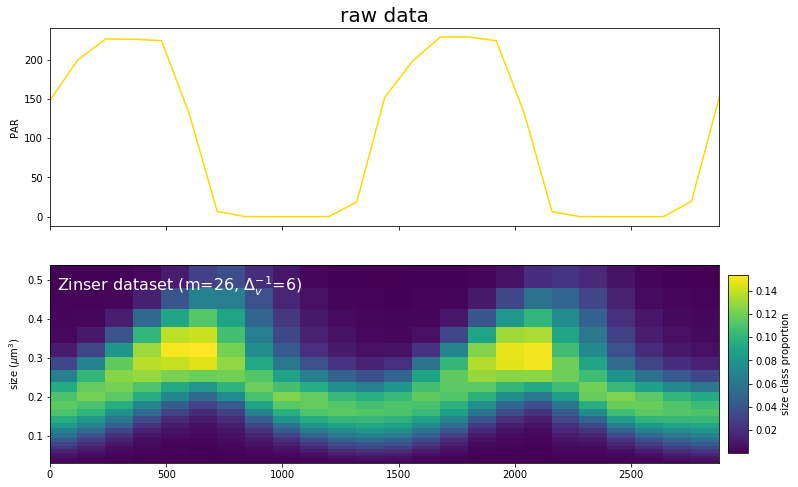

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,dataname in enumerate(data_gridded):
    nrows = 2
    sharex_flag = 'none'
    if np.all(data_gridded[dataname]['time'] == data_gridded[dataname]['obs_time']):
        sharex_flag = True
    fig,axs = plt.subplots(nrows=nrows, sharex=sharex_flag, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    data[dataname]['prior_only'] = 0
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        
        # new: average SeaFlow data in hourly bins
#         binsize = 60 # in minutes
#         numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
#         data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
#         data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
#         i = 0
#         for ibin in range(numbins):
#             binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
#                                     data_gridded[dataname]['time'] < (ibin+1)*binsize)
#             if np.any(binind):
#                 # TODO we may want to make this a sum when dealing with counts
#                 data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
#                 data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
#                 i += 1
        
#         data[dataname]['obs'] = data[dataname]['obs'][:,:i]
#         data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # set all indices to zero
#     data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    data[dataname]['i_test'] = np.tile(np.array([0, 0, 1]), 8).astype(int)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
#     data[dataname]['obs_count'] = (1000*data[dataname]['obs']).astype(int)
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))


/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


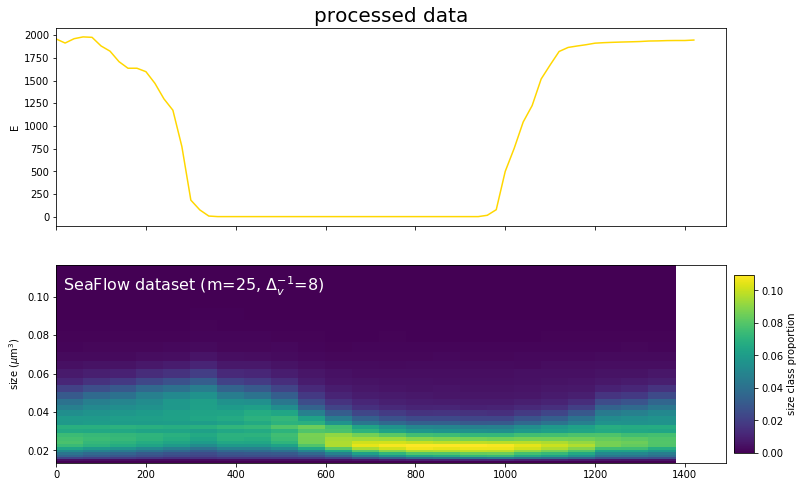

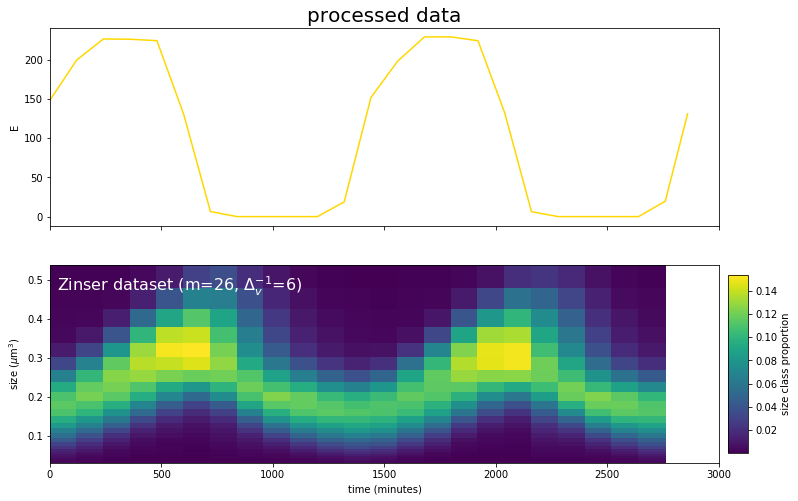

In [4]:
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

## run model

In [5]:
import pystan
import re

desc_model = {
    's1':'basic model, free deltas',
    's2':'basic model, monotonic deltas',
    's3':'size-dep growth (gammaiv6)',
    's4':'simple growth, simple respiration (respv1)',
    's5':'simple net growth-respiration (respv2)',
    's6':'size-dep net growth-respiration (respiv6)',
    's7':'size-dep growth, size-dep respiration (respiv7)',
    's8':'size-dep growth, size-dep respiration (respiv6), light-dep div',
    's9':'size-dep growth, size-dep respiration (respiv7), light-dep div',
}
# preparing for some regular expression magic
model_code_replacements = {
    's1':(),
    's2':(),
    's3':(),
    's4':(),
    's5':(),
    's6':(),
    's7':(),
    's8':(),
    's9':(),
    's10':(),
}
model_stan_key = {
    's1':'c1',
    's2':'c2',
    's3':'c3',
    's4':'c4',
    's5':'c5',
    's6':'c6',
    's7':'c7',
    's8':'c8',
    's9':'c9',
    's10':'c10',
}
stan_files = {
    'c1':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowth_xval2.stan',
    'c2':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowth_xval2.stan',
    'c3':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c4':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowth_xval2.stan',
    'c5':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowth_xval2.stan',
    'c6':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowth_xval2.stan',
    'c7':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowth_xval2.stan',
    'c8':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowth_xval2.stan',
    'c9':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowth_xval2.stan',
    'c10':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowth_xval2.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL s1 NOW.


s1: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s2 NOW.


s2: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s3 NOW.


s3: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s4 NOW.


s4: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s5 NOW.


s5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s6 NOW.


s6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s7 NOW.


s7: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s8 NOW.


s8: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s9 NOW.


s9: compiling


In [6]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}

try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1 (basic model, free deltas)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu             4.2    0.01   0.77   2.67   3.71    4.2   4.71    5.7   4441    1.0
delta_sigma         4.88    0.03   1.29   2.83   3.96   4.74   5.64   7.88   1956    1.0
delta[1]          4.5e-4  6.2e-6 4.6e-4 1.1e-5 1.3e-4 3.0e-4 6.3e-4 1.7e-3   5500    1.0
delta[2]            0.25  4.7e-4   0.03    0.2   0.23   0.25   0.27   0.32   4110    1.0
delta[3]            0.93  1.3e-3   0.07    0.8   0.88   0.93   0.98   1.09   3080    1.0
delta[4]             1.4  1.9e-3   0.11    1.2   1.33   1.39   1.47   1.63   3180    1.0
delta[5]             1.5  2.0e-3   0.12   1.26   1.41   1.49   1.58   1.75   3704    1.0
delta[6]            1.96  2.5e-3   0.15   1.67   1.85   1.95   2.06   2.26   3697    1.0
delta[7]            2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1 (basic model, free deltas)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            3.41    0.01   0.88   1.67   2.83    3.4    4.0   5.15   3654    1.0
delta_sigma         7.75    0.02   1.31   5.56   6.78   7.66   8.52  10.65   4393    1.0
delta[1]            0.21  2.7e-3    0.2 6.1e-3   0.06   0.15   0.29   0.72   5548    1.0
delta[2]            0.17  2.1e-3   0.15 5.6e-3   0.06   0.13   0.24   0.57   5593    1.0
delta[3]            0.17  1.9e-3   0.14 4.3e-3   0.06   0.13   0.24   0.51   5295    1.0
delta[4]            0.19  2.0e-3   0.14 8.2e-3   0.08   0.16   0.27   0.52   4866    1.0
delta[5]            0.23  2.0e-3   0.13   0.02   0.13   0.22   0.32   0.52   4340    1.0
delta[6]             0.3  2.3e-3   0.13   0.06    0.2   0.29   0.38   0.56   3044    1.0
delta[7]            0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (basic model, monotonic deltas)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          26.92    0.16   7.22  16.19  21.79   25.7  30.77  44.64   1983    1.0
gamma_max           1.58  6.9e-3   0.33   1.25   1.37   1.48   1.67   2.48   2298    1.0
rho_max              2.6    0.01   1.47   0.15   1.34   2.59   3.86   5.04  10570    1.0
E_star            706.66   10.64 540.24  53.04 335.49 606.96 942.76 2052.7   2580    1.0
sigma             928.64    0.67  58.85 817.18 887.05 926.63 968.11 1050.1   7630    1.0
divrate             0.66  4.3e-4   0.03   0.61   0.64   0.66   0.67   0.71   3760    1.0
delta[1]          4.5e-4  5.9e-6 4.8e-4 9.0e-6 1.2e-4 3.0e-4 6.2e-4 1.8e-3   6660    1.0
delta[2]            0.26  4.7e-4   0.03    0.2   0.24   0.26   0.28   0.32   4030    1.0
delta[3]        

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (basic model, monotonic deltas)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          32.46    0.14    5.7  23.54  28.41  31.67  35.81  45.98   1588    1.0
gamma_max           7.98    0.02   0.69   6.29   7.59   8.15   8.54    8.8   1800    1.0
rho_max             4.42    0.04   2.52    0.2   2.22   4.49   6.61   8.53   4275    1.0
E_star            298.17    0.98  41.42 204.34 272.32  303.1 327.89 367.65   1803    1.0
sigma             198.51    0.26  14.16 171.49 189.03 198.37 207.91  227.4   2995    1.0
divrate             1.74  1.3e-3   0.08   1.58   1.69   1.74    1.8    1.9   4220    1.0
delta[1]            0.04  4.6e-4   0.03 9.0e-4   0.01   0.03   0.05   0.12   4689    1.0
delta[2]            0.08  6.1e-4   0.04   0.01   0.04   0.07    0.1   0.18   5326    1.0
delta[3]        

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (size-dep growth (gammaiv6))
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          26.84    0.17   6.89  16.02  21.81  25.97  30.91  43.59   1688    1.0
gamma_max           1.59  7.6e-3   0.32   1.25   1.38    1.5   1.68    2.5   1774    1.0
rho_max             2.59    0.02   1.48   0.13   1.31    2.6   3.91   5.04   9226    1.0
E_star            704.64   11.85 527.22  48.25  332.9 603.89  949.4 2060.3   1979    1.0
sigma             928.77    0.64  55.59 823.42 892.27 927.05 964.71 1044.8   7450    1.0
xi                  0.02  1.0e-3    0.1  -0.17  -0.05   0.02   0.09   0.21   9343    1.0
divrate             0.66  4.4e-4   0.03   0.61   0.64   0.66   0.67   0.71   3769    1.0
delta[1]          4.4e-4  5.6e-6 4.4e-4 1.2e-5 1.3e-4 3.0e-4 6.2e-4 1.6e-3   6032    1.0
delta[2]           

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (size-dep growth (gammaiv6))
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          31.87    0.16   5.84  22.65  27.64  31.06  35.27  45.44   1320    1.0
gamma_max           8.05    0.01   0.64   6.47   7.69   8.21   8.56   8.79   1957    1.0
rho_max             4.33    0.04   2.48   0.21   2.22   4.33   6.42   8.54   4055    1.0
E_star            292.23    0.85  38.64 205.61 269.21 297.45 319.12 356.42   2049    1.0
sigma              201.5    0.24  14.78 174.02 191.22 201.13 211.29 230.45   3685    1.0
xi                 -0.16  1.6e-3    0.1  -0.35  -0.22  -0.16  -0.09   0.03   3685    1.0
divrate             1.72  1.2e-3   0.08   1.58   1.67   1.72   1.77   1.88   4455    1.0
delta[1]            0.04  4.9e-4   0.03 1.2e-3   0.01   0.03   0.05   0.12   4532    1.0
delta[2]           

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4 (simple growth, simple respiration (respv1))
Inference for Stan model: s4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          26.68    0.18   6.95  16.33  21.78  25.53   30.4  44.02   1534    1.0
gamma_max           1.55  6.7e-3   0.29   1.25   1.37   1.47   1.63   2.37   1865    1.0
rho_max           9.1e-4  1.1e-5 9.3e-4 2.2e-5 2.6e-4 6.4e-4 1.3e-3 3.3e-3   7073    1.0
E_star            660.23   10.91 487.84  53.66 315.03 581.28 885.71 1868.2   2000    1.0
sigma             926.05    0.72  57.69 816.06 887.08 925.59 964.42 1043.9   6413    1.0
divrate             0.66  4.8e-4   0.03   0.61   0.64   0.66   0.67   0.71   2855    1.0
delta[1]          4.4e-4  5.3e-6 4.3e-4 9.6e-6 1.3e-4 3.2e-4 6.3e-4 1.6e-3   6697    1.0
delta[2]            0.25  5.2e-4   0.03   0.19   0.23   0.25   0.27   0.32   3479    1.0
del

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4 (simple growth, simple respiration (respv1))
Inference for Stan model: s4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          39.31    0.15    7.0  26.19  34.65  38.93  43.54   54.6   2203    1.0
gamma_max           6.97    0.02   0.93   5.47   6.23   6.89   7.68   8.69   1632    1.0
rho_max             1.23  1.2e-3   0.08   1.07   1.18   1.23   1.28   1.39   4212    1.0
E_star            168.11    1.14  47.85  87.19 130.41 164.53 205.76 258.12   1772    1.0
sigma              306.7    0.35  23.28  261.6 291.39 305.42 322.16 353.79   4471    1.0
divrate             0.96  9.4e-4   0.06   0.84   0.92   0.96    1.0   1.09   4514    1.0
delta[1]          8.7e-3  1.1e-4 8.2e-3 2.8e-4 2.7e-3 6.3e-3   0.01   0.03   5531    1.0
delta[2]            0.02  1.5e-4   0.01 2.6e-3 9.4e-3   0.02   0.02   0.05   6291    1.0
del

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (simple net growth-respiration (respv2))
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          26.88    0.14   6.85  16.02  22.08  25.94  30.77  43.25   2255    1.0
gamma_max           1.57  7.8e-3   0.32   1.25   1.37   1.48   1.66    2.5   1689    1.0
rho_max           1.0e-3  1.2e-5 1.0e-3 2.0e-5 2.9e-4 7.1e-4 1.4e-3 3.9e-3   6941    1.0
E_star            700.13   12.28 529.49  54.27 336.66 598.74  921.6 2130.0   1860    1.0
sigma             925.94     0.6  56.54 819.59 886.69 925.32 963.36 1041.1   8909    1.0
divrate             0.66  4.4e-4   0.03   0.61   0.64   0.65   0.67   0.71   3335    1.0
delta[1]          4.4e-4  5.7e-6 4.5e-4 1.2e-5 1.2e-4 3.0e-4 6.0e-4 1.7e-3   6233    1.0
delta[2]            0.25  4.8e-4   0.03   0.19   0.23   0.25   0.27   0.31   4037    1.0
delta[3

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (simple net growth-respiration (respv2))
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          14.14    0.05    3.0   9.43  12.03  13.76  15.87  20.99   3095    1.0
gamma_max           4.06  2.1e-3   0.12   3.85   3.98   4.06   4.14   4.31   3068    1.0
rho_max             1.67  1.2e-3   0.07   1.53   1.62   1.67   1.72   1.82   3822    1.0
E_star             45.23    0.19   9.93  30.03  38.25  43.74  50.87  68.59   2626    1.0
sigma             391.38    0.42  27.58 339.21 373.07 390.66 409.43 445.64   4289    1.0
divrate             0.62  8.9e-4   0.06   0.51   0.58   0.62   0.66   0.75   4586    1.0
delta[1]          9.2e-3  1.1e-4 8.4e-3 2.2e-4 2.9e-3 6.9e-3   0.01   0.03   5385    1.0
delta[2]            0.02  1.6e-4   0.01 2.9e-3   0.01   0.02   0.03   0.04   4882    1.0
delta[3

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6 (size-dep net growth-respiration (respiv6))
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          26.83    0.16   7.14   16.3  21.67  25.72  30.77  43.57   1961    1.0
gamma_max           1.58  5.3e-3   0.31   1.26   1.38   1.49   1.69   2.43   3427    1.0
rho_max           1.0e-3  1.5e-5 1.1e-3 2.7e-5 2.9e-4 7.0e-4 1.4e-3 4.1e-3   5172    1.0
E_star            696.93    8.15 507.16  54.46 332.06 603.08  939.4 1979.9   3876    1.0
sigma             925.69     0.8  55.53 819.41 887.13  925.3 963.33 1034.7   4874    1.0
xi                  0.02  1.0e-3    0.1  -0.18  -0.05   0.02   0.09   0.22   9460    1.0
xir               2.1e-3  1.1e-3    0.1  -0.19  -0.06 1.7e-3   0.07    0.2   7886    1.0
divrate             0.66  4.3e-4   0.03   0.61   0.64   0.66   0.67   0.71   3660    1.0
delt

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6 (size-dep net growth-respiration (respiv6))
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.09  9.8e-3   0.55   2.13   2.71   3.05   3.42   4.35   3181    1.0
gamma_max           4.95  2.8e-3   0.16   4.65   4.84   4.94   5.05   5.29   3333    1.0
rho_max             2.15  1.6e-3    0.1   1.96   2.09   2.15   2.22   2.35   4225    1.0
E_star             64.56    0.15   10.6  45.71  57.16  63.99  71.37  86.46   5105    1.0
sigma             622.24    0.68   47.9  531.7 589.43 620.55 653.43 720.86   4993    1.0
xi                 -0.95  1.3e-3   0.08   -1.1   -1.0  -0.95  -0.89  -0.79   3980    1.0
xir                  0.5  1.4e-3   0.09   0.32   0.44    0.5   0.56   0.67   3944    1.0
divrate             0.35  5.5e-4   0.04   0.28   0.33   0.35   0.38   0.42   4292    1.0
delt

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7 (size-dep growth, size-dep respiration (respiv7))
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          26.75    0.19   6.89  16.27  21.88   25.7  30.48  43.86   1311    1.0
gamma_max           1.56  6.7e-3   0.28   1.25   1.38   1.48   1.66   2.37   1805    1.0
rho_max           9.2e-4  1.2e-5 9.5e-4 2.3e-5 2.6e-4 6.4e-4 1.3e-3 3.4e-3   6164    1.0
E_star             667.3    11.1 480.51  54.51 322.08 585.55  894.3 1876.1   1875    1.0
sigma             925.39     0.8  57.91  818.4 885.79 924.42 963.28 1043.9   5234    1.0
xi                  0.02  1.2e-3    0.1  -0.18  -0.05   0.02   0.09   0.22   6792    1.0
xir               1.8e-4  1.1e-3    0.1  -0.19  -0.07-2.2e-3   0.07   0.19   7697    1.0
divrate             0.66  4.7e-4   0.03   0.61   0.64   0.66   0.68   0.71   3142    1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7 (size-dep growth, size-dep respiration (respiv7))
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          34.37    0.13    7.2  21.33  29.45  33.95  38.57  50.29   3234    1.0
gamma_max           6.94    0.02   0.81   5.67   6.31   6.83   7.54   8.61   2444    1.0
rho_max             1.39  1.7e-3   0.11   1.19   1.32   1.38   1.46    1.6   3882    1.0
E_star            145.73    0.82  40.66  79.32 114.57 141.34 175.17 228.76   2464    1.0
sigma             325.91    0.35  23.87 279.66 309.69  325.3 341.55 374.82   4573    1.0
xi                 -0.35  1.3e-3    0.1  -0.55  -0.42  -0.35  -0.29  -0.15   6080    1.0
xir                 0.17  1.3e-3    0.1  -0.03    0.1   0.17   0.23   0.37   6185    1.0
divrate             0.87  1.0e-3   0.07   0.74   0.82   0.87   0.91    1.0   4388    1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8 (size-dep growth, size-dep respiration (respiv6), light-dep div)
Inference for Stan model: s8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           9.91    0.09   2.55   6.43   8.12   9.42  11.16  16.07    737    1.0
gamma_max           0.71  5.2e-3   0.19   0.53   0.59   0.64   0.77   1.26   1394    1.0
rho_max           8.2e-4  1.1e-5 8.3e-4 2.1e-5 2.3e-4 5.6e-4 1.1e-3 3.0e-3   5860    1.0
E_star            778.24   17.07 653.69  57.31 309.51 563.13 1063.5 2518.8   1467    1.0
sigma             1229.6    1.09  76.21 1082.9 1177.1 1227.8 1281.2 1378.6   4870    1.0
xi                7.8e-3  1.4e-3    0.1  -0.19  -0.06 7.3e-3   0.08    0.2   5258    1.0
xir               9.6e-6  1.3e-3    0.1  -0.19  -0.07 1.9e-4   0.07   0.18   5884    1.0
delta_lightthresh   6.41     0.1    6.9   0.13   1.48   3.81   8.77  25.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8 (size-dep growth, size-dep respiration (respiv6), light-dep div)
Inference for Stan model: s8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           5.95    0.01   0.79   4.54   5.41   5.88   6.43    7.7   5218    1.0
gamma_max           4.03  4.4e-3   0.24   3.67   3.88   4.01   4.16   4.56   2891    1.0
rho_max             1.56  1.9e-3   0.13   1.32   1.48   1.56   1.64   1.81   4310    1.0
E_star             75.61    0.37  20.88  42.46  61.43  73.95  87.45 119.98   3220    1.0
sigma              654.6    0.77  50.47 559.78 621.04 652.95  688.6 756.85   4258    1.0
xi                 -1.04  1.1e-3   0.08  -1.19   -1.1  -1.04  -0.99  -0.89   4914    1.0
xir                 0.53  1.2e-3   0.09   0.35   0.47   0.53   0.59   0.71   6228    1.0
delta_lightthresh  44.49     0.1   7.14  30.06  39.98  44.27  48.86  59.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9 (size-dep growth, size-dep respiration (respiv7), light-dep div)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           9.96    0.09   2.51   6.44   8.15   9.51  11.23   16.2    767   1.01
gamma_max           0.73  5.6e-3    0.2   0.52   0.59   0.65    0.8   1.28   1287    1.0
rho_max           6.1e-4  7.9e-6 6.3e-4 1.4e-5 1.7e-4 4.2e-4 8.5e-4 2.3e-3   6238    1.0
E_star            813.08   18.62 682.57  48.83 304.24 603.35 1134.9 2590.6   1343    1.0
sigma             1228.6    1.07  74.52 1085.9 1177.7 1228.7 1278.5 1379.9   4821    1.0
xi                8.8e-3  1.2e-3    0.1  -0.18  -0.06 7.0e-3   0.08    0.2   6814    1.0
xir              -2.3e-3  1.2e-3    0.1  -0.19  -0.07-2.5e-3   0.07   0.19   6348    1.0
delta_lightthresh   6.46    0.11   6.77   0.14   1.69   3.99   8.69  25.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9 (size-dep growth, size-dep respiration (respiv7), light-dep div)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          10.64    0.03   1.25   8.68   9.78  10.48  11.33  13.49   2349    1.0
gamma_max           7.36    0.02   1.12   4.76   6.62   7.62   8.28   8.77   2221    1.0
rho_max             0.02  2.5e-4   0.02 5.1e-4 5.3e-3   0.01   0.03   0.07   5375    1.0
E_star            827.66    3.14 147.66  497.7 732.82 853.03  941.0 1046.4   2218    1.0
sigma              322.9    0.41   25.9 274.81 304.22 322.29 339.93 376.87   4062    1.0
xi                 -0.77  1.7e-3   0.11  -0.99  -0.85  -0.77   -0.7  -0.56   4030    1.0
xir                 0.02  1.3e-3    0.1  -0.18  -0.06   0.02   0.08   0.22   6059    1.0
delta_lightthresh   5.66    0.09   5.03   0.09   1.31   4.28    9.0  17.

## plot the results

In [19]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# set the color for each model
num_model = len(mcmcs)
if num_model <= 10:
    colors_model = {name:'C{}'.format(imodel) for imodel,name in enumerate(mcmcs)}
else:
    colors_model = {name:mpl.cm.viridis(imodel/(num_model-1)) for imodel,name in enumerate(mcmcs)}
    
maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}

In [20]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

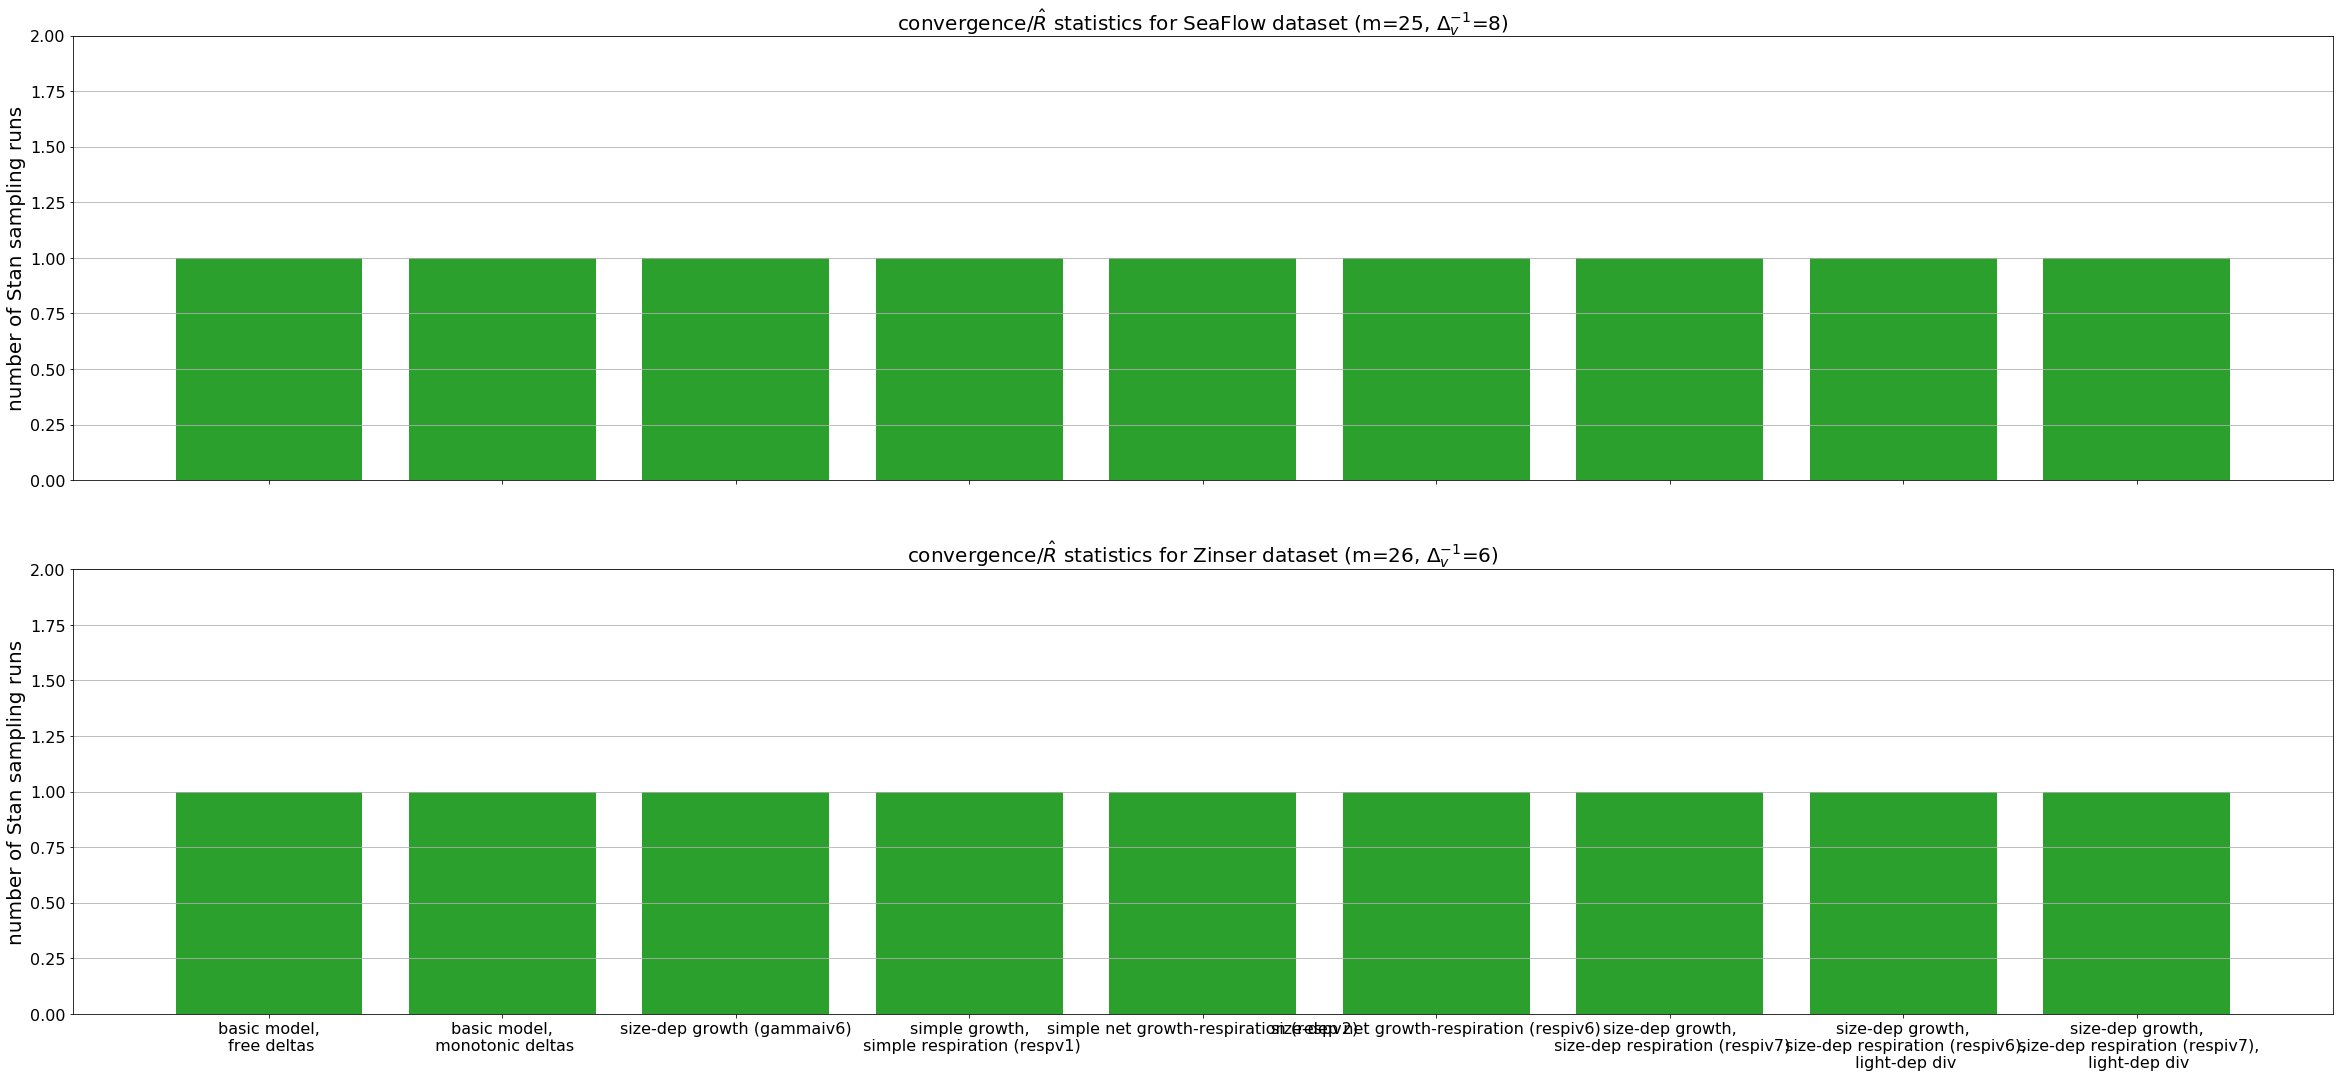

In [21]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

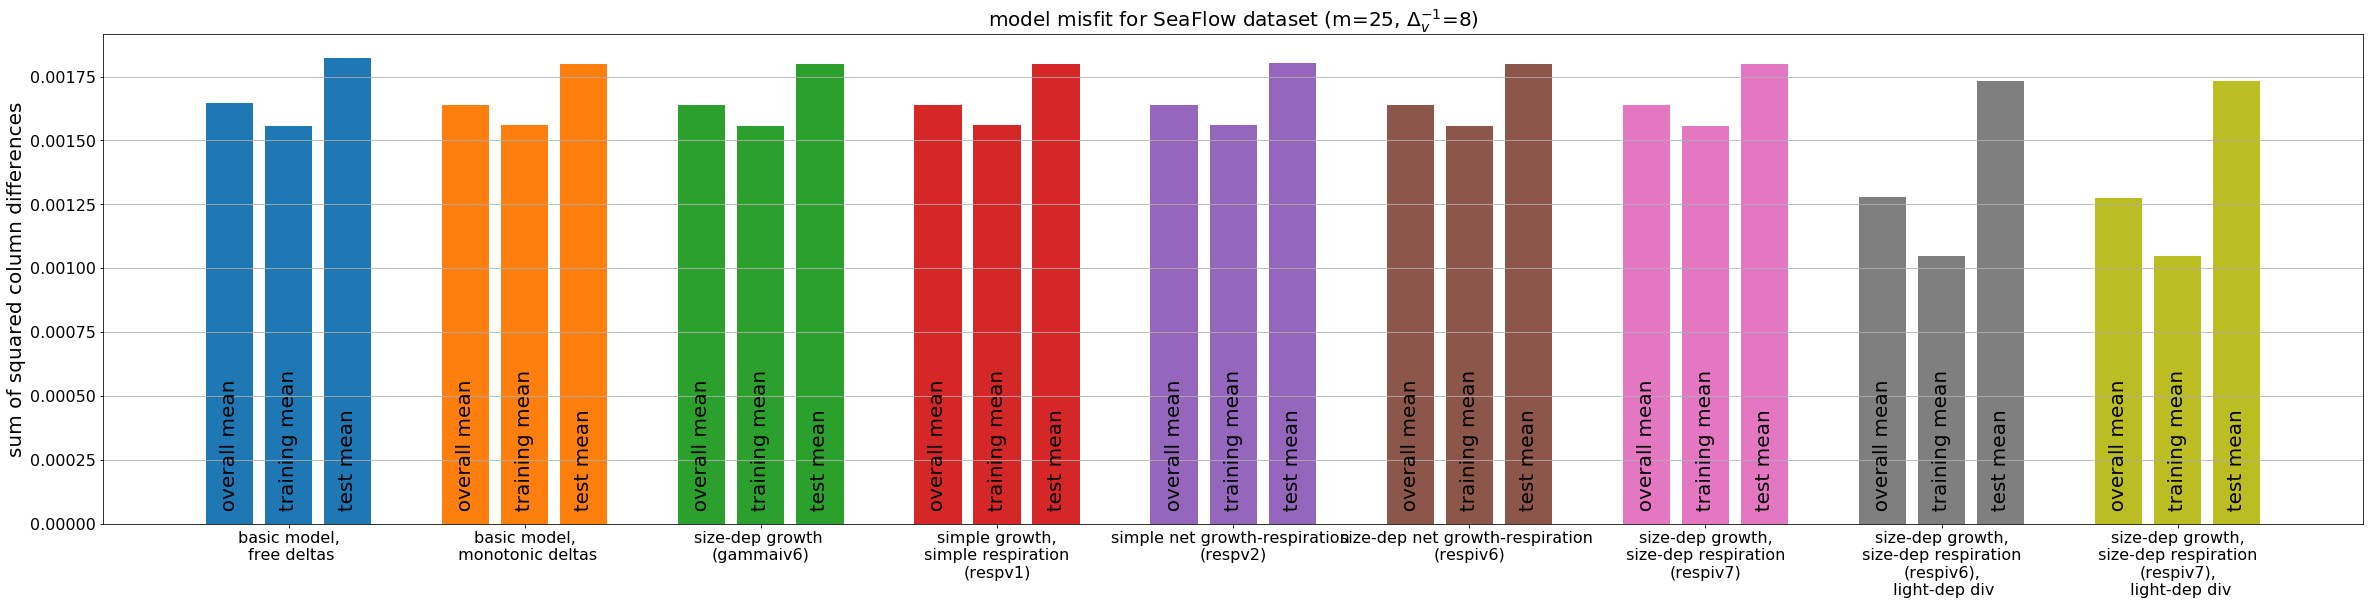

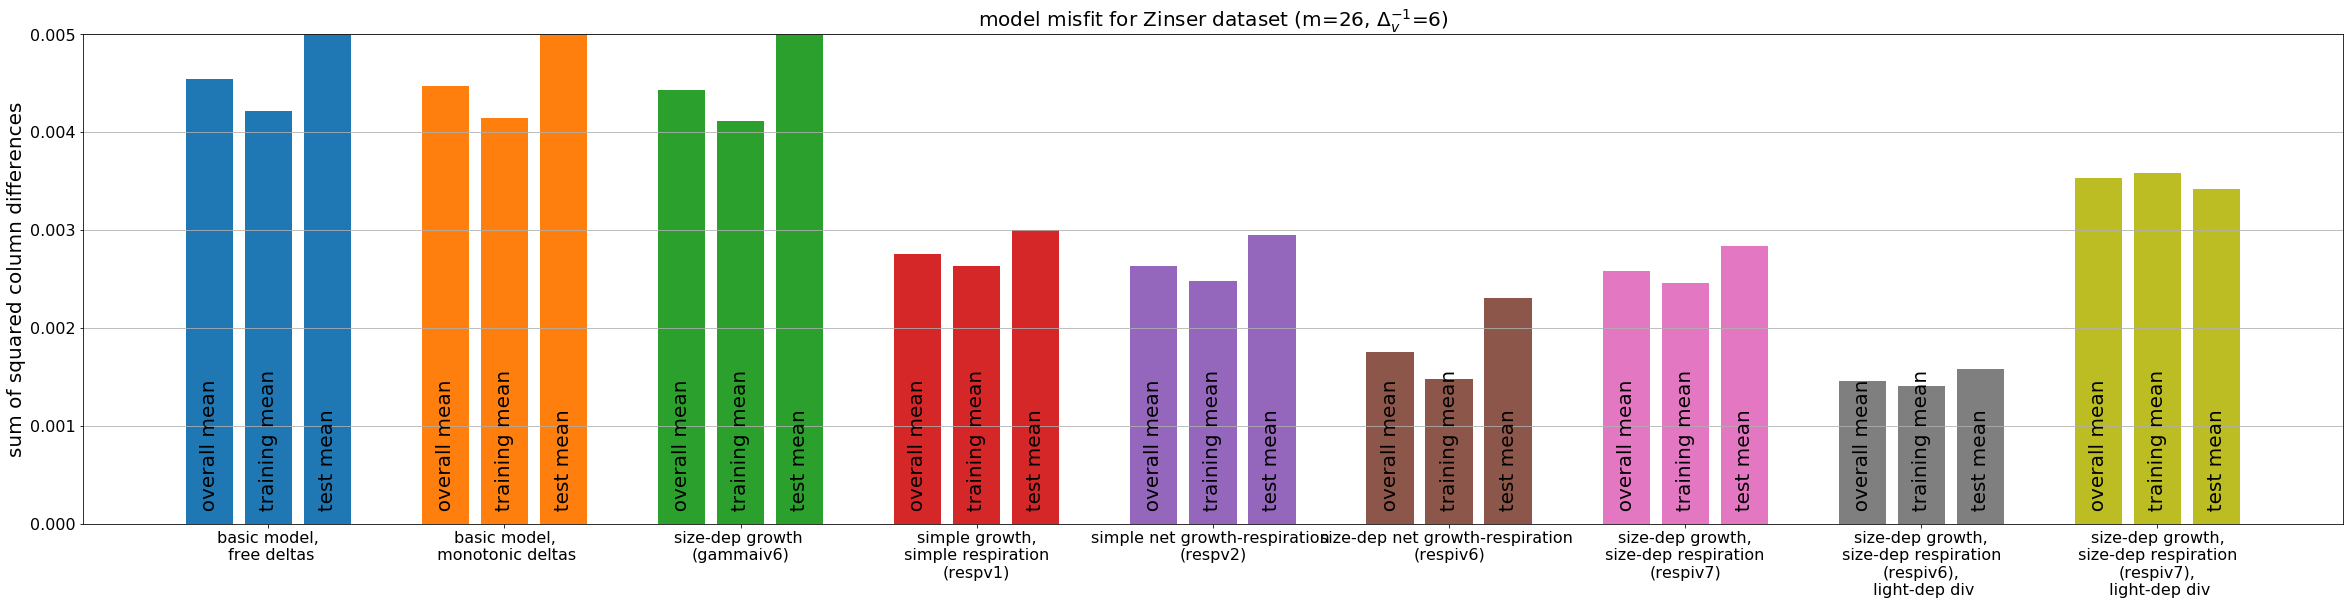

In [25]:
# updated code can handle all data[dataname]['i_test'] == 0 and draw only a single bar
if np.all(data[dataname]['i_test'] == 0):
    num_bars = 1
else:
    num_bars = 3

height = np.zeros(num_bars)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        if num_bars > 1:
            height[1] = np.mean(e[data[dataname]['i_test'] == 0])
            height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = (num_bars+1)*i+np.arange(num_bars)
        ax.bar(x=x, height=height, color=colors_model[name])
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[num_bars//3], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[num_bars//3])
        xticklabels.append(desc_model[name].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

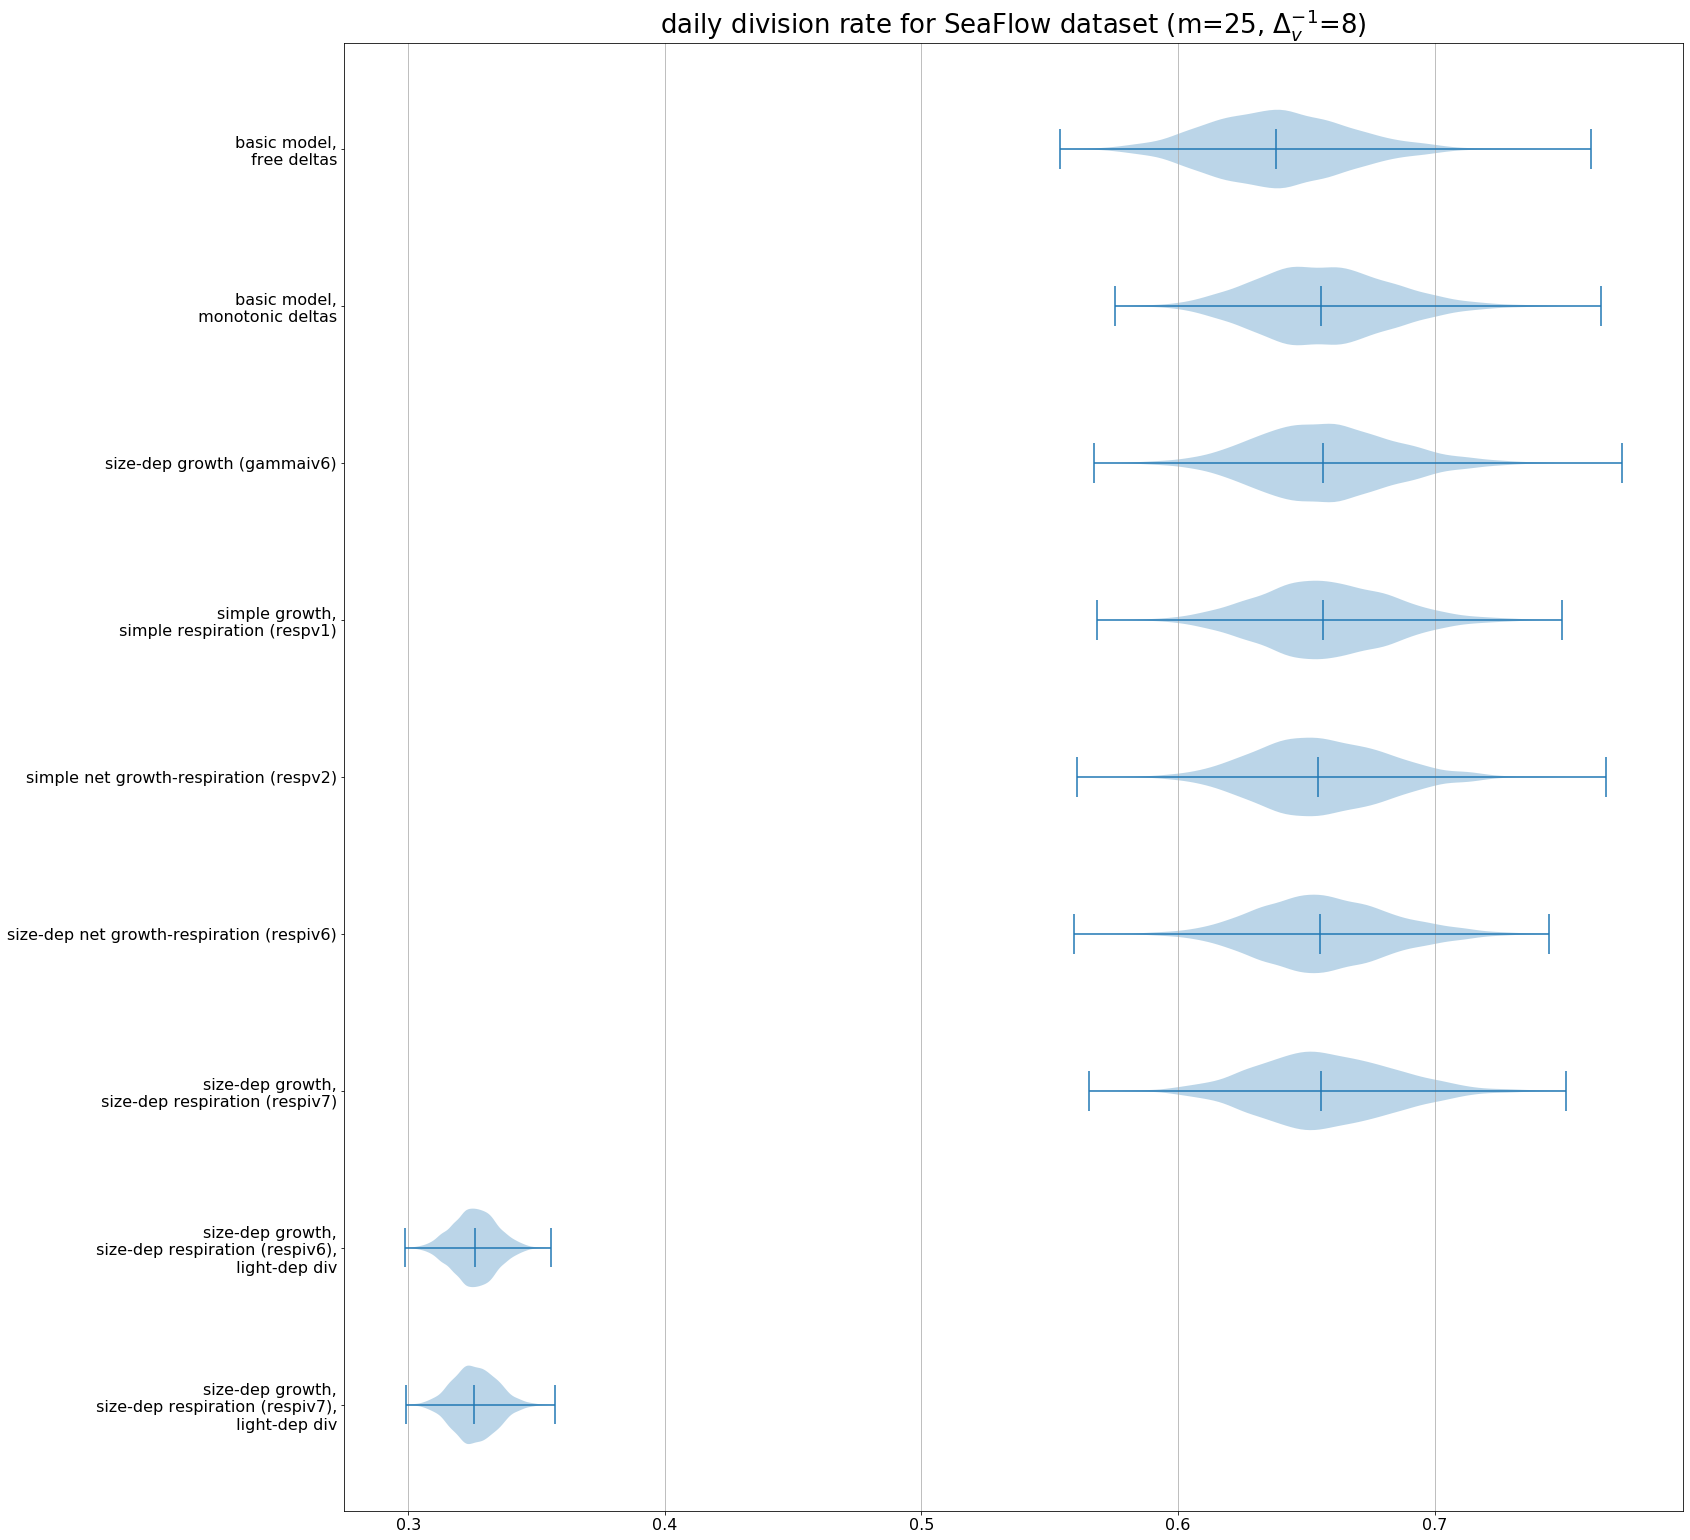

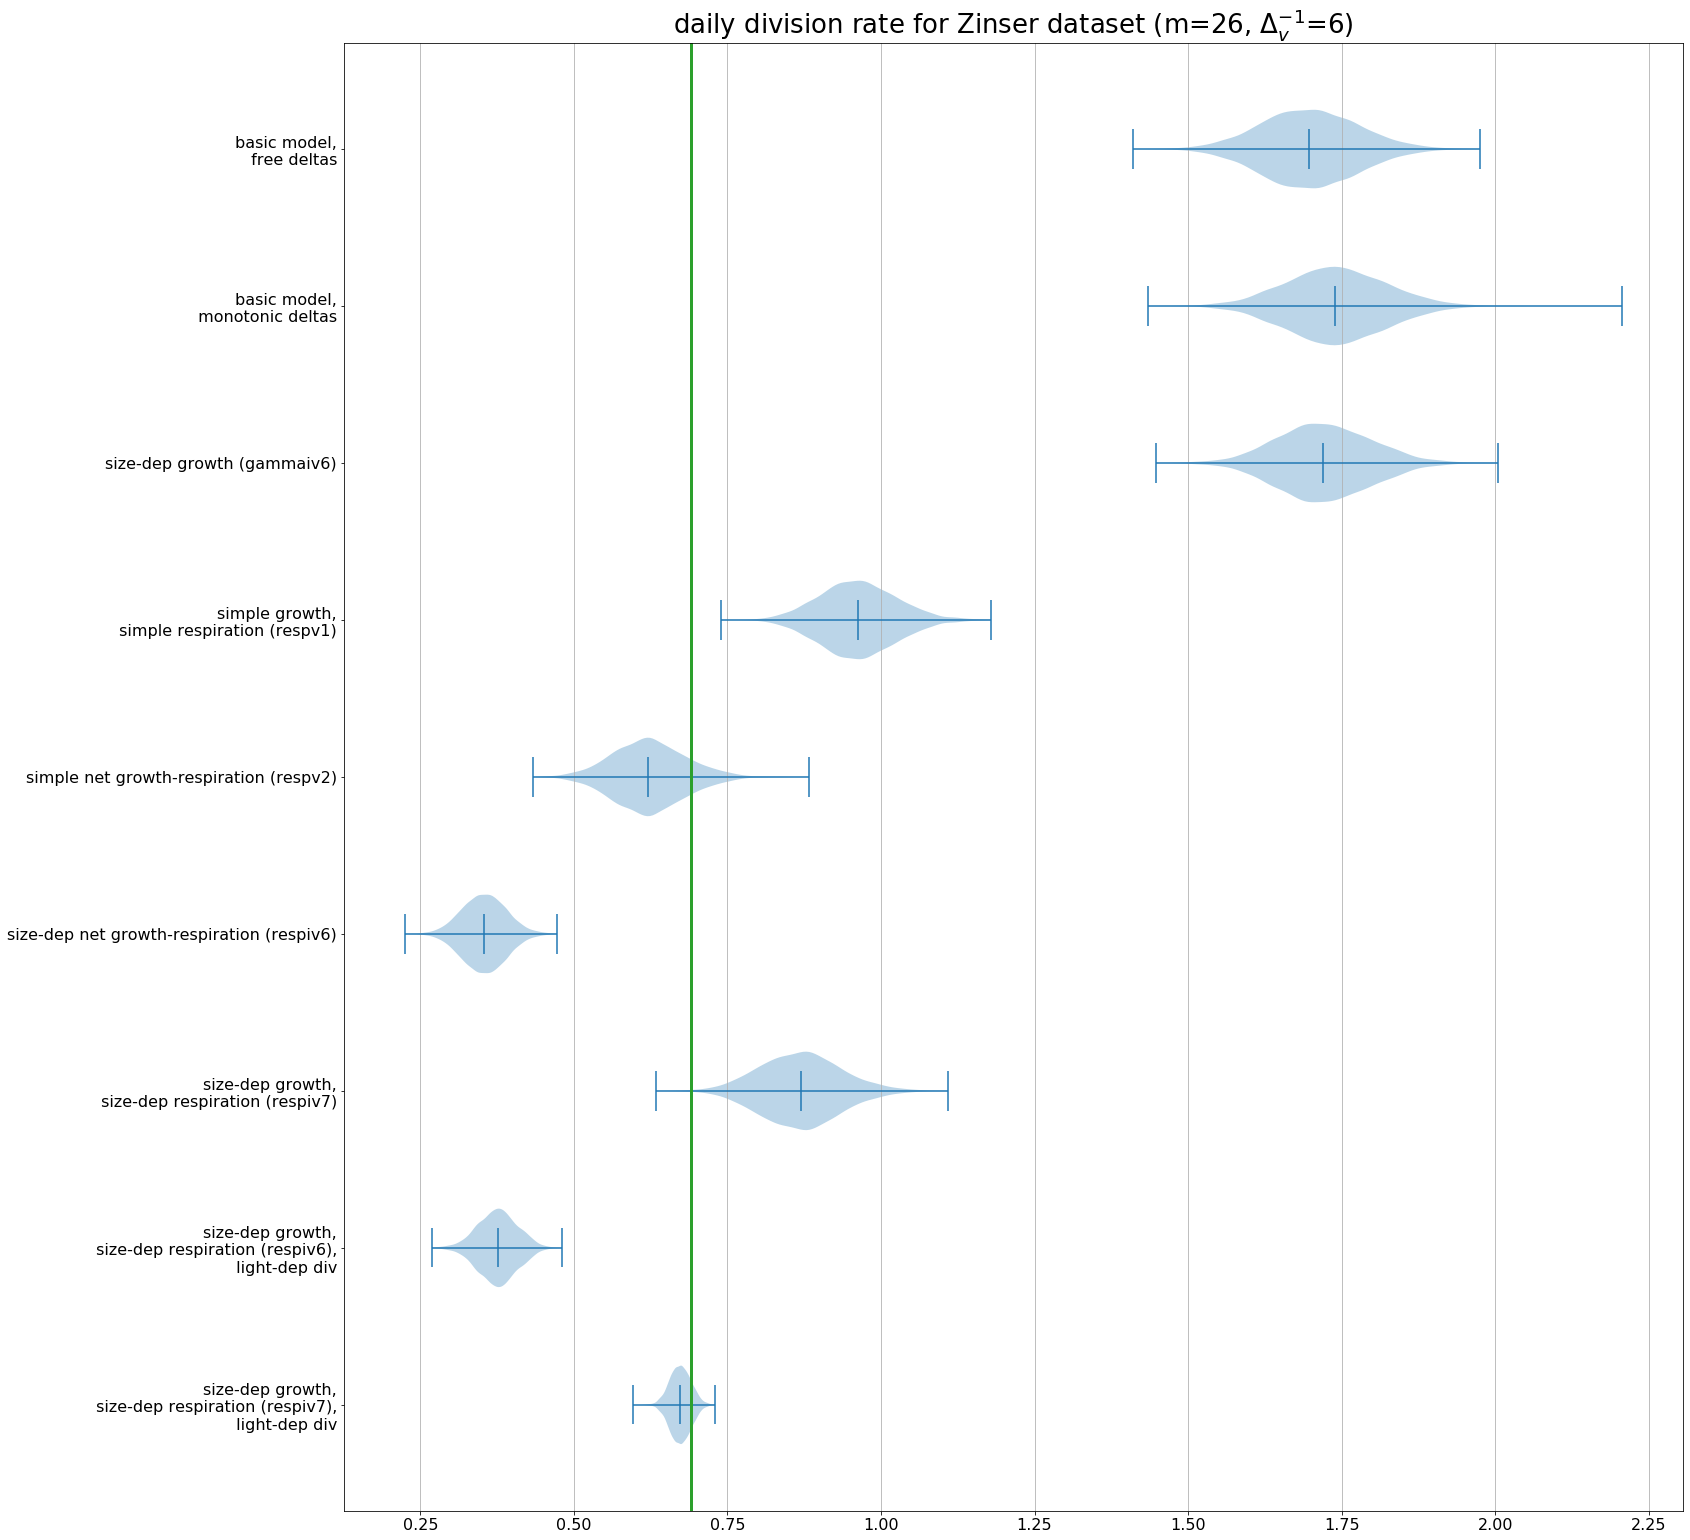

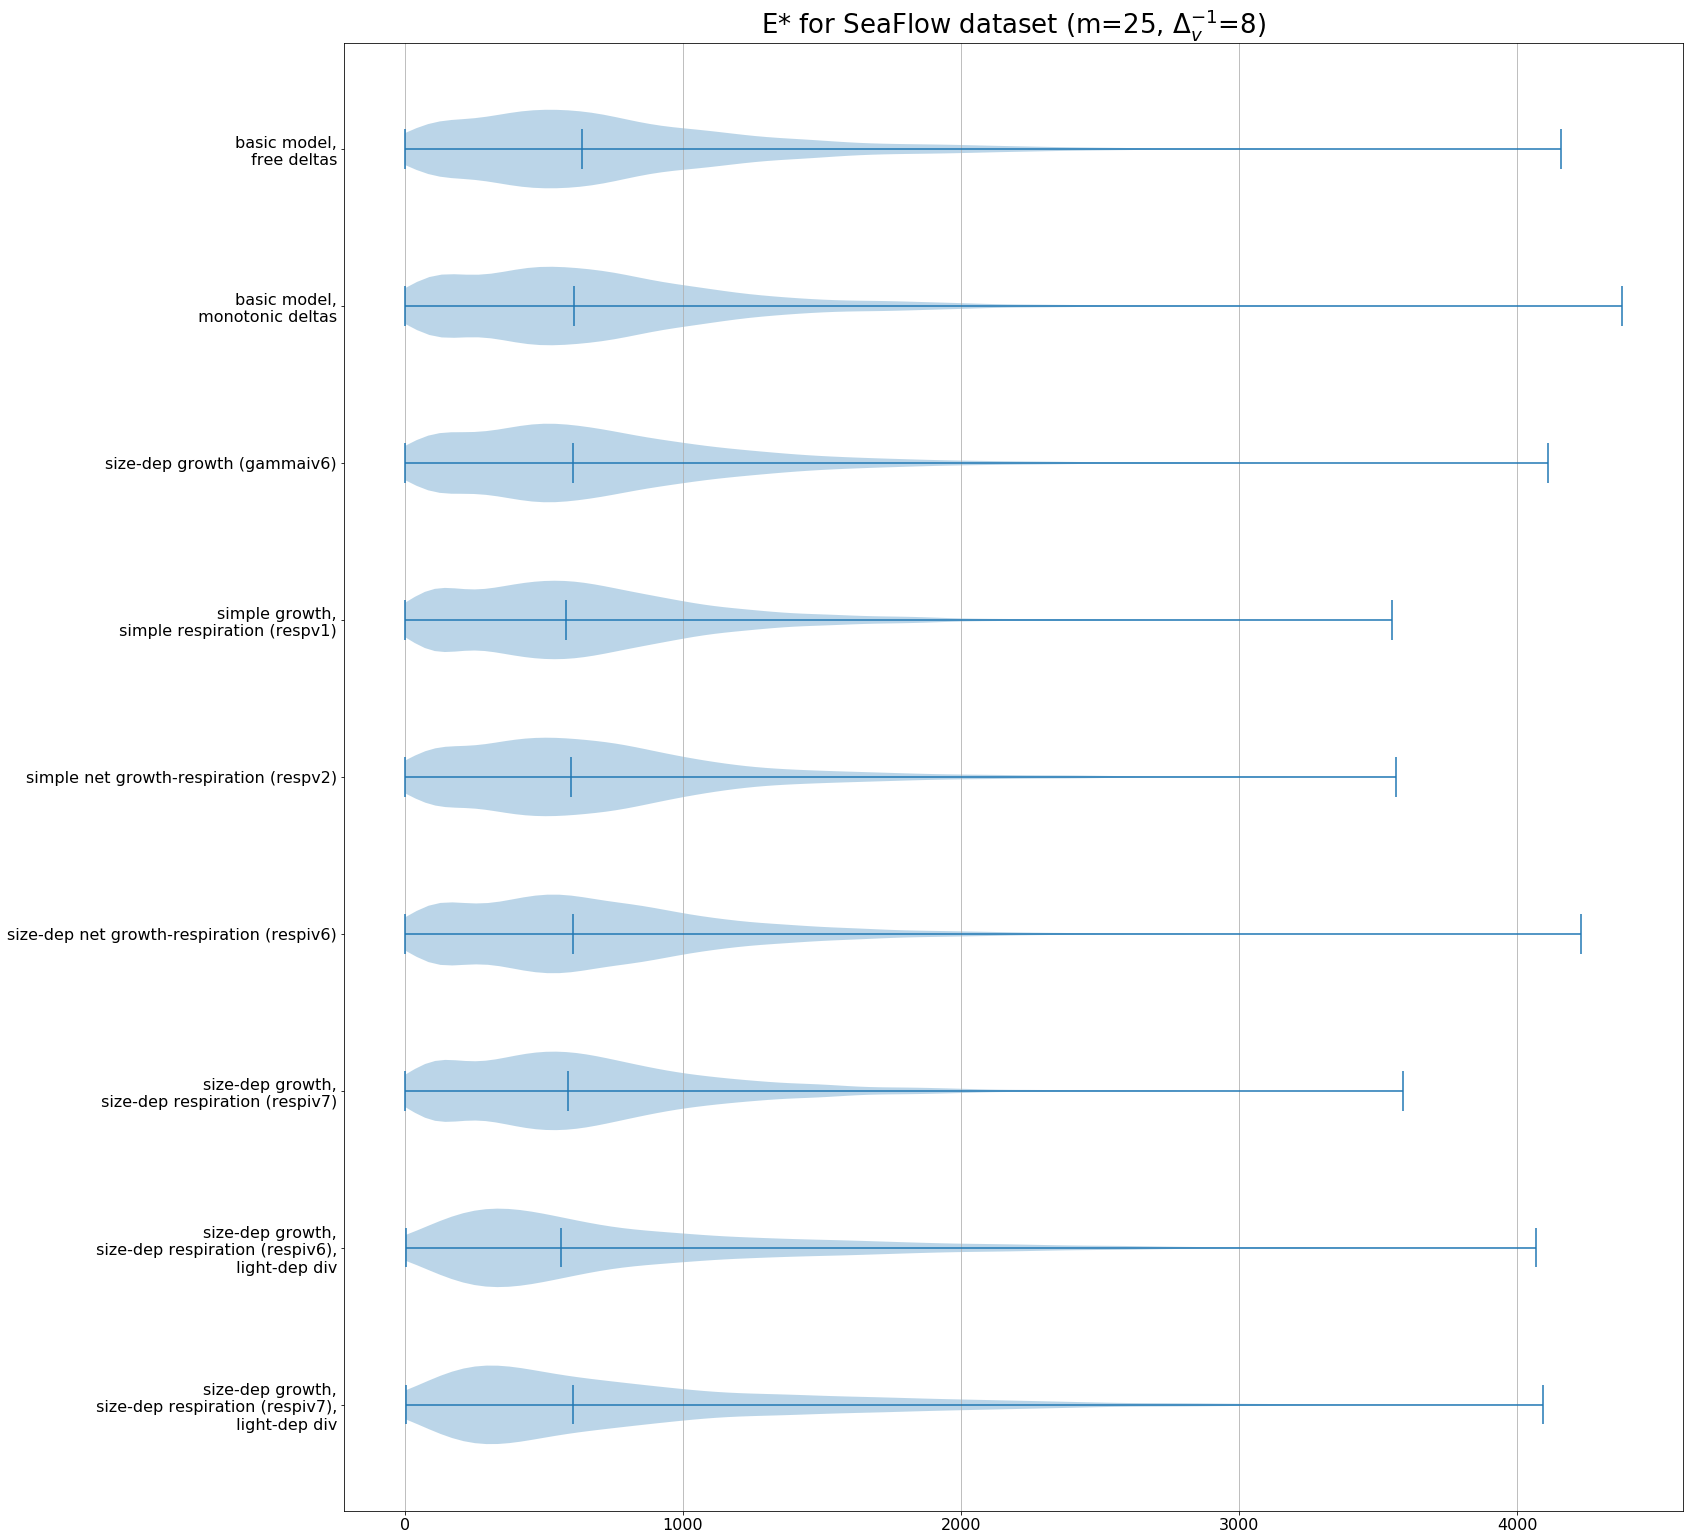

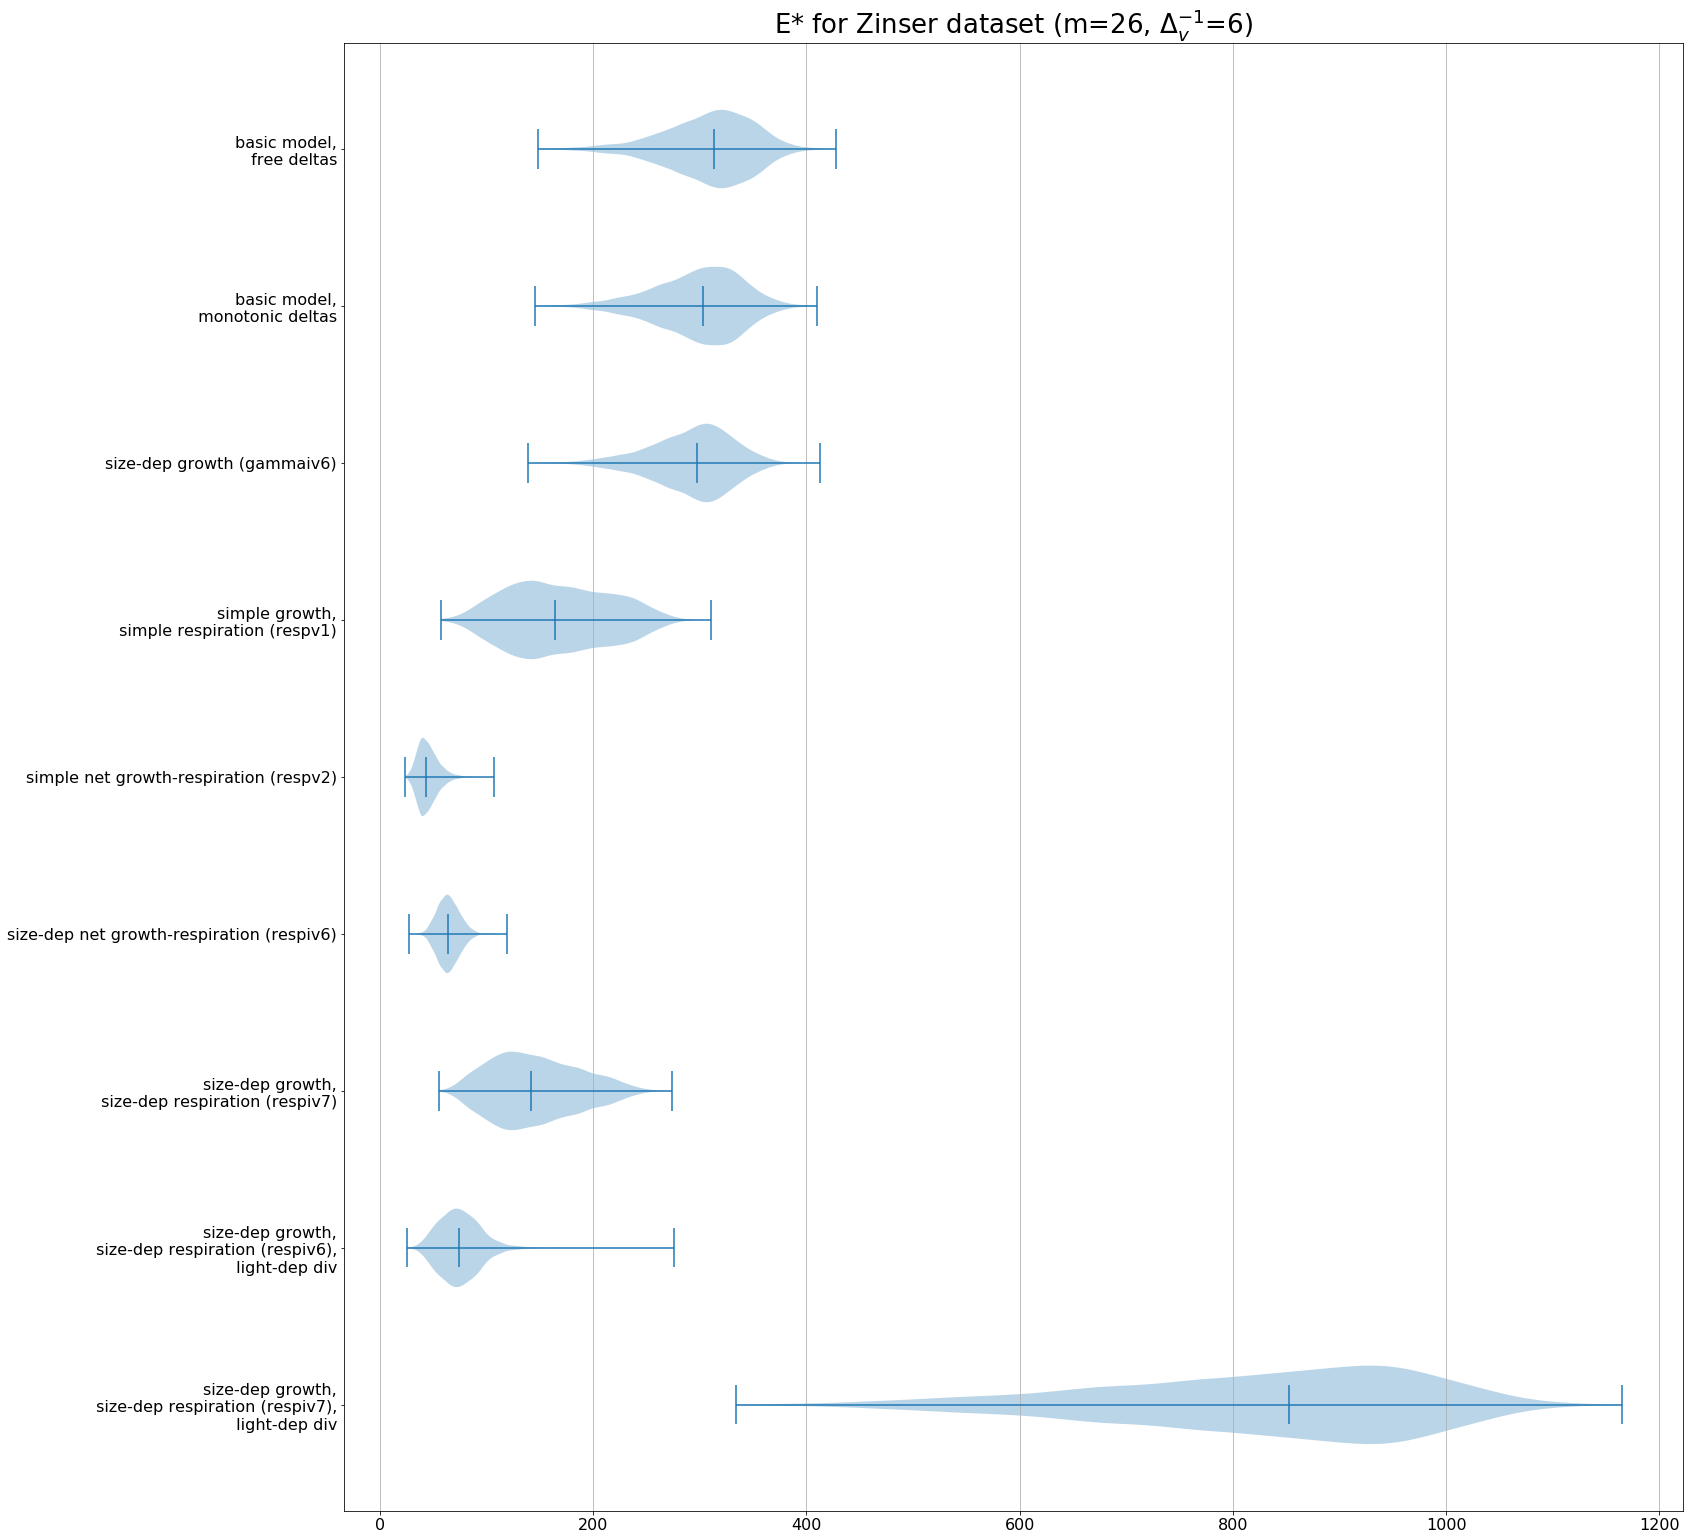

In [26]:
for param in ('divrate','E_star'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        ax.violinplot([mcmcs[name][dataname][param] for name in mcmcs], showmedians=True, vert=False)
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,name in enumerate(mcmcs):
            if maxrhats_final[name][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

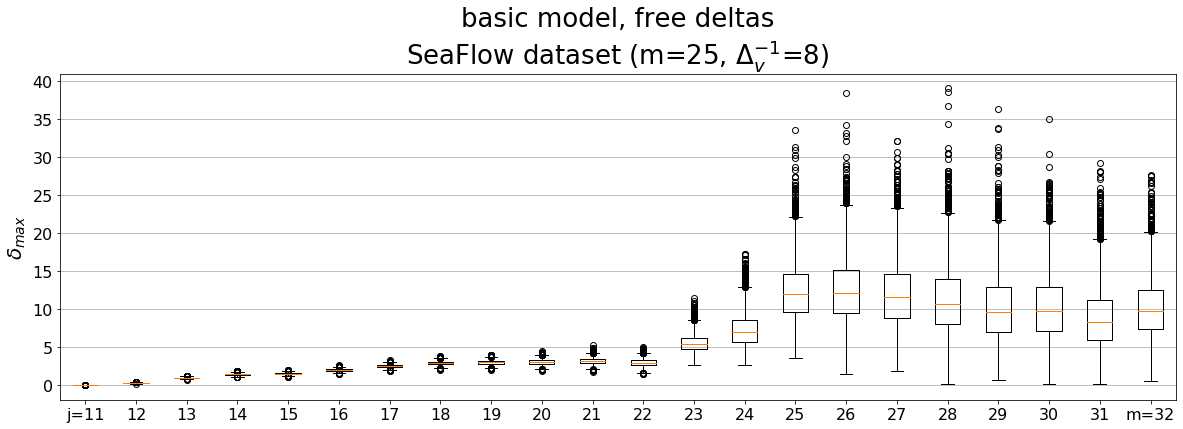

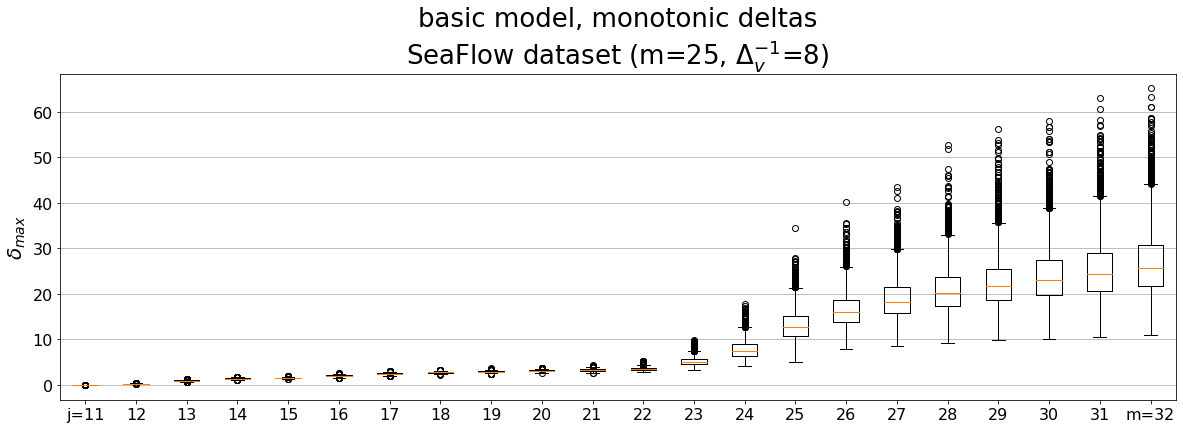

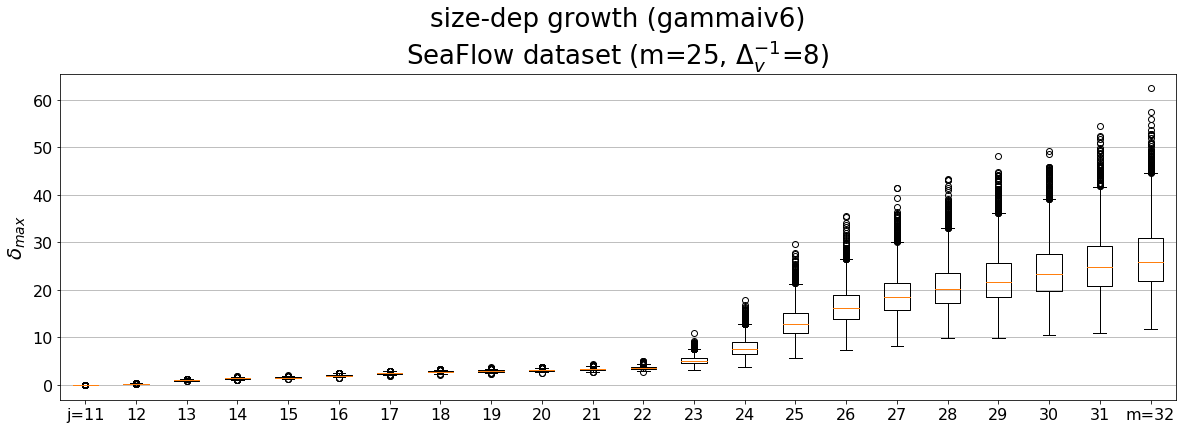

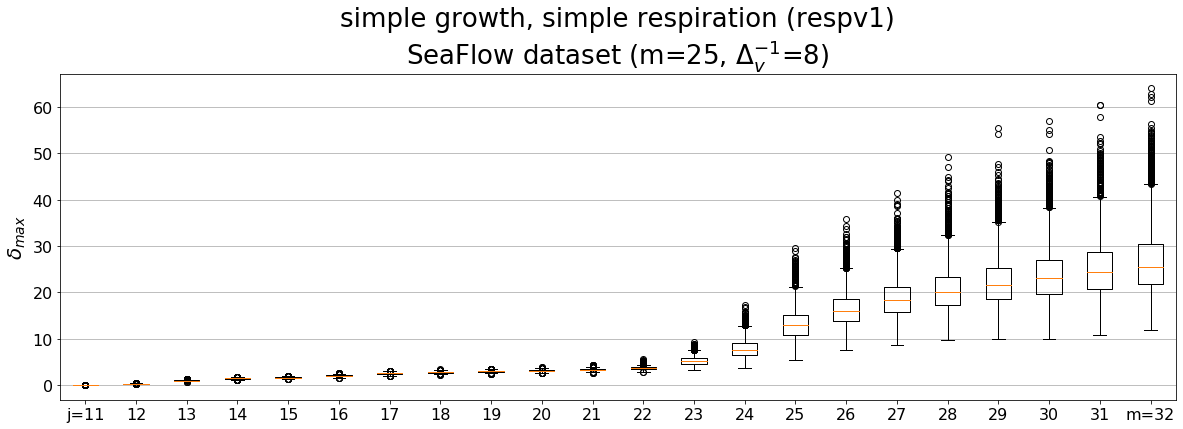

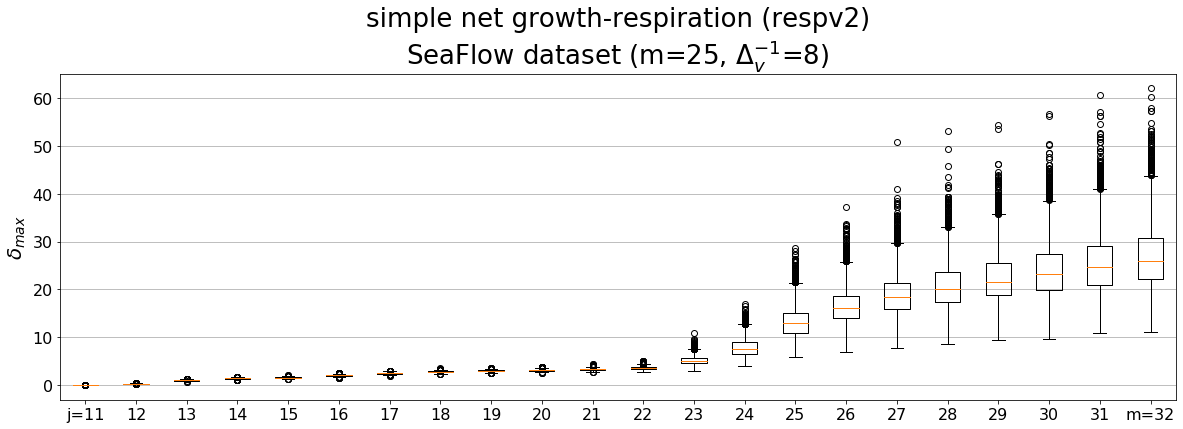

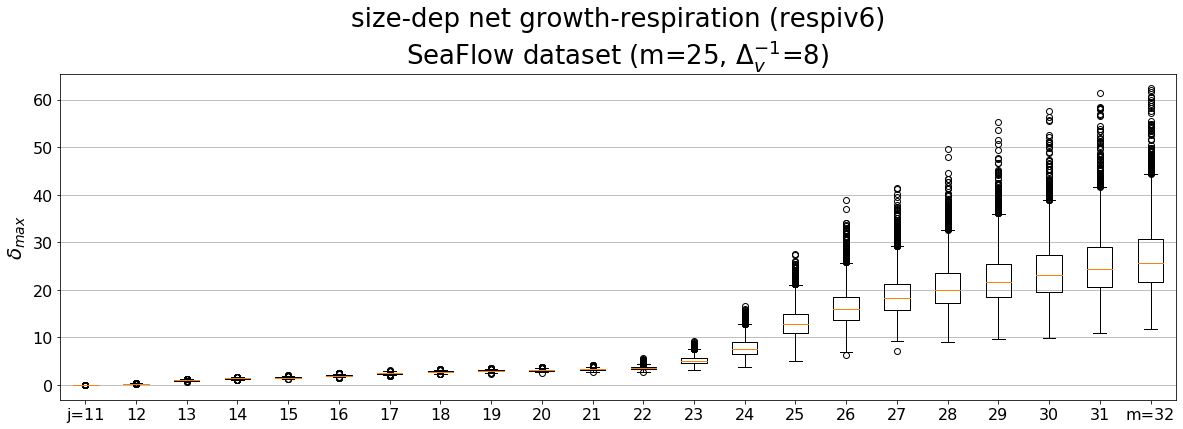

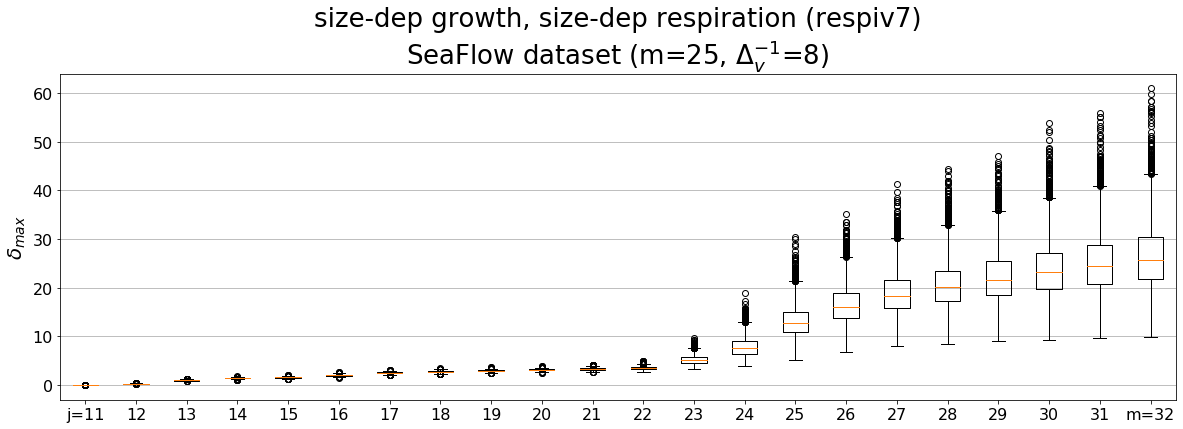

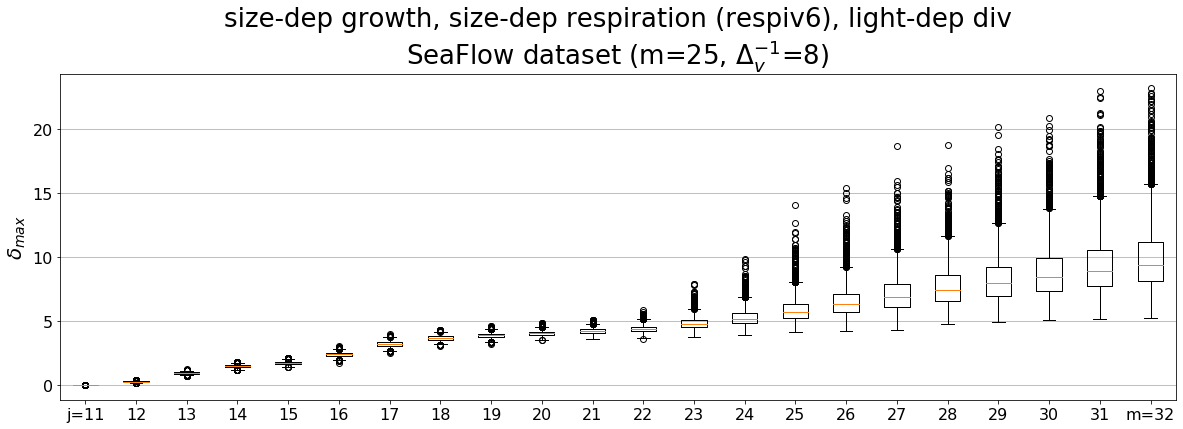

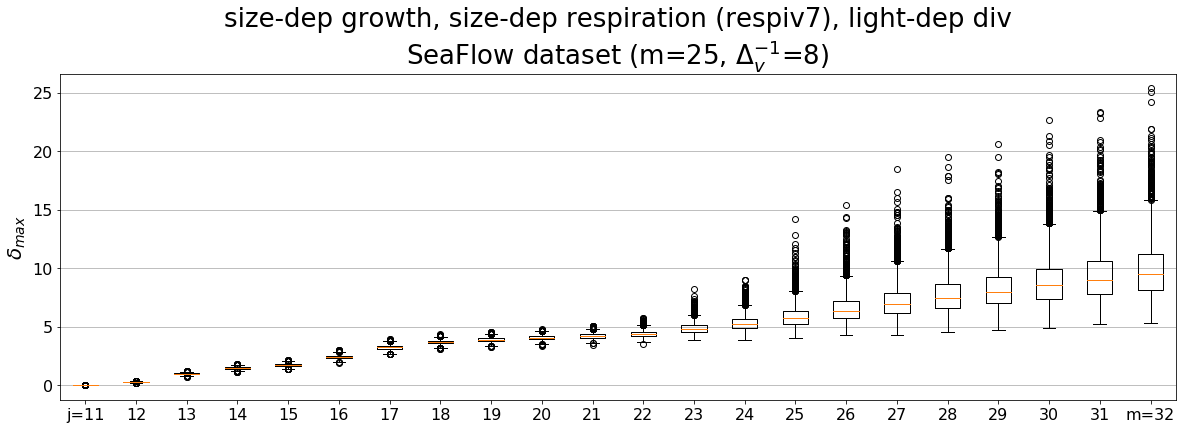

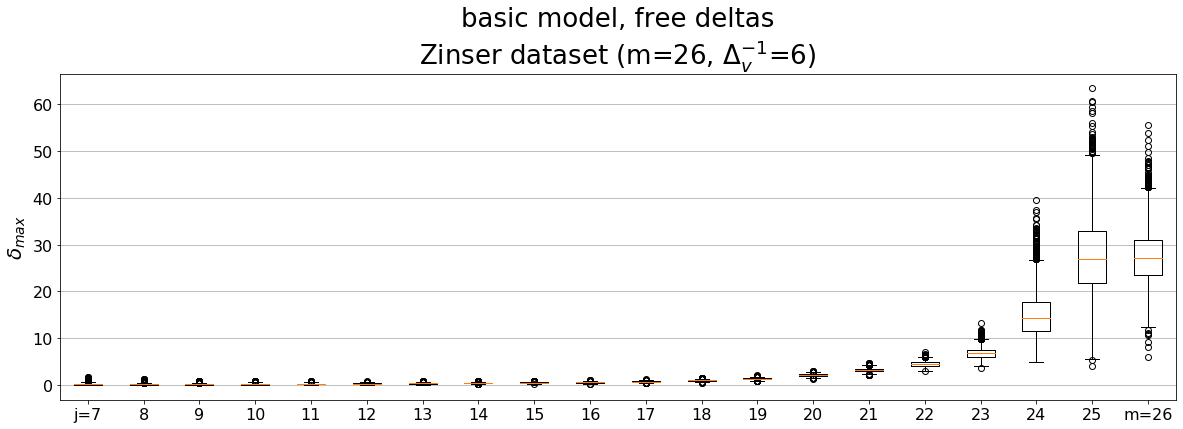

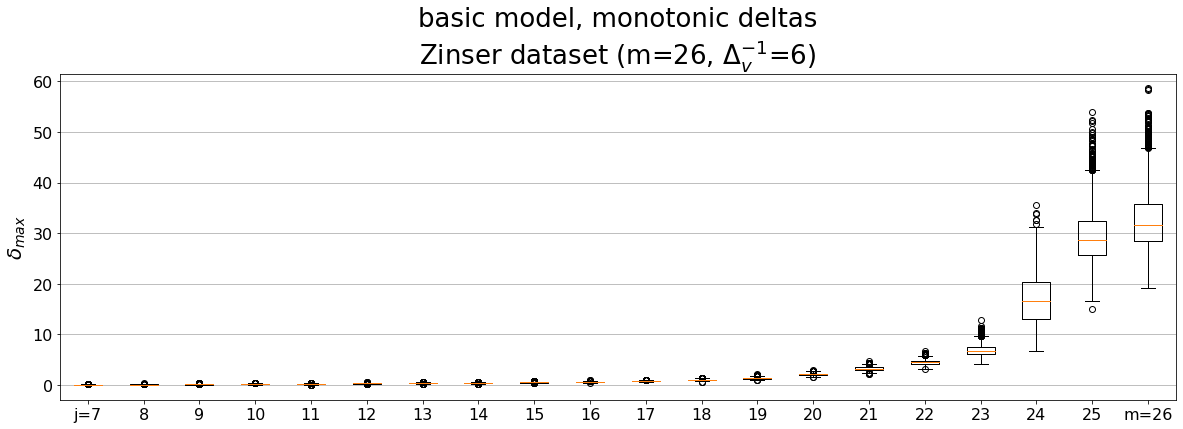

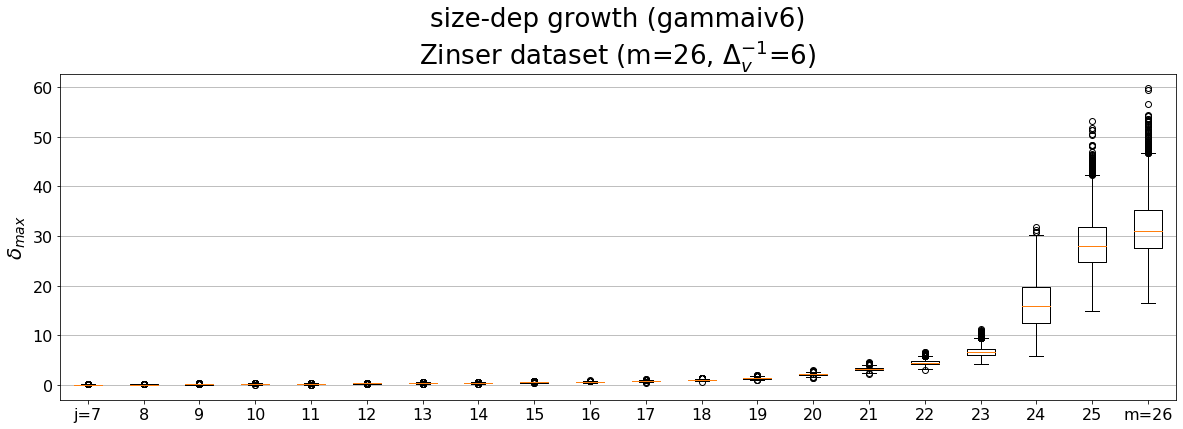

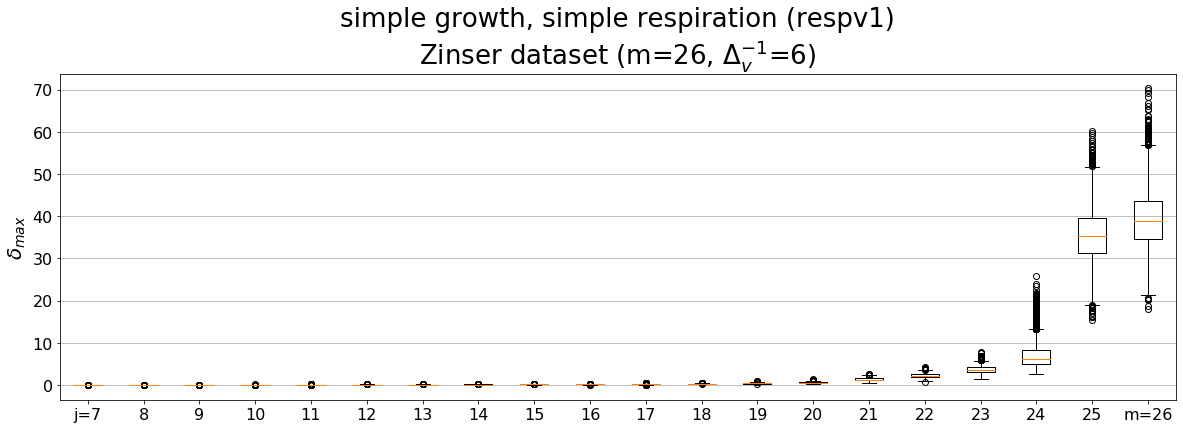

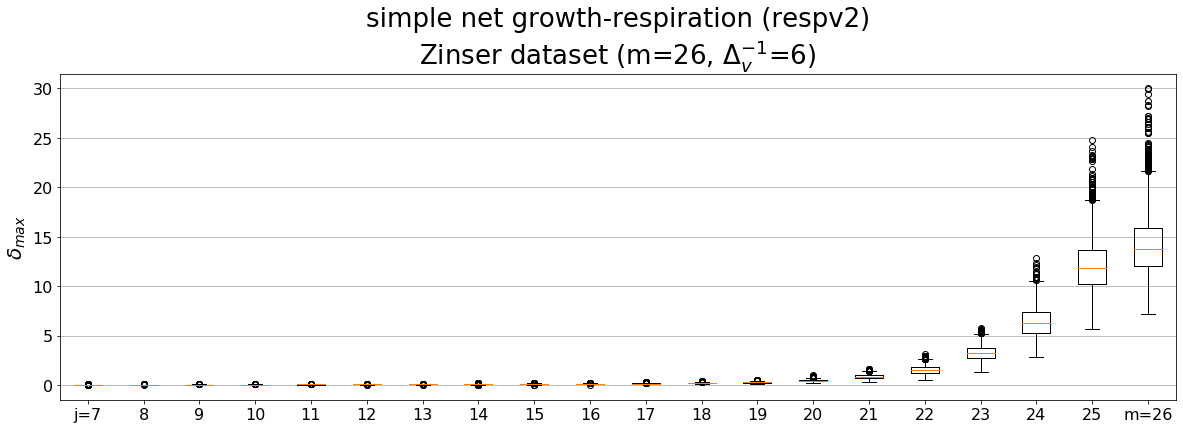

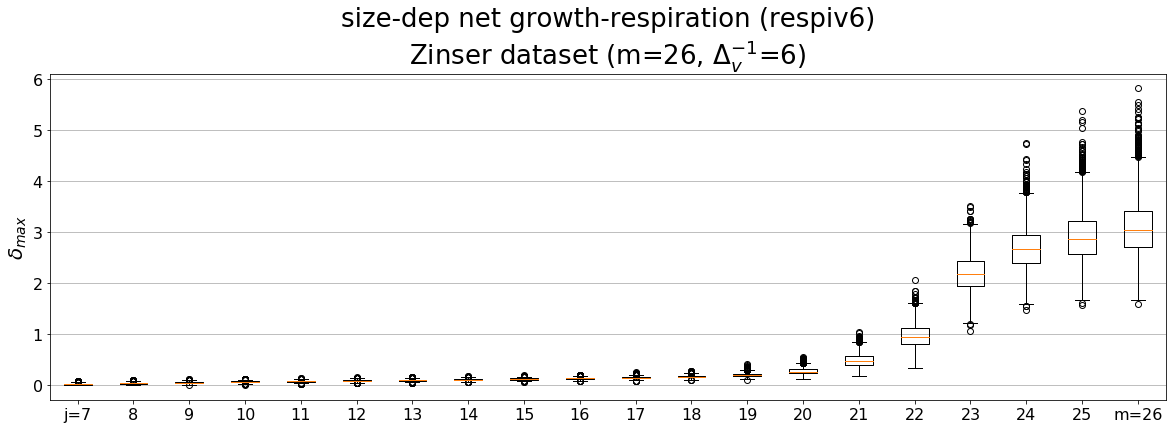

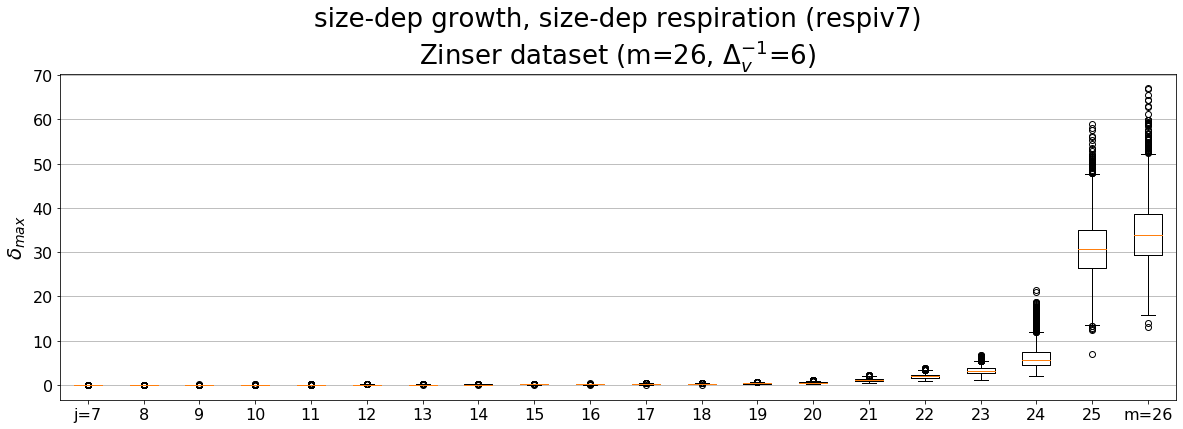

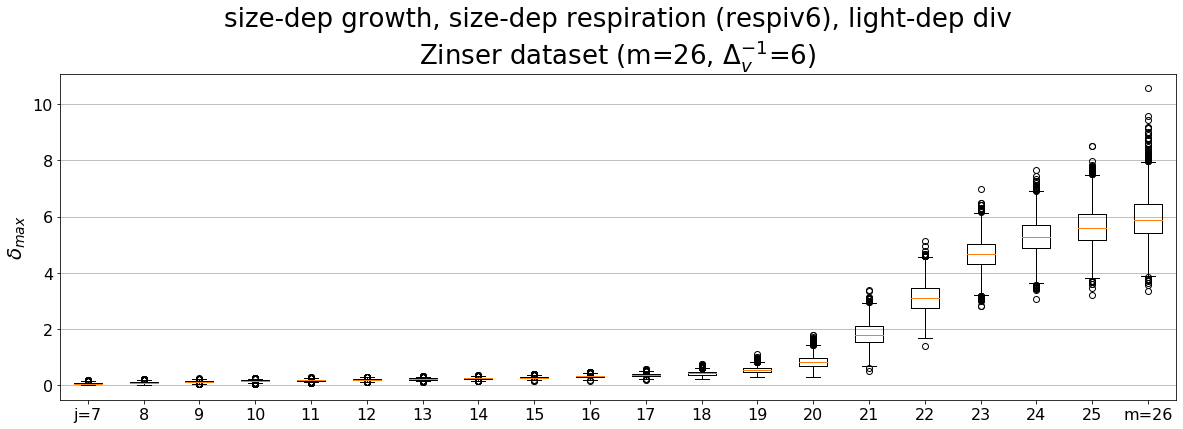

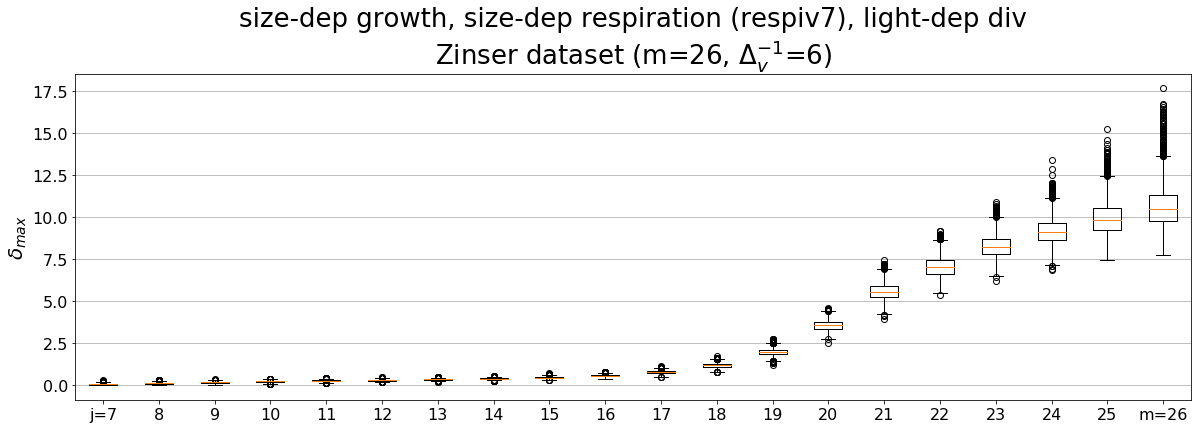

In [27]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

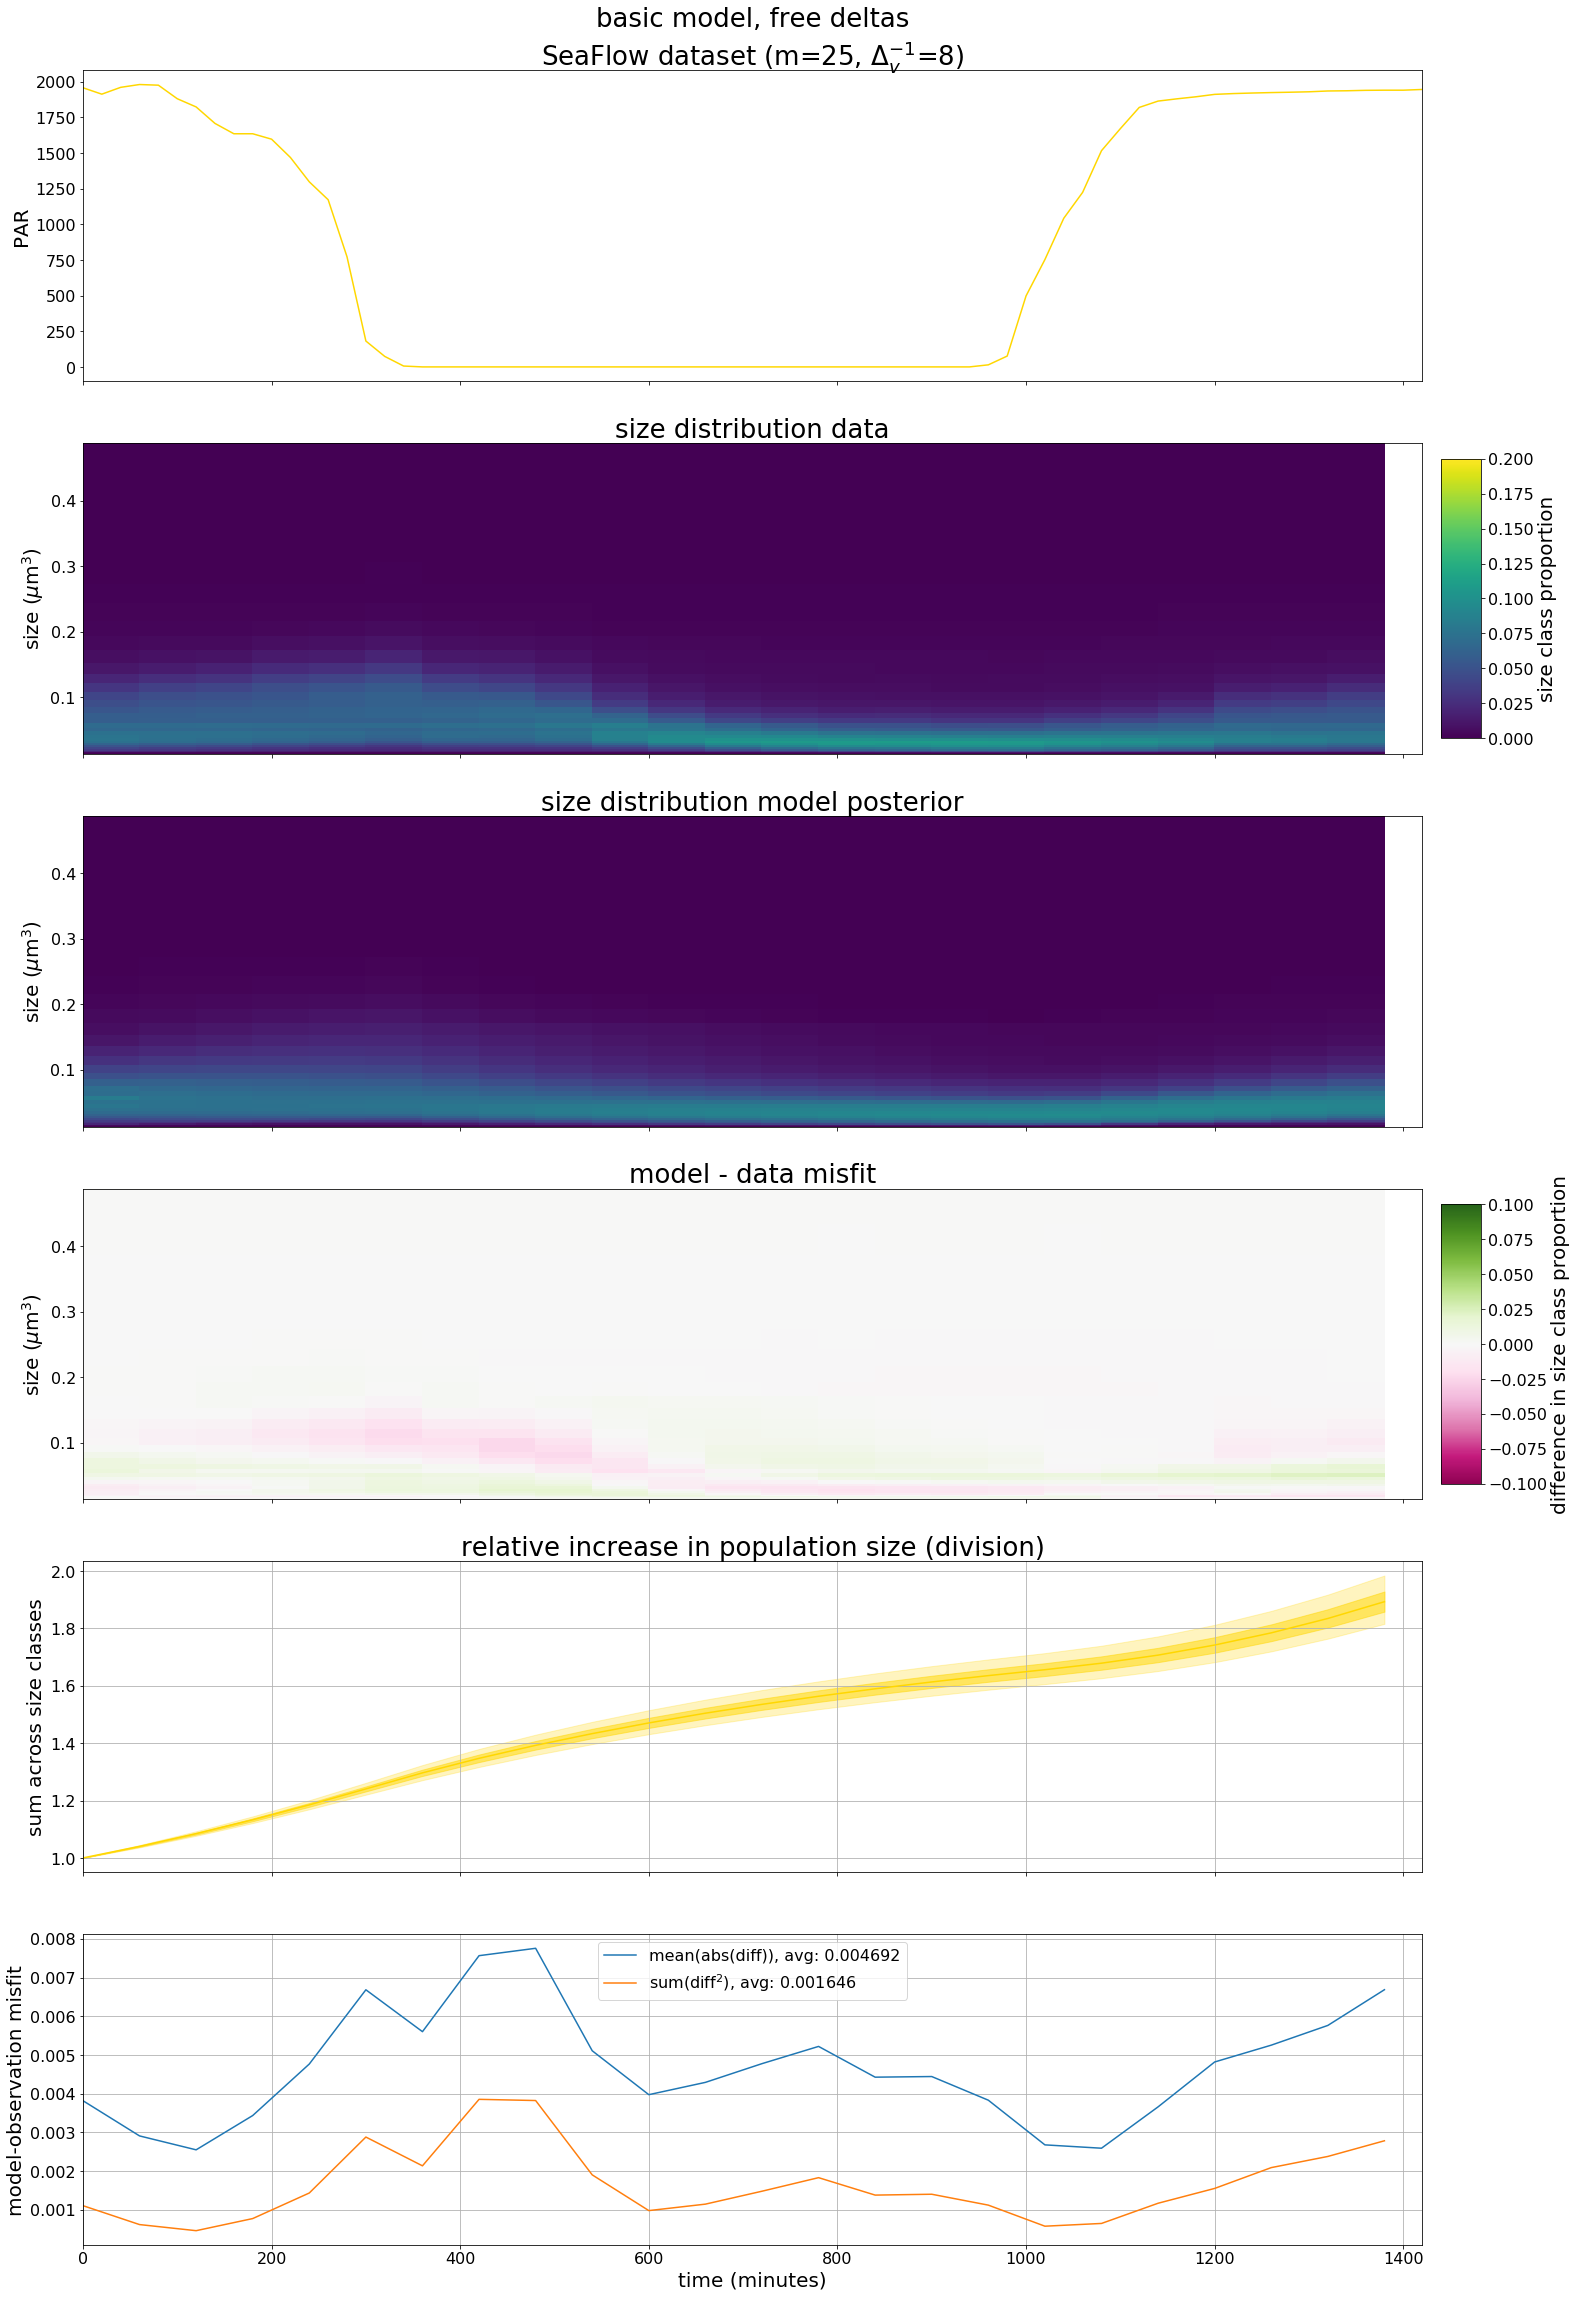

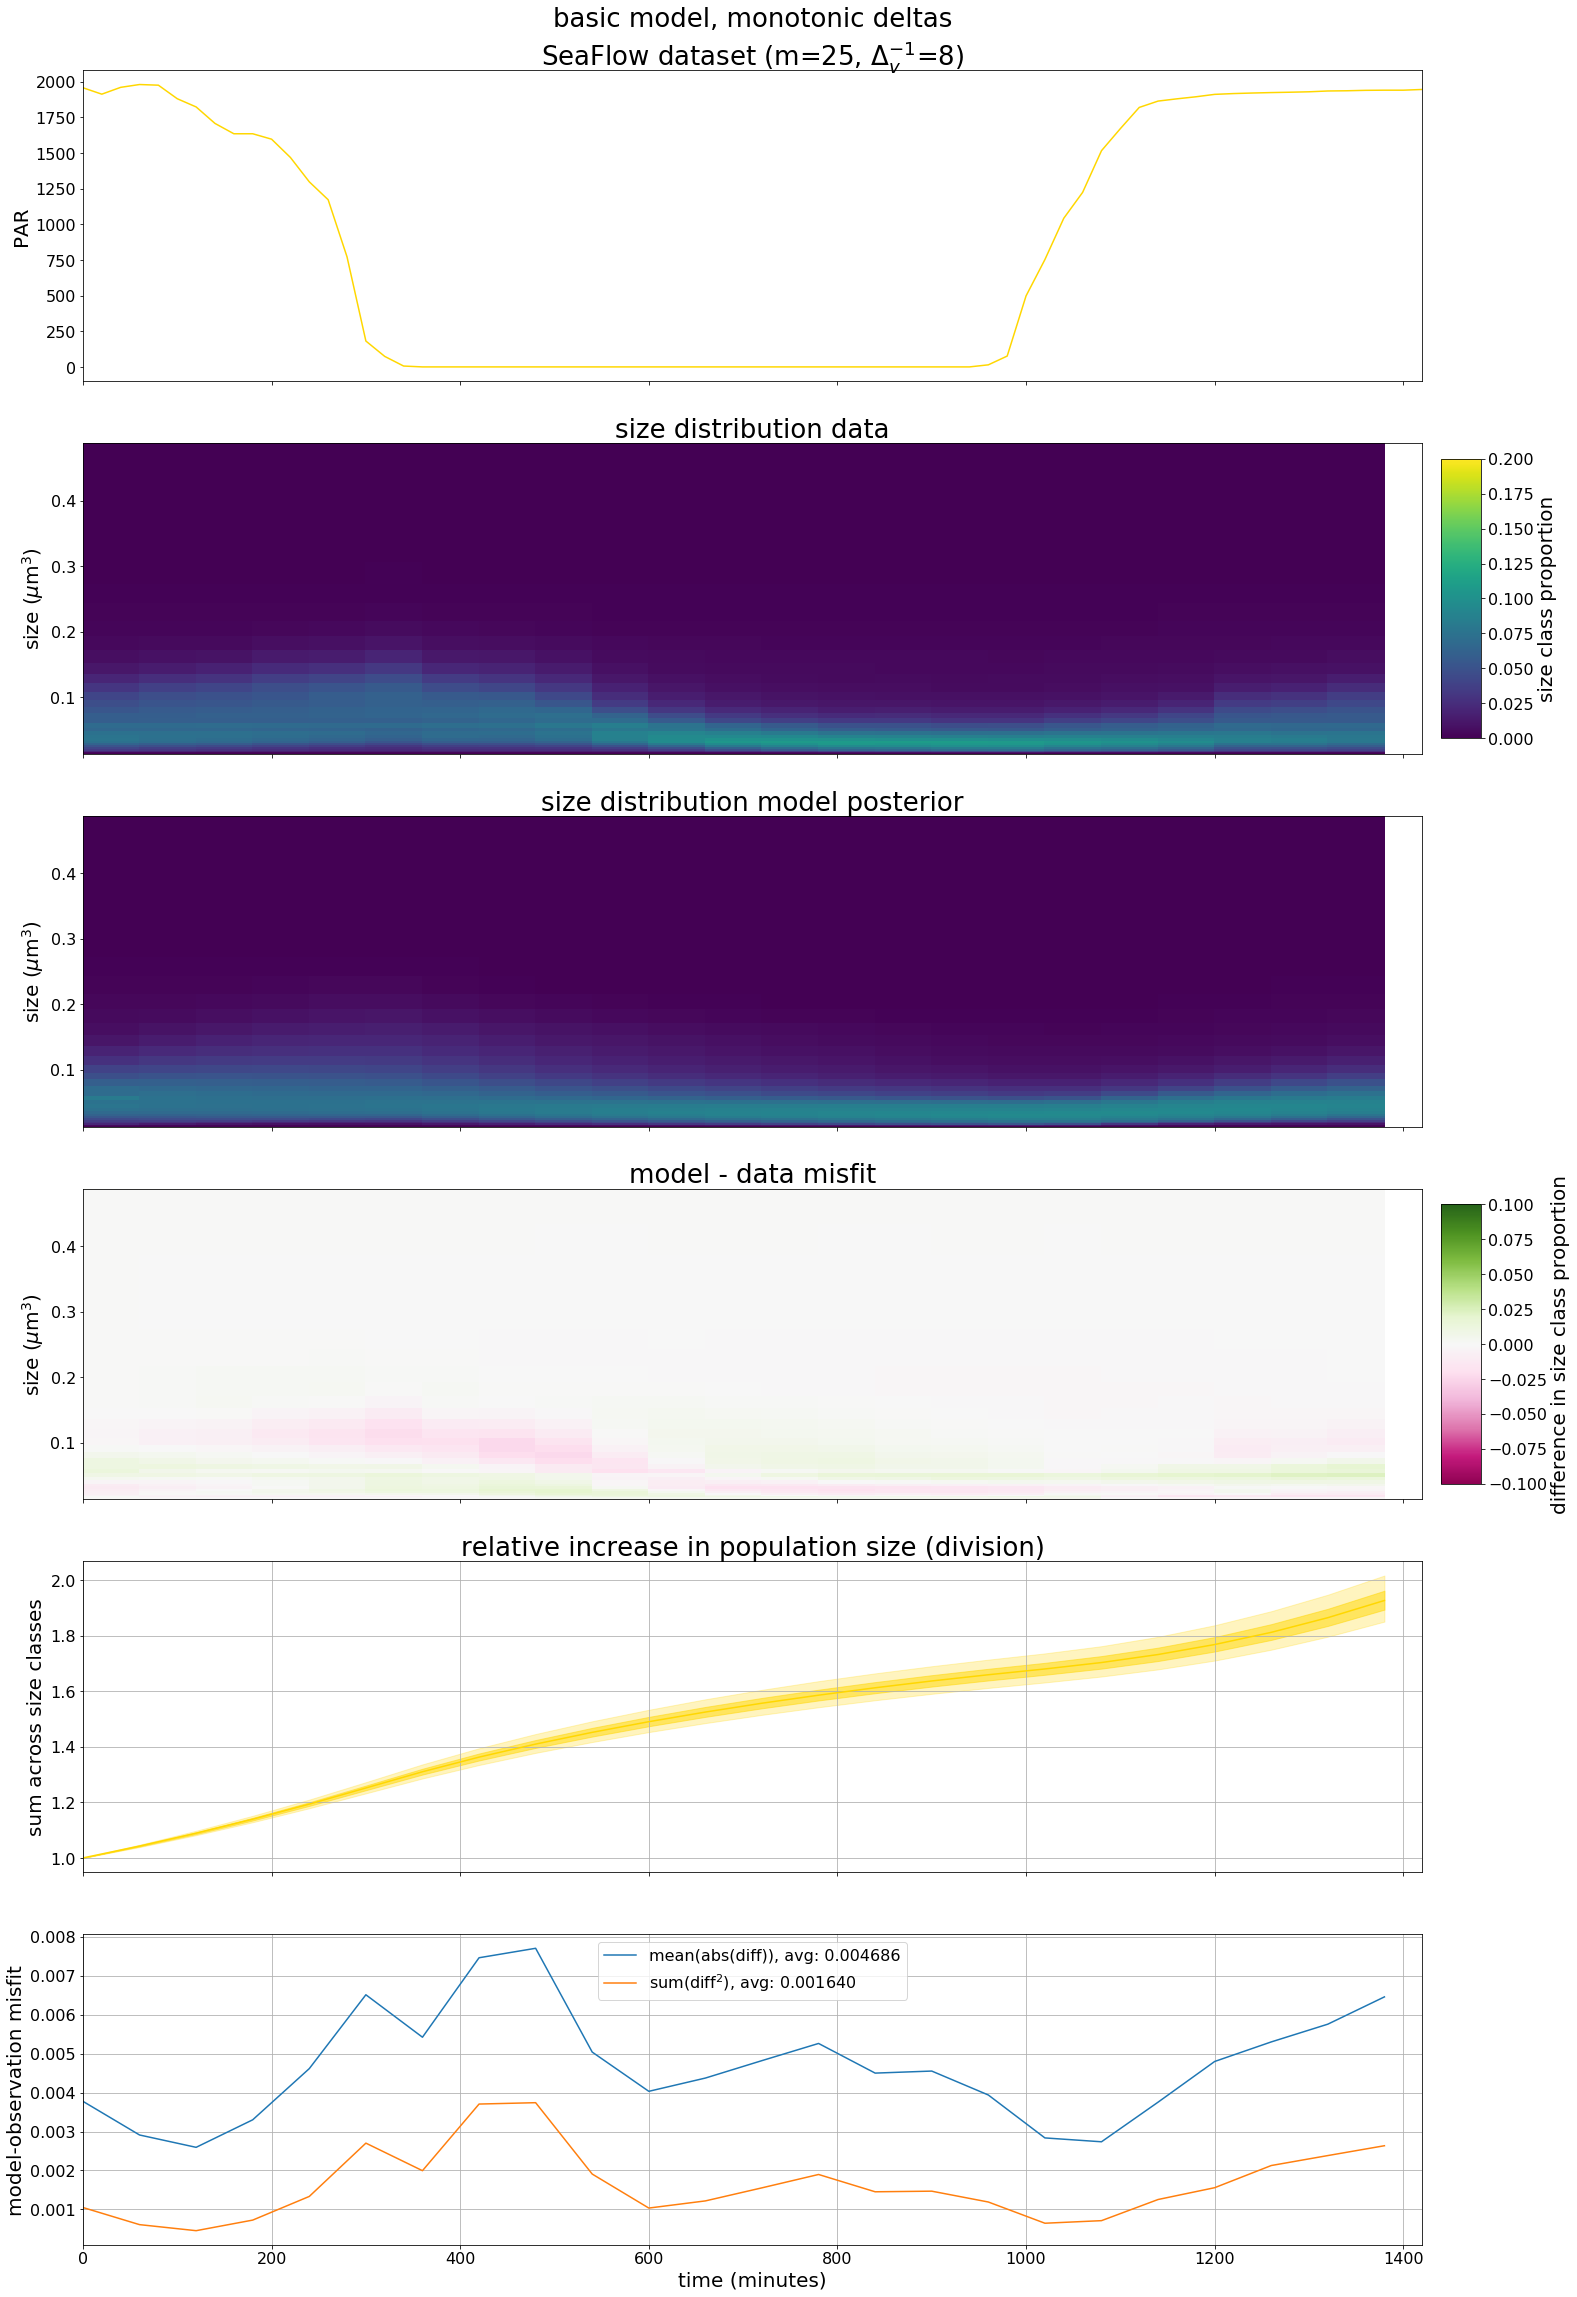

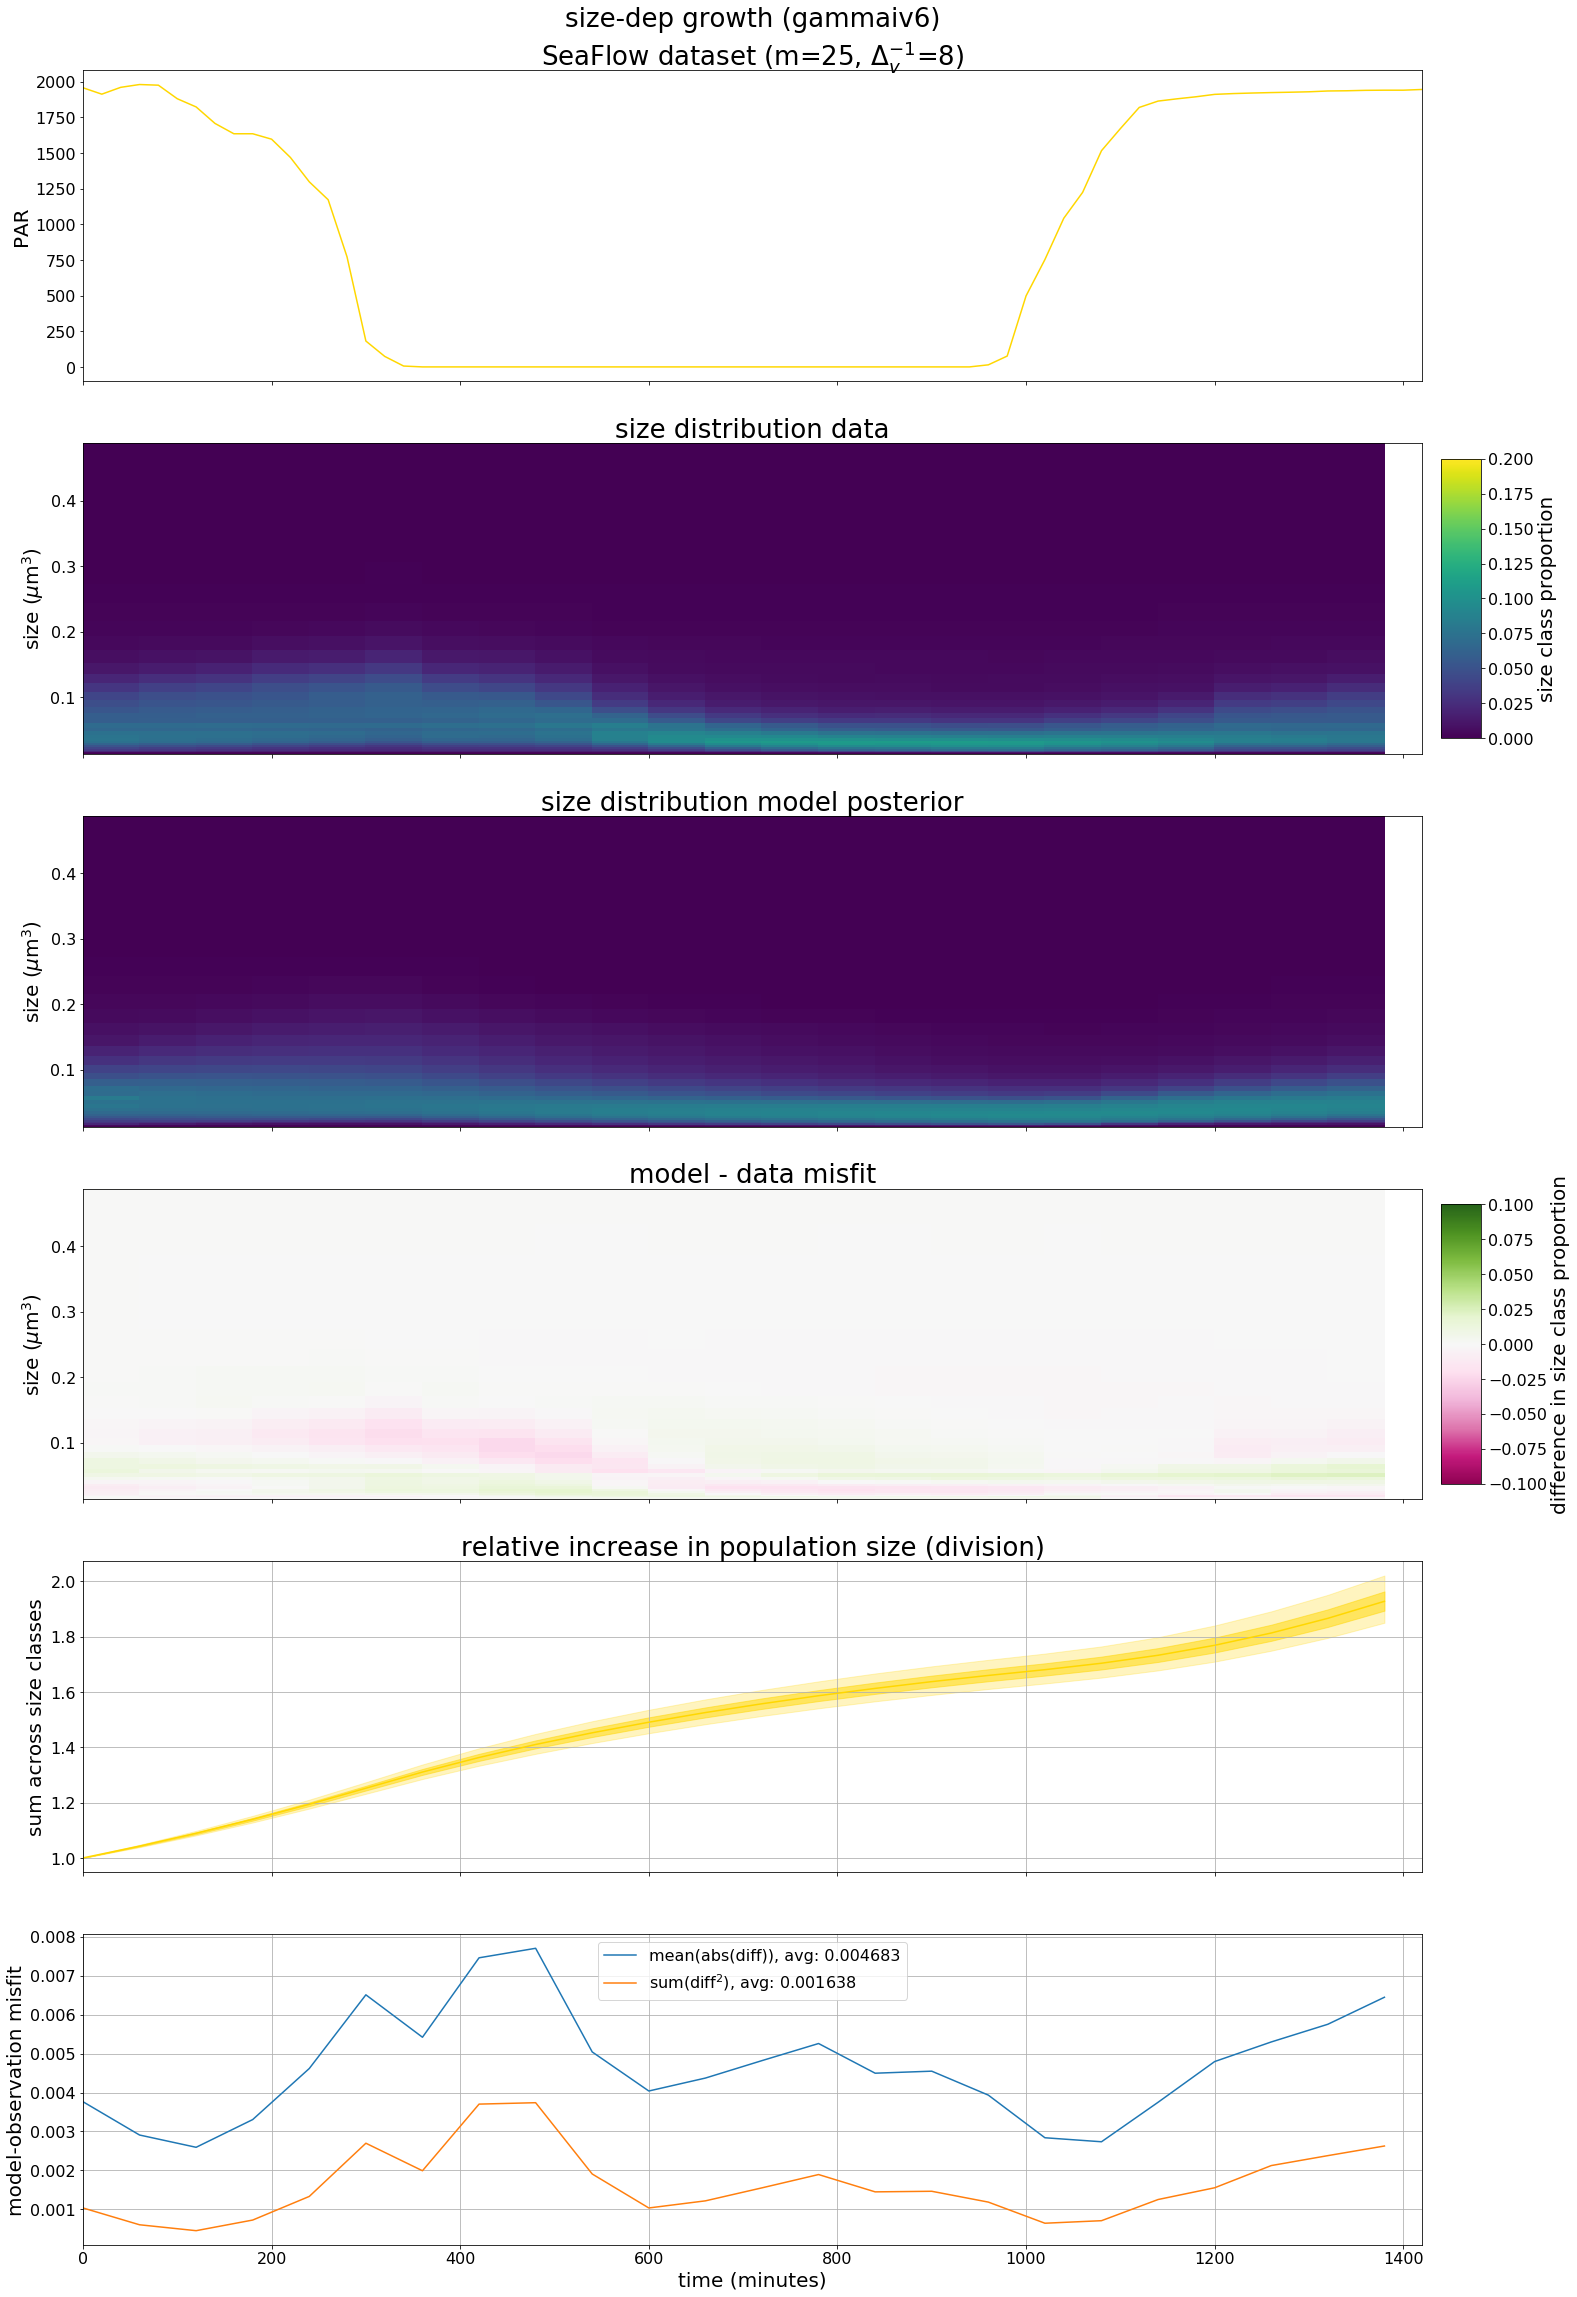

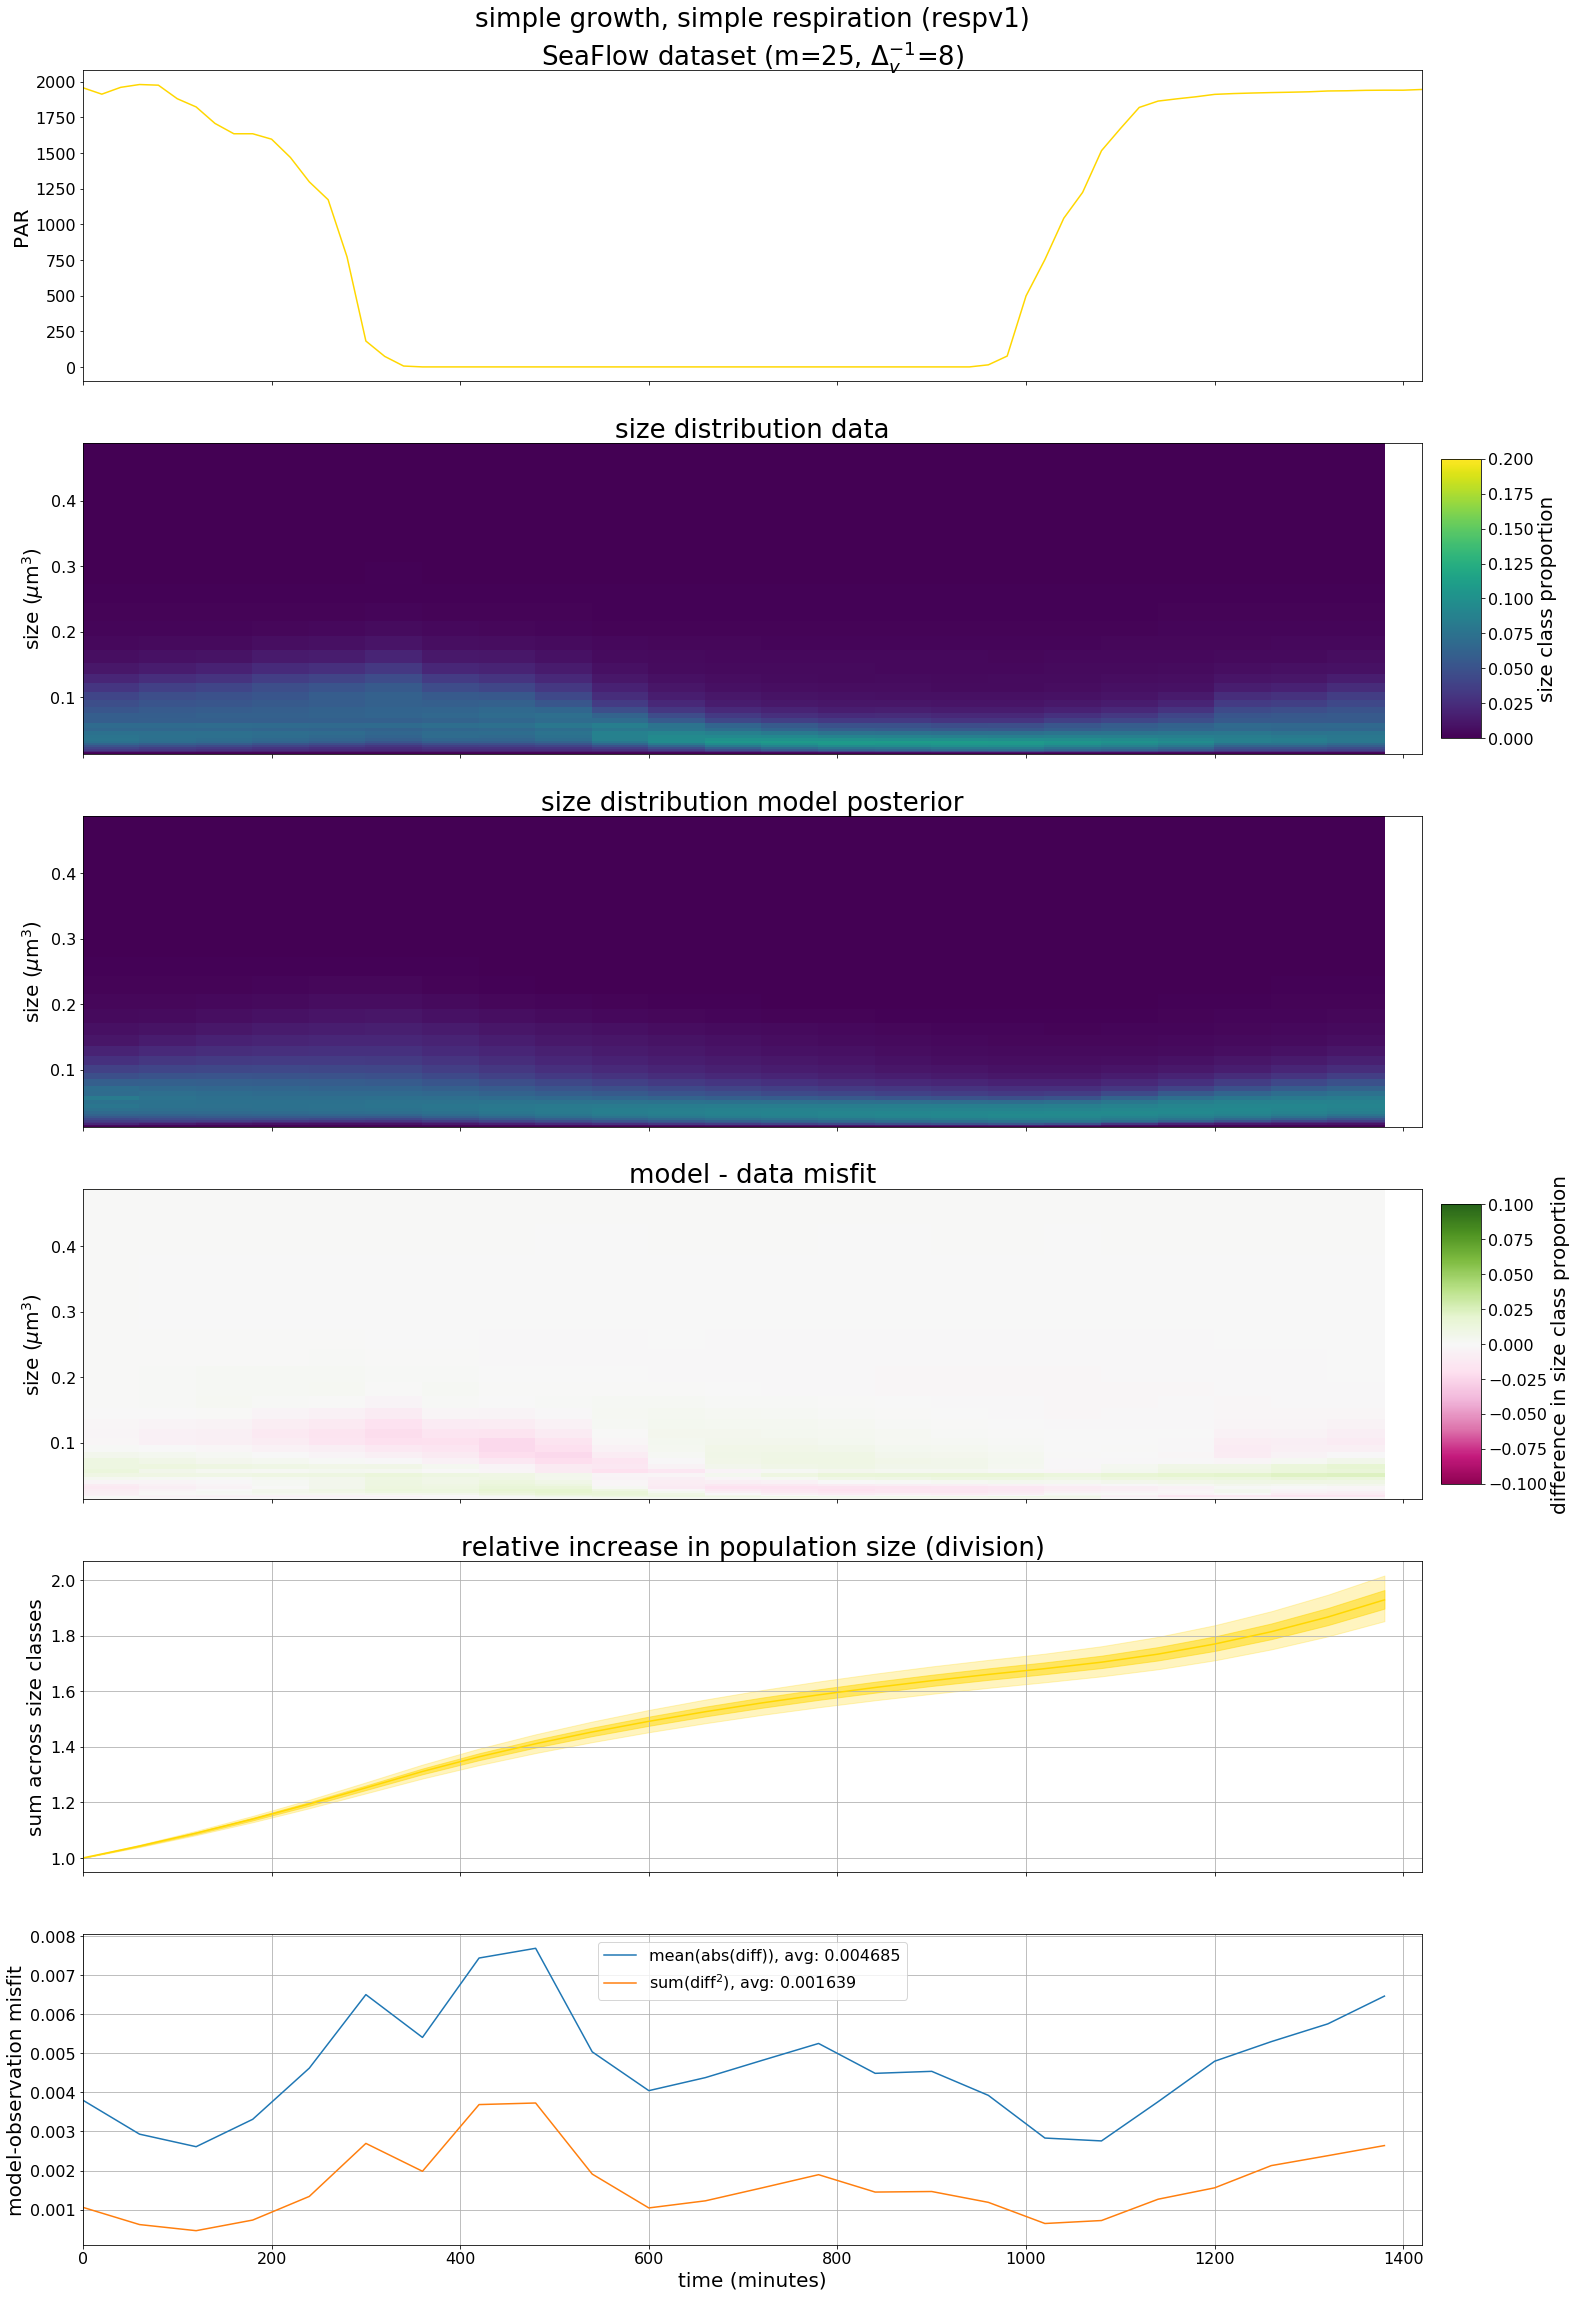

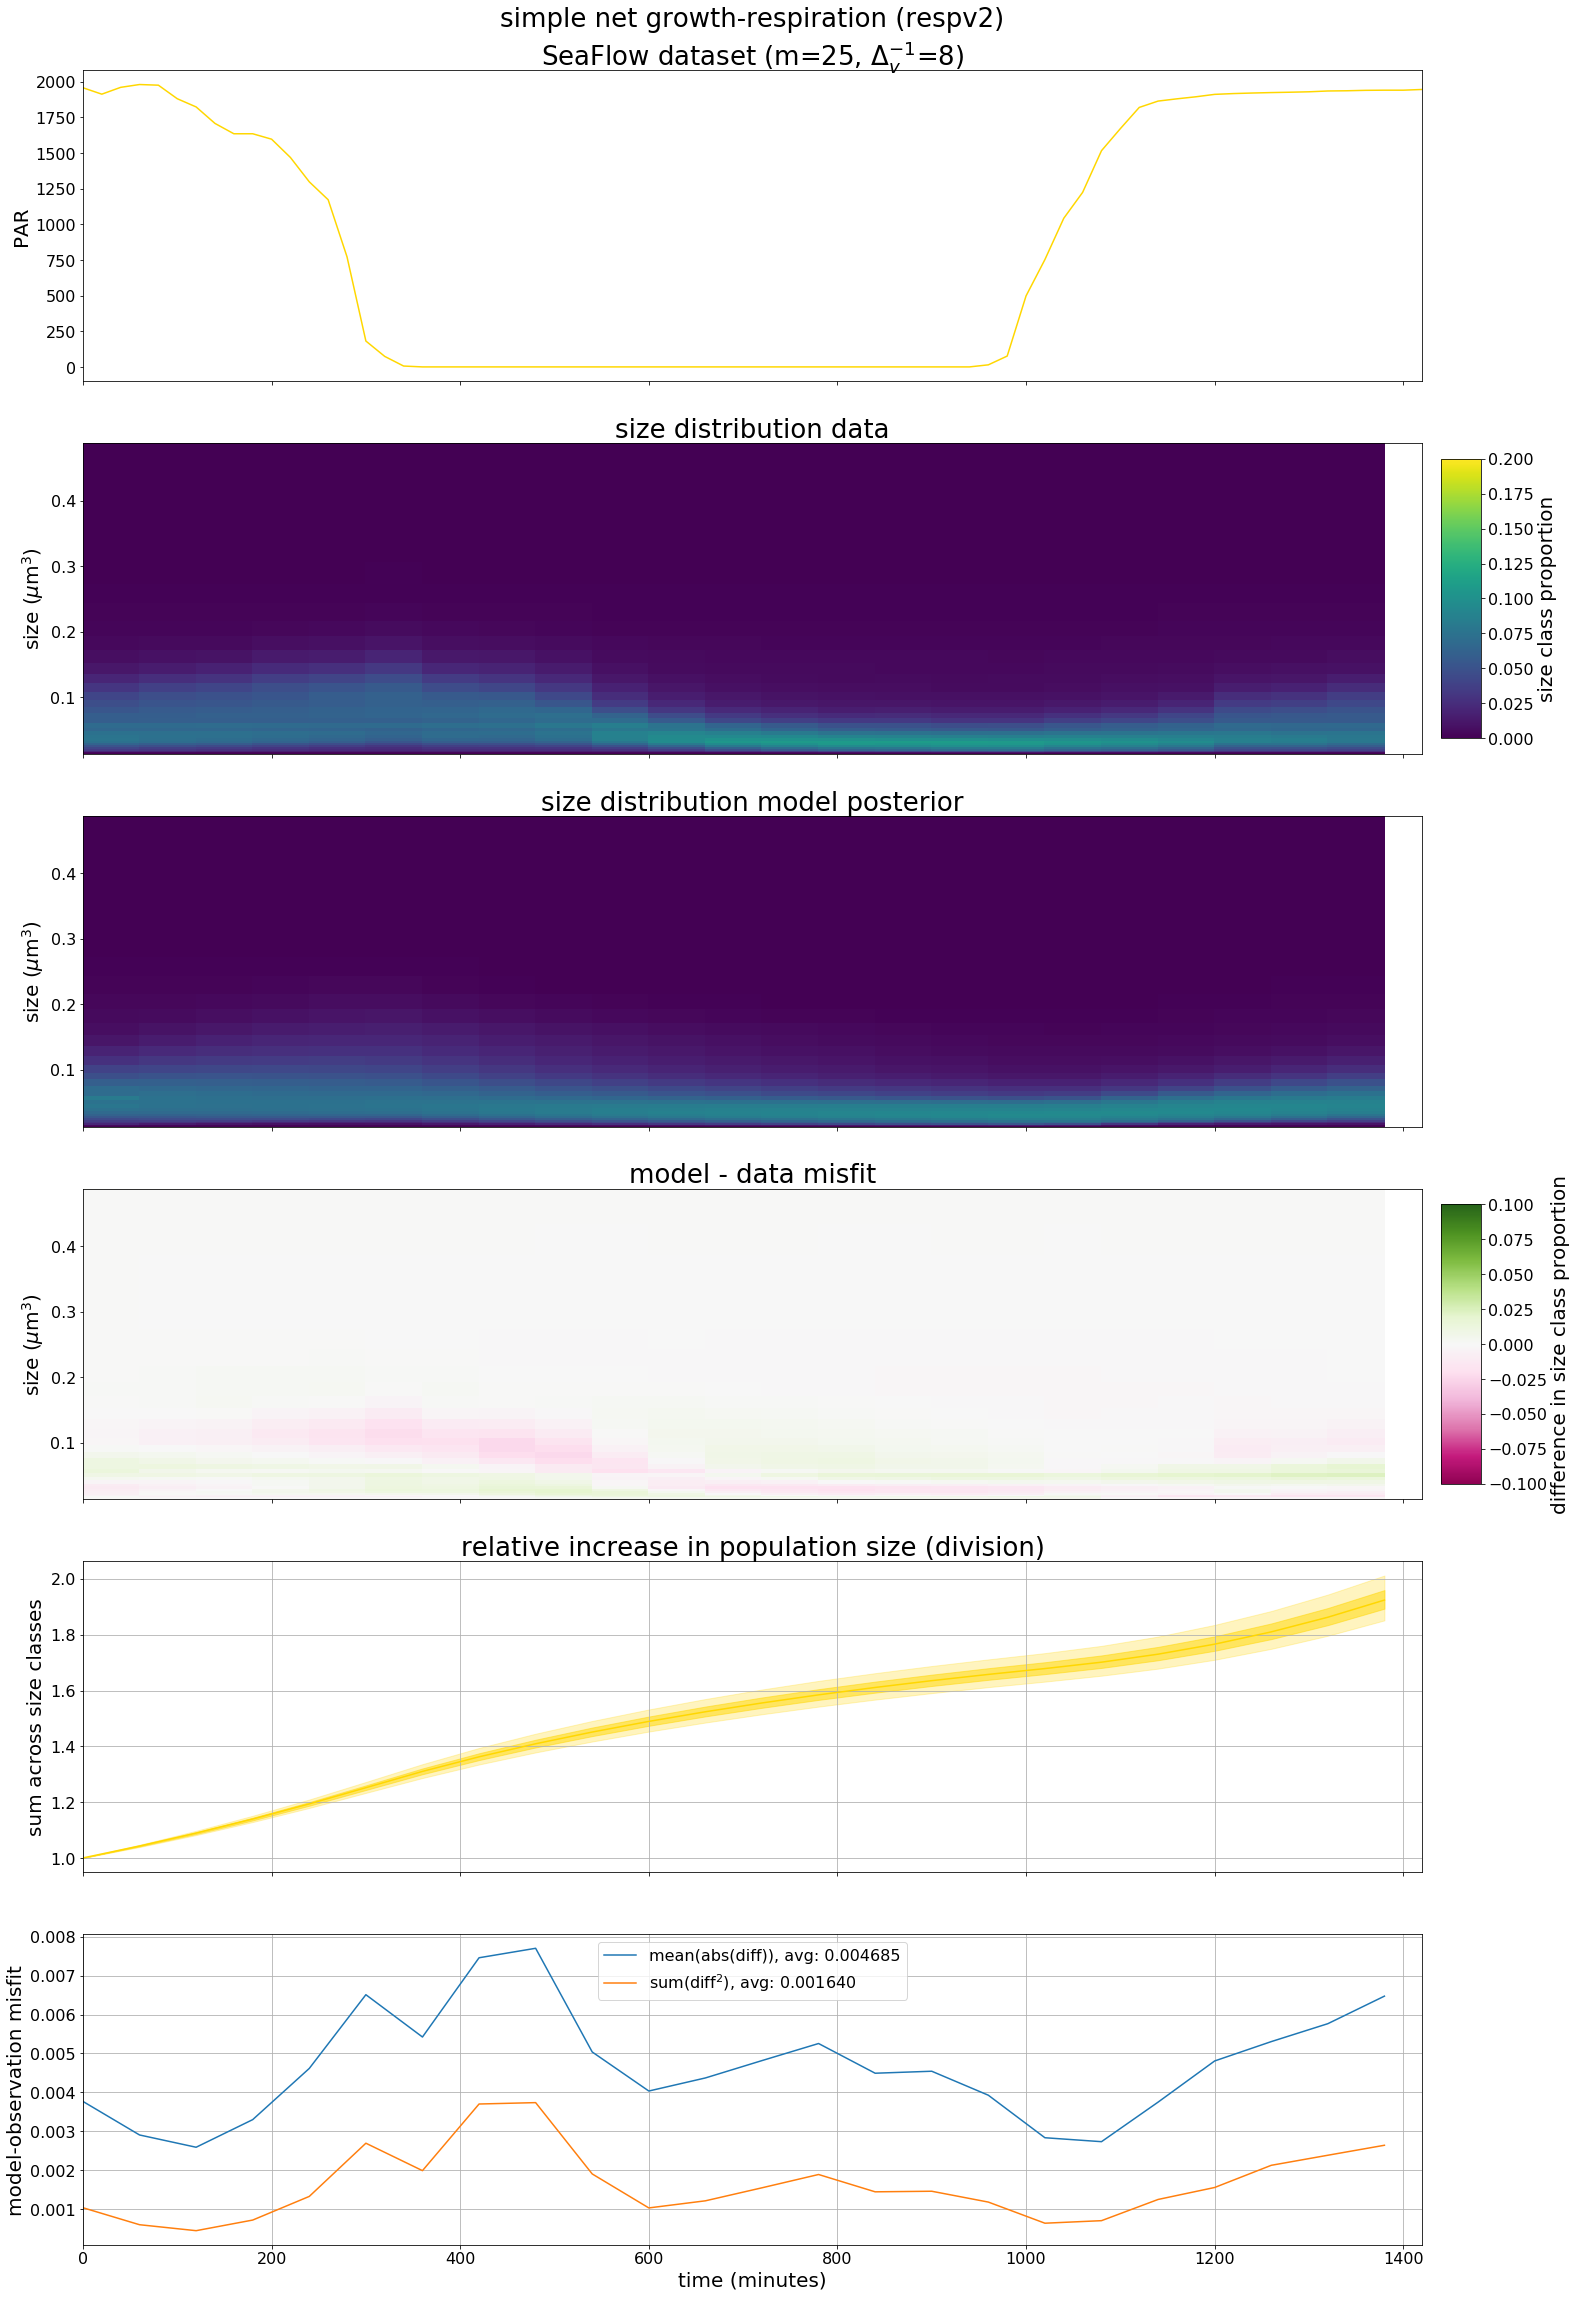

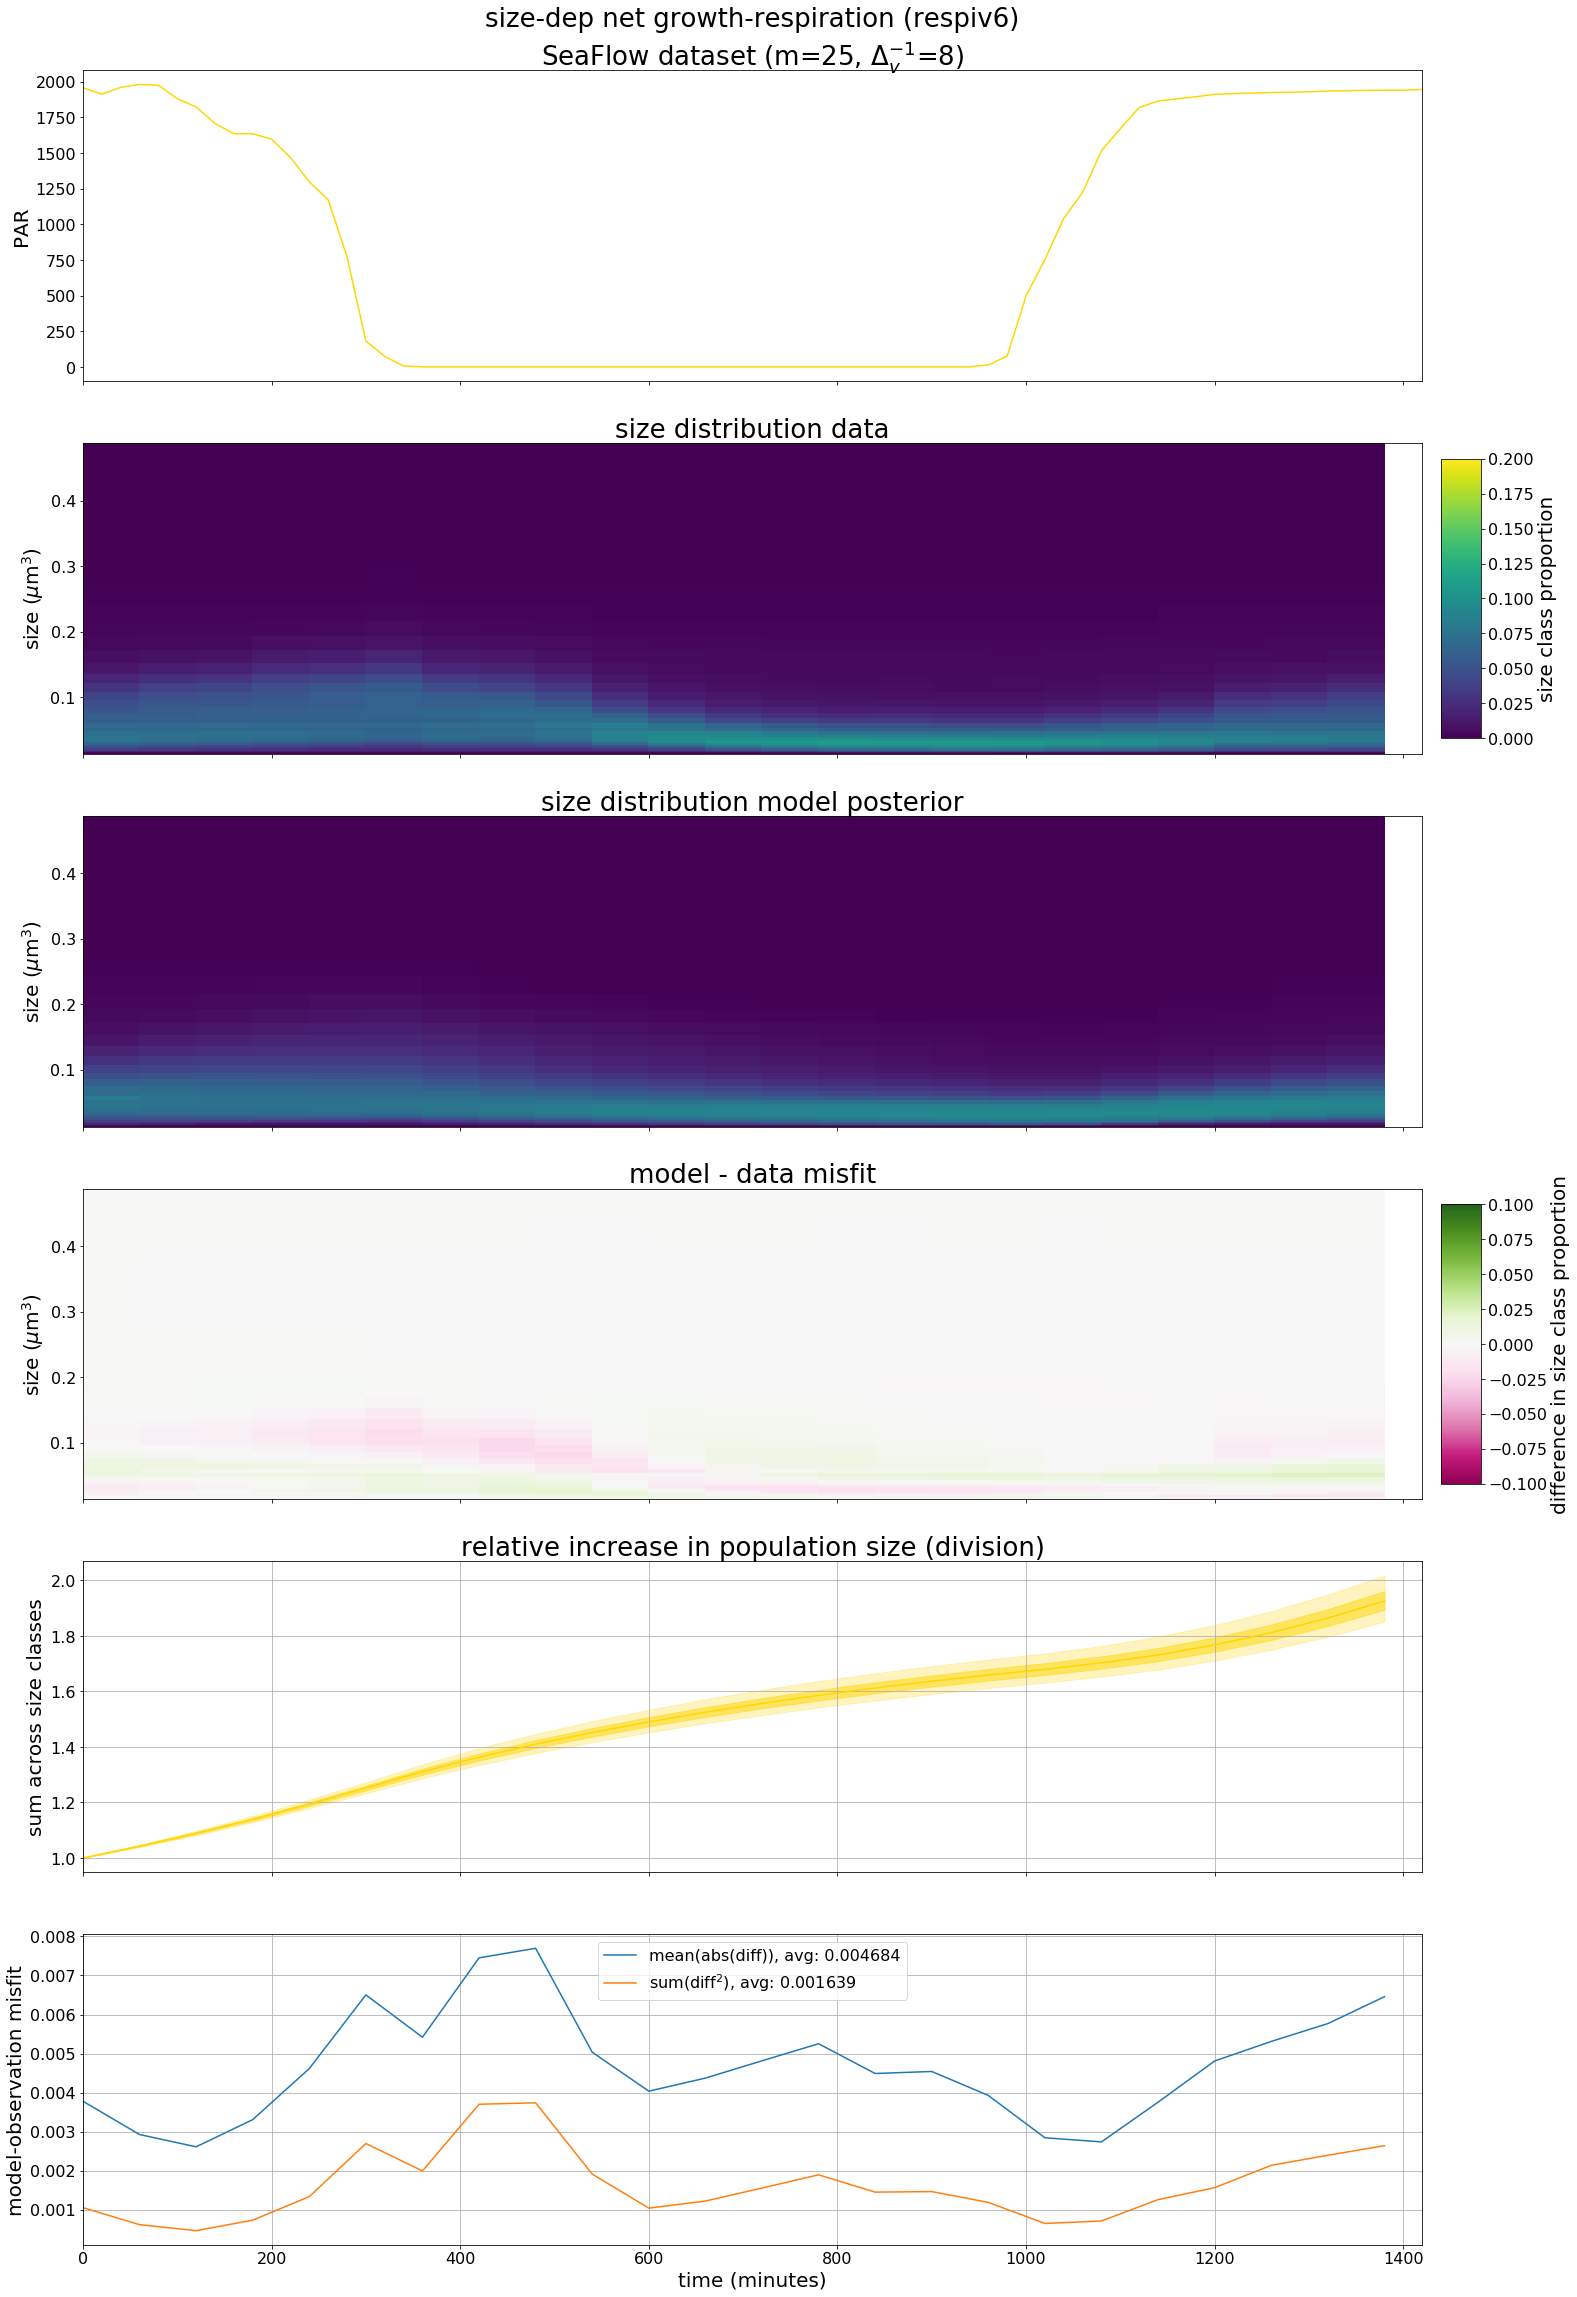

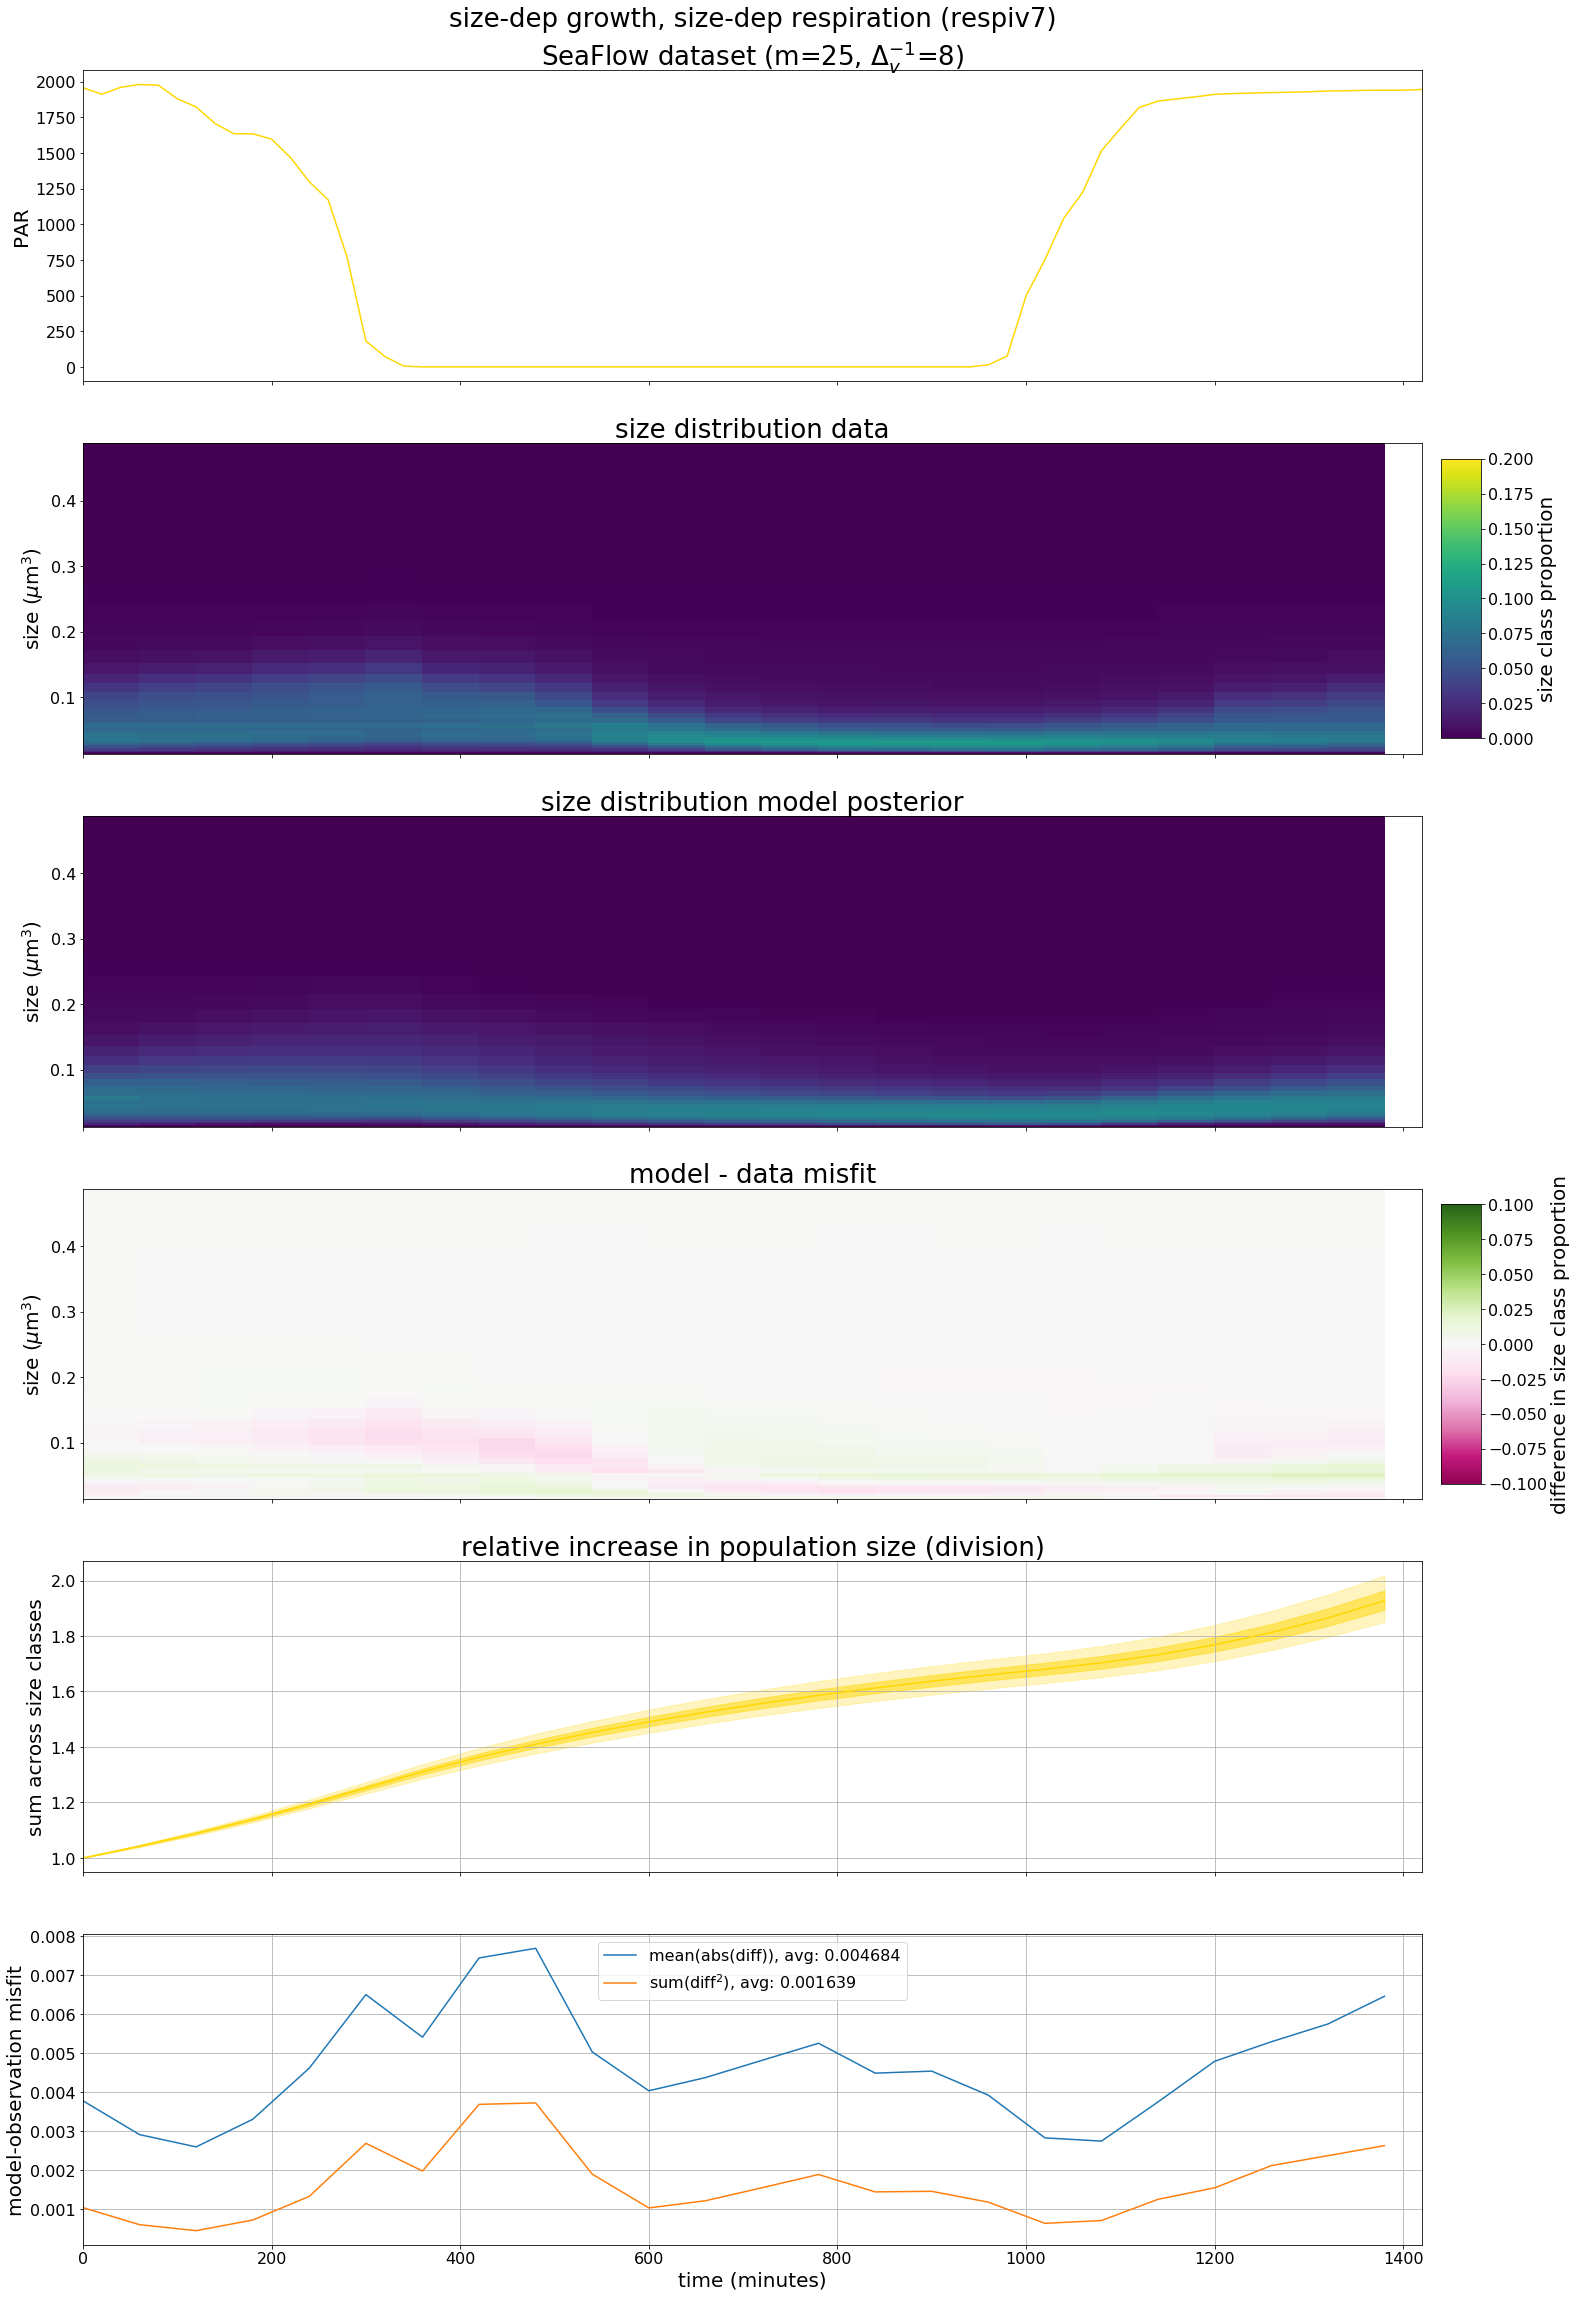

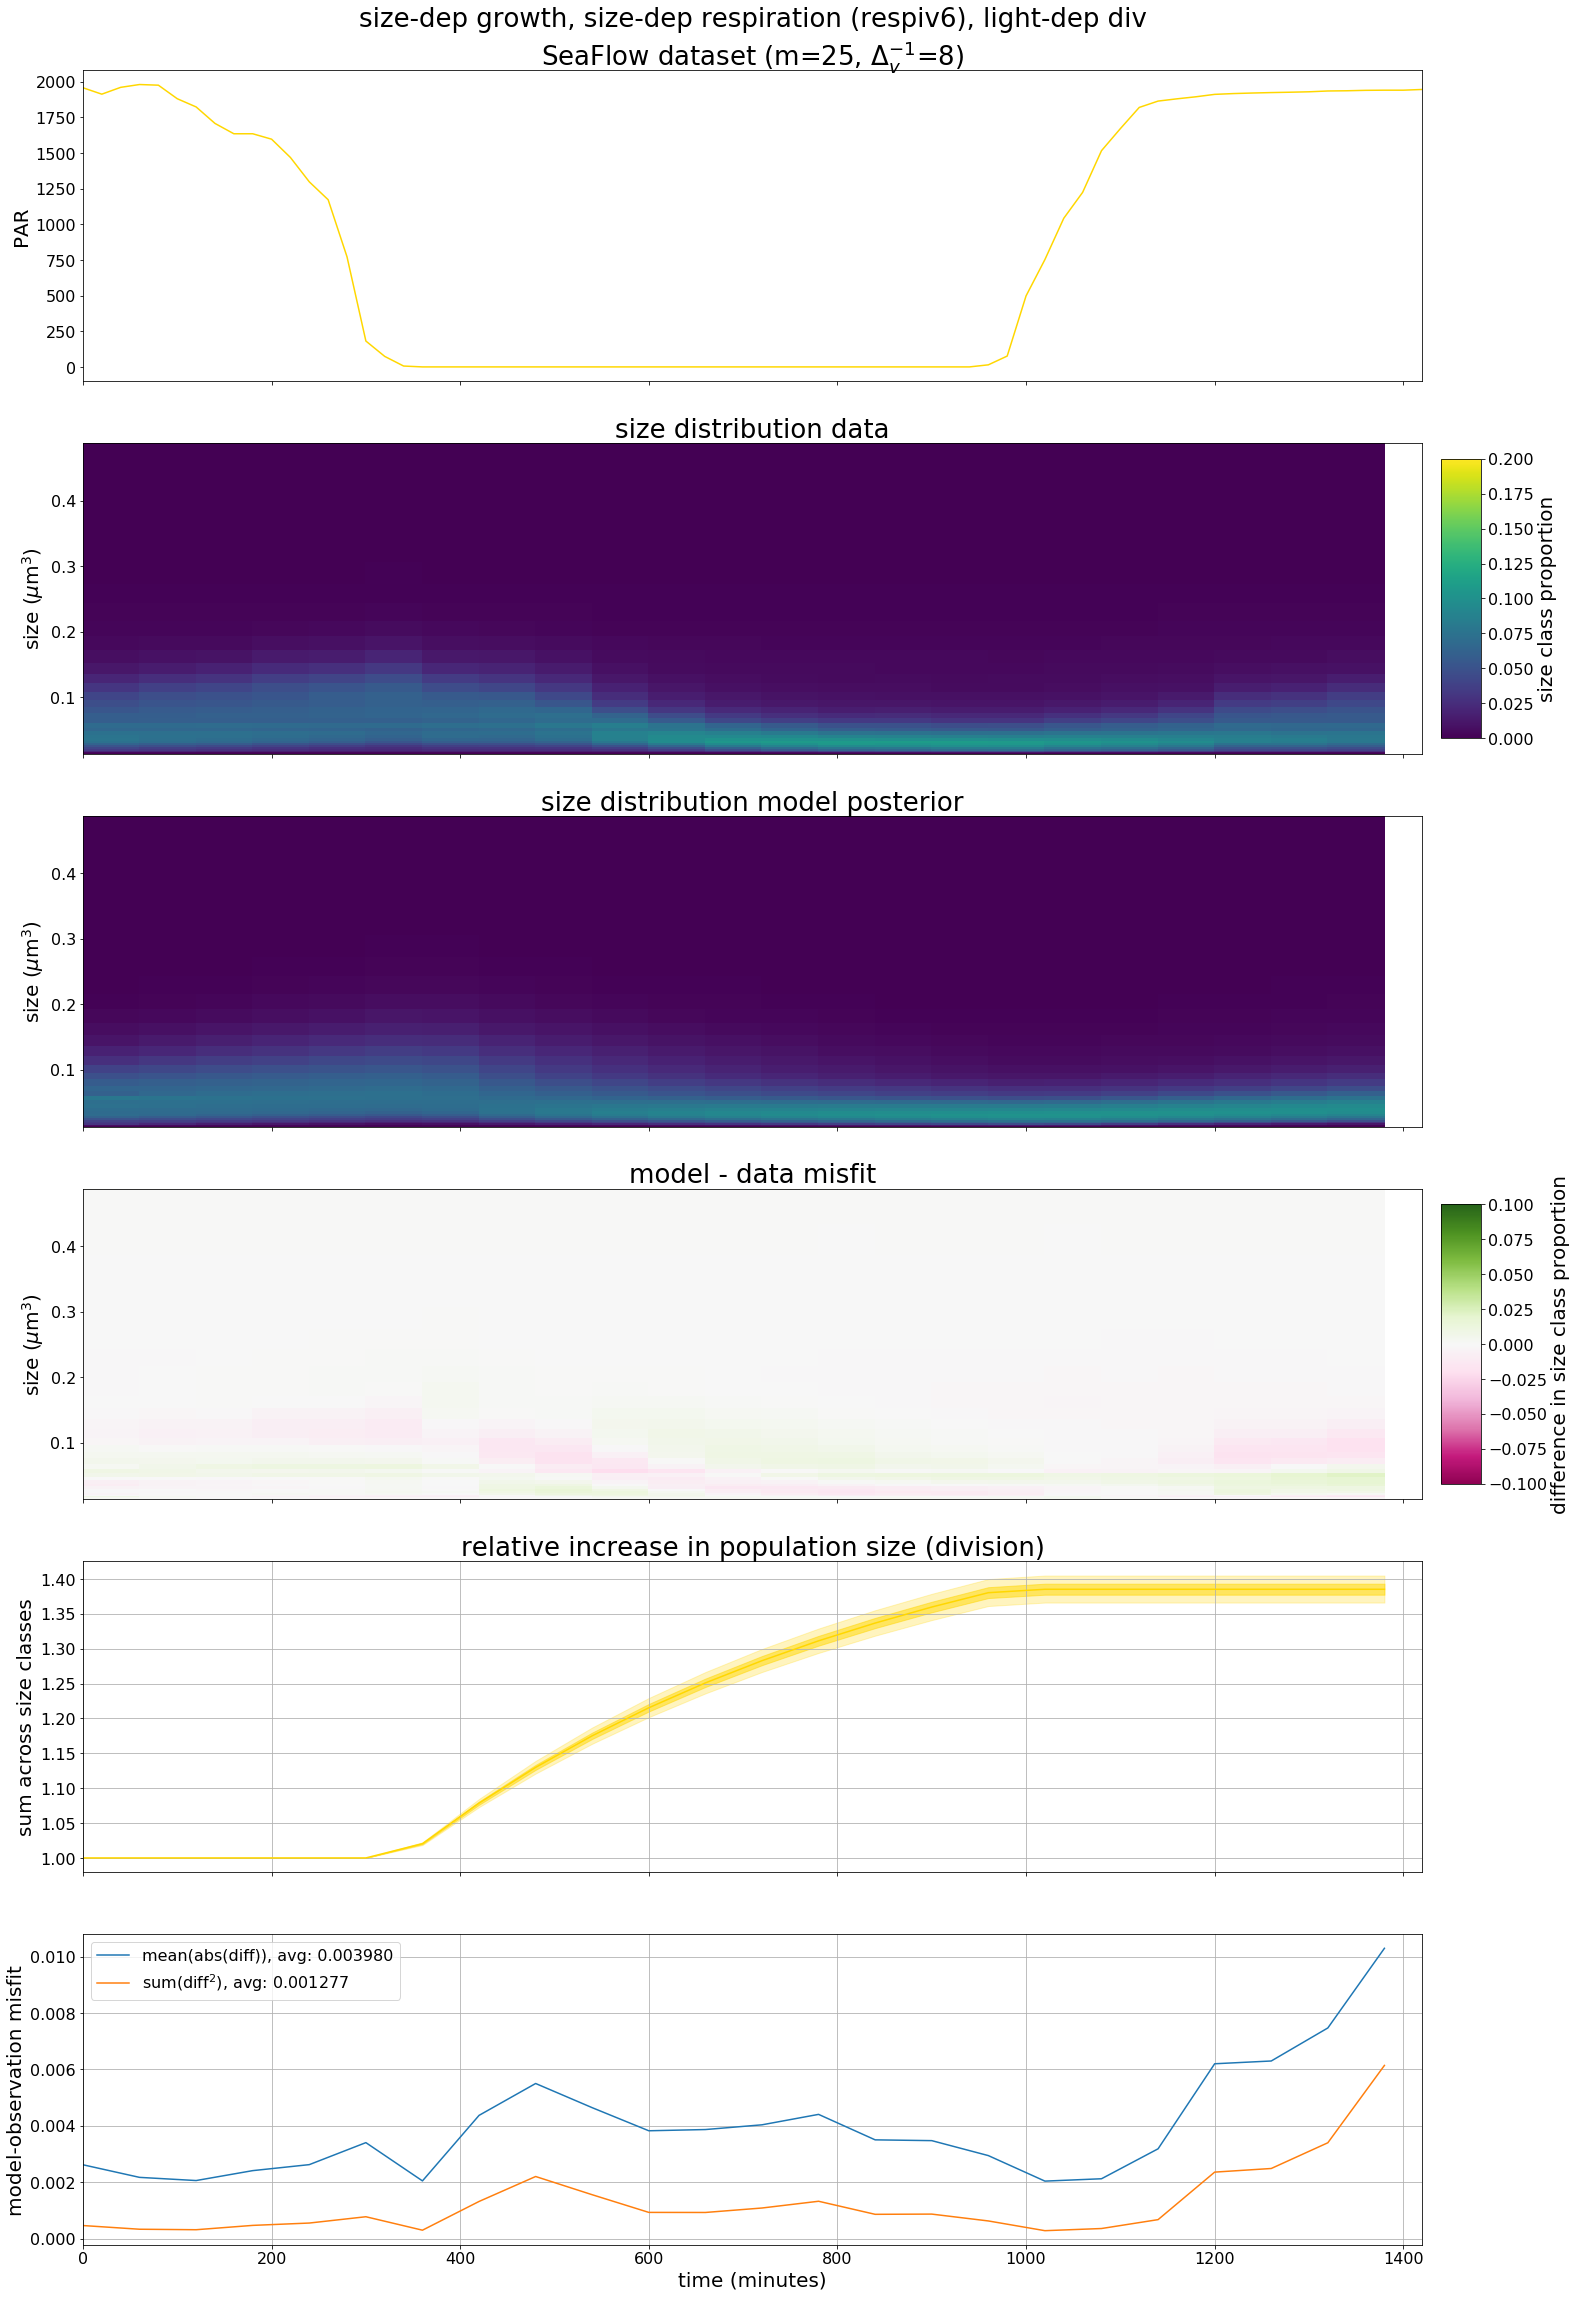

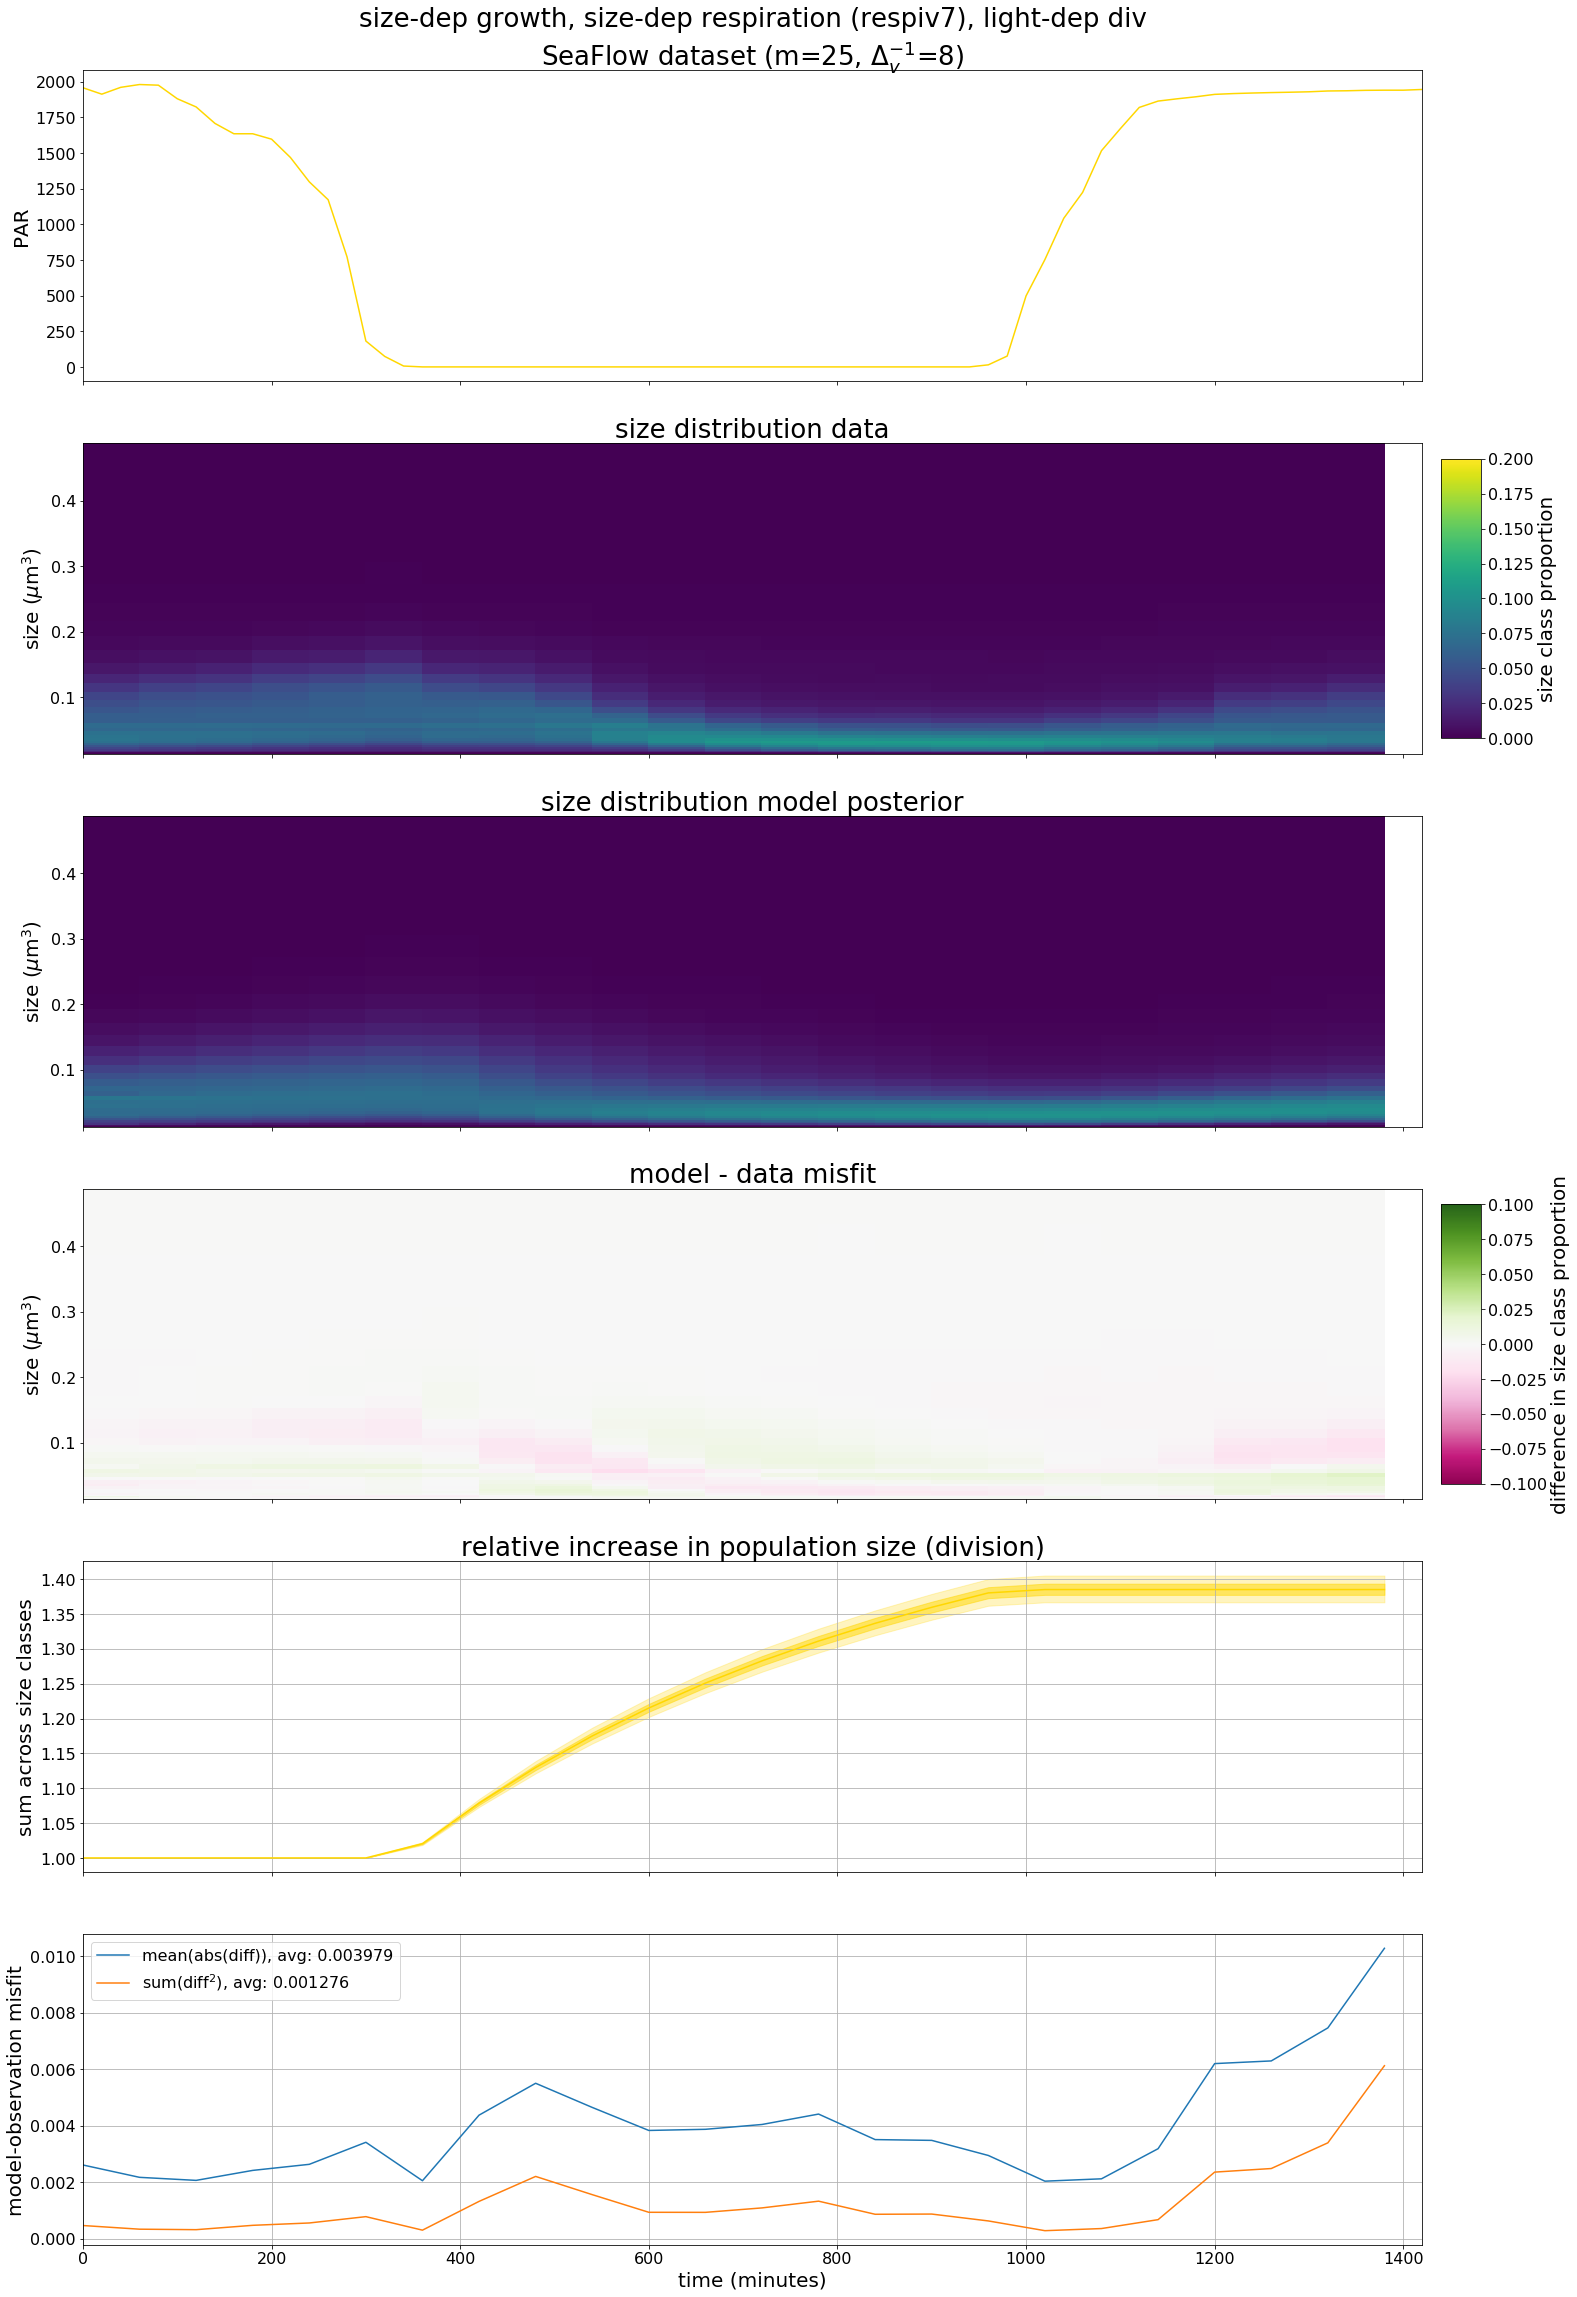

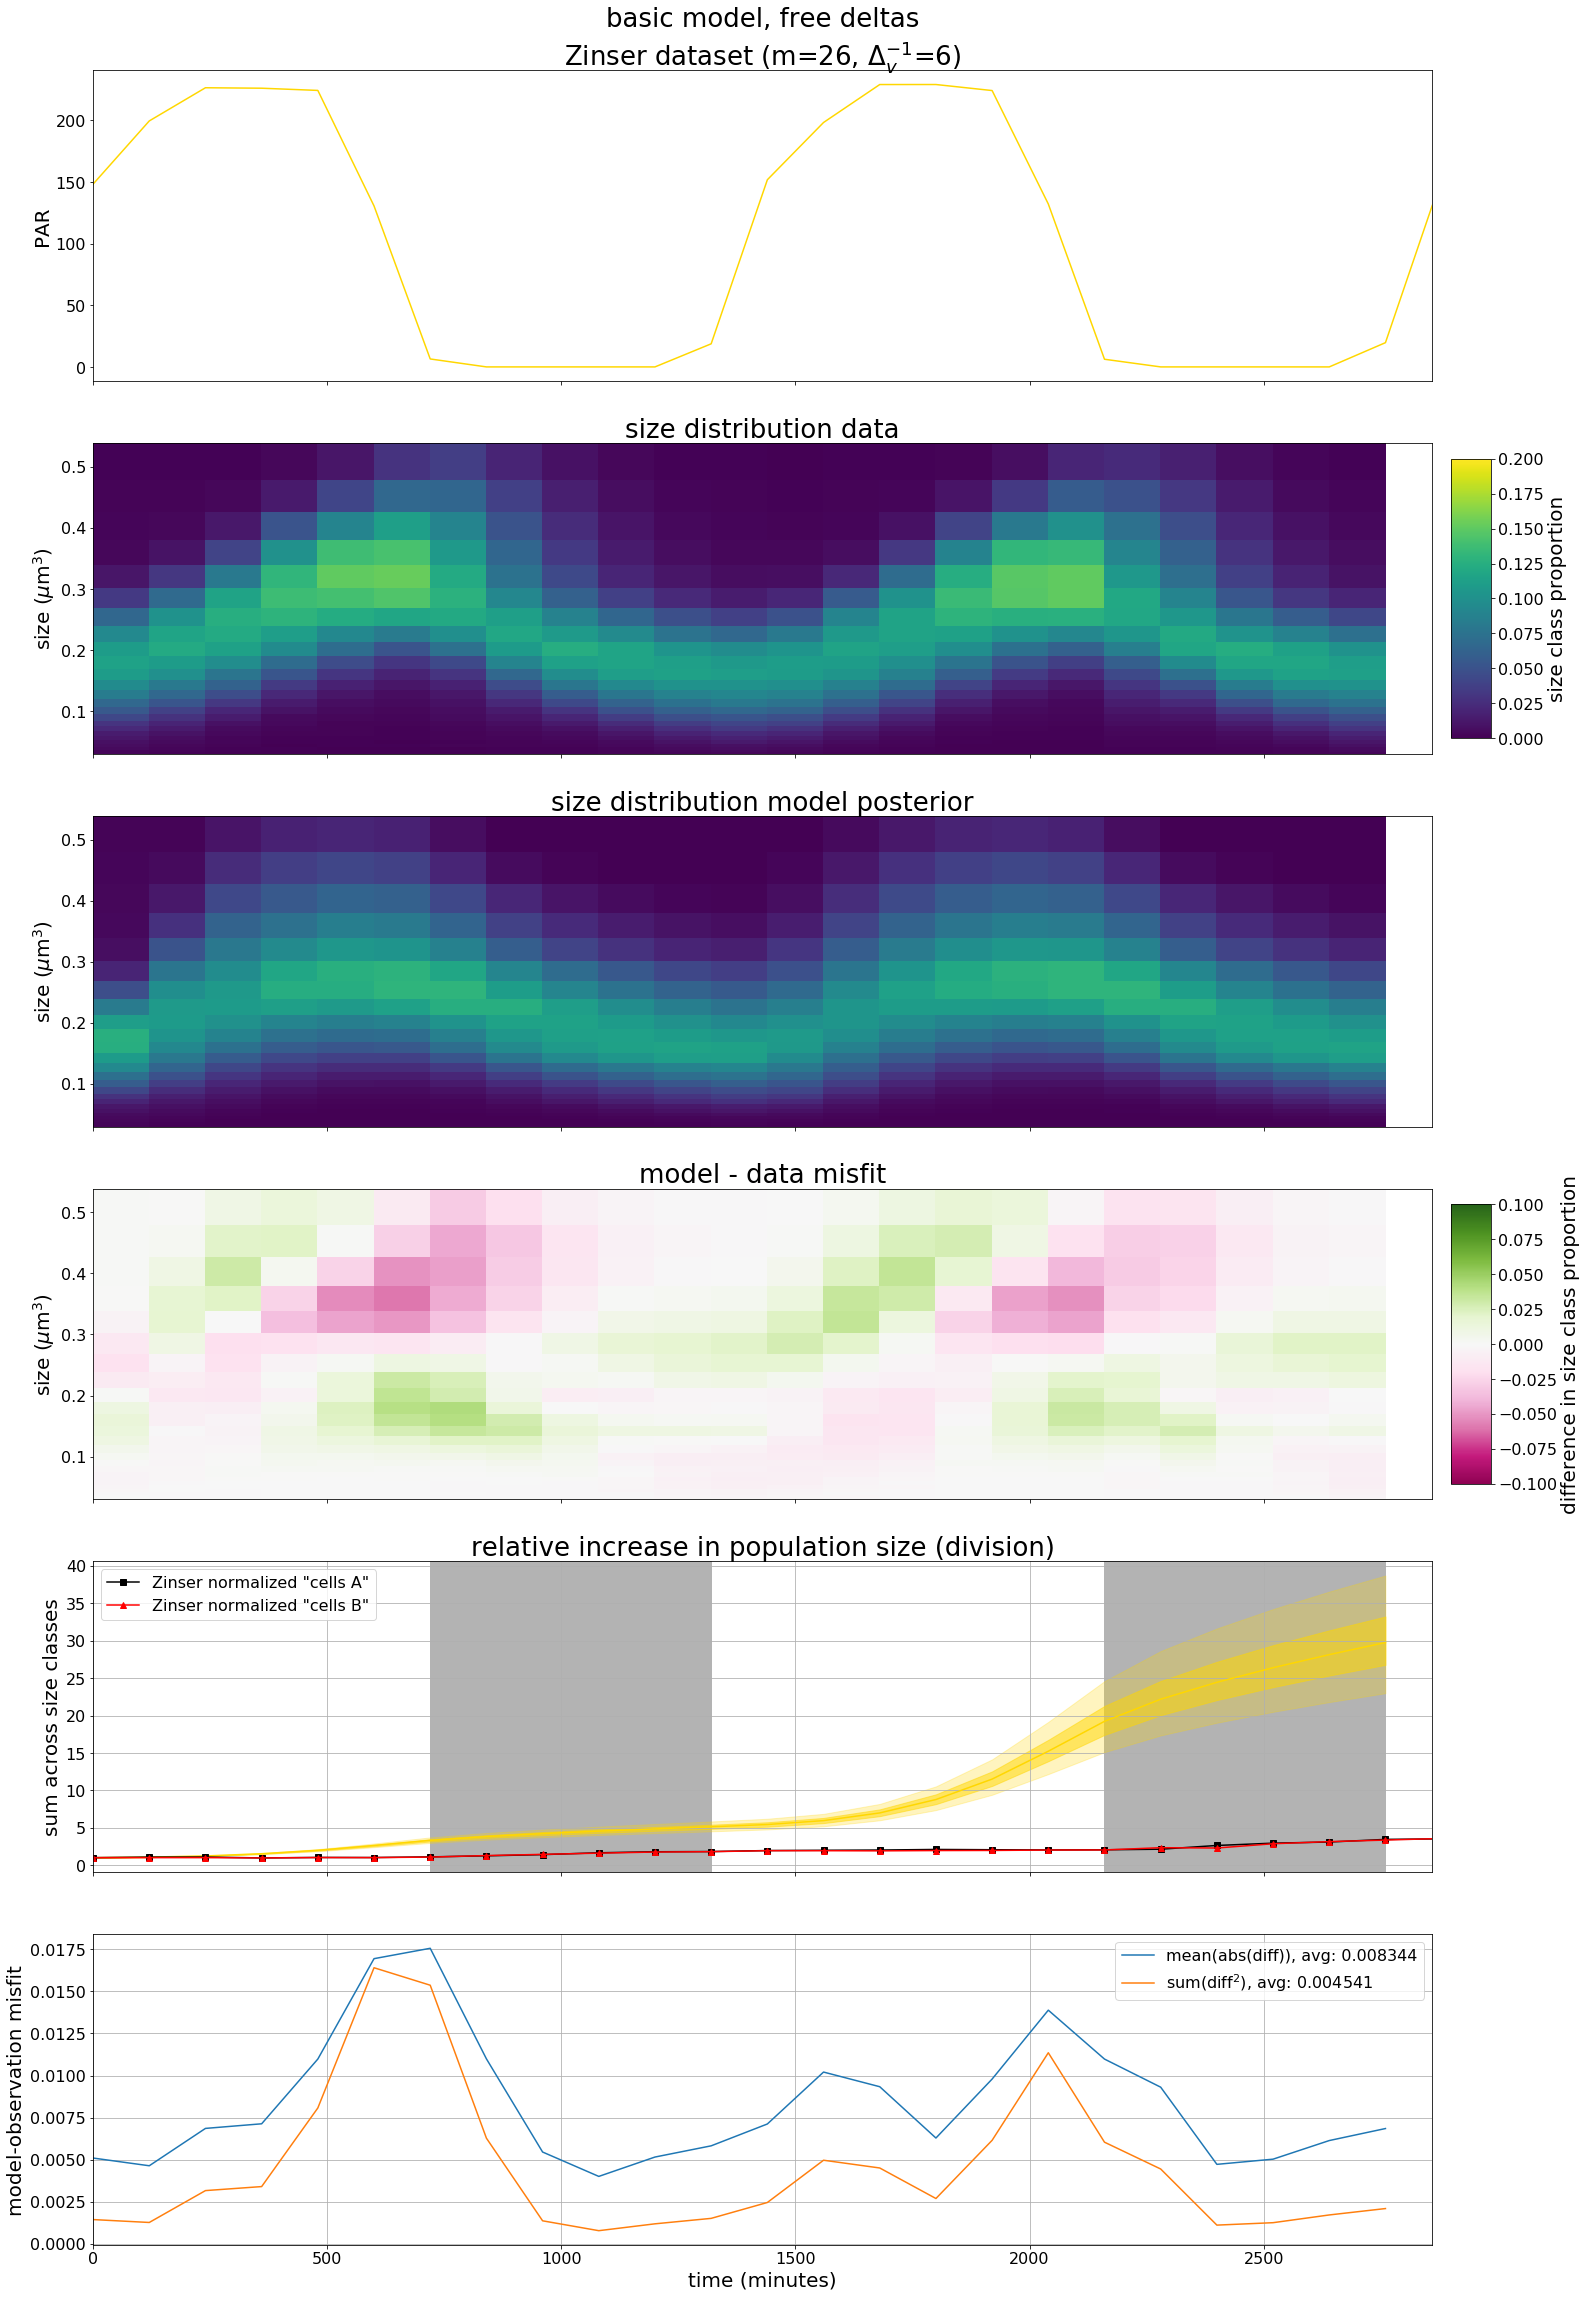

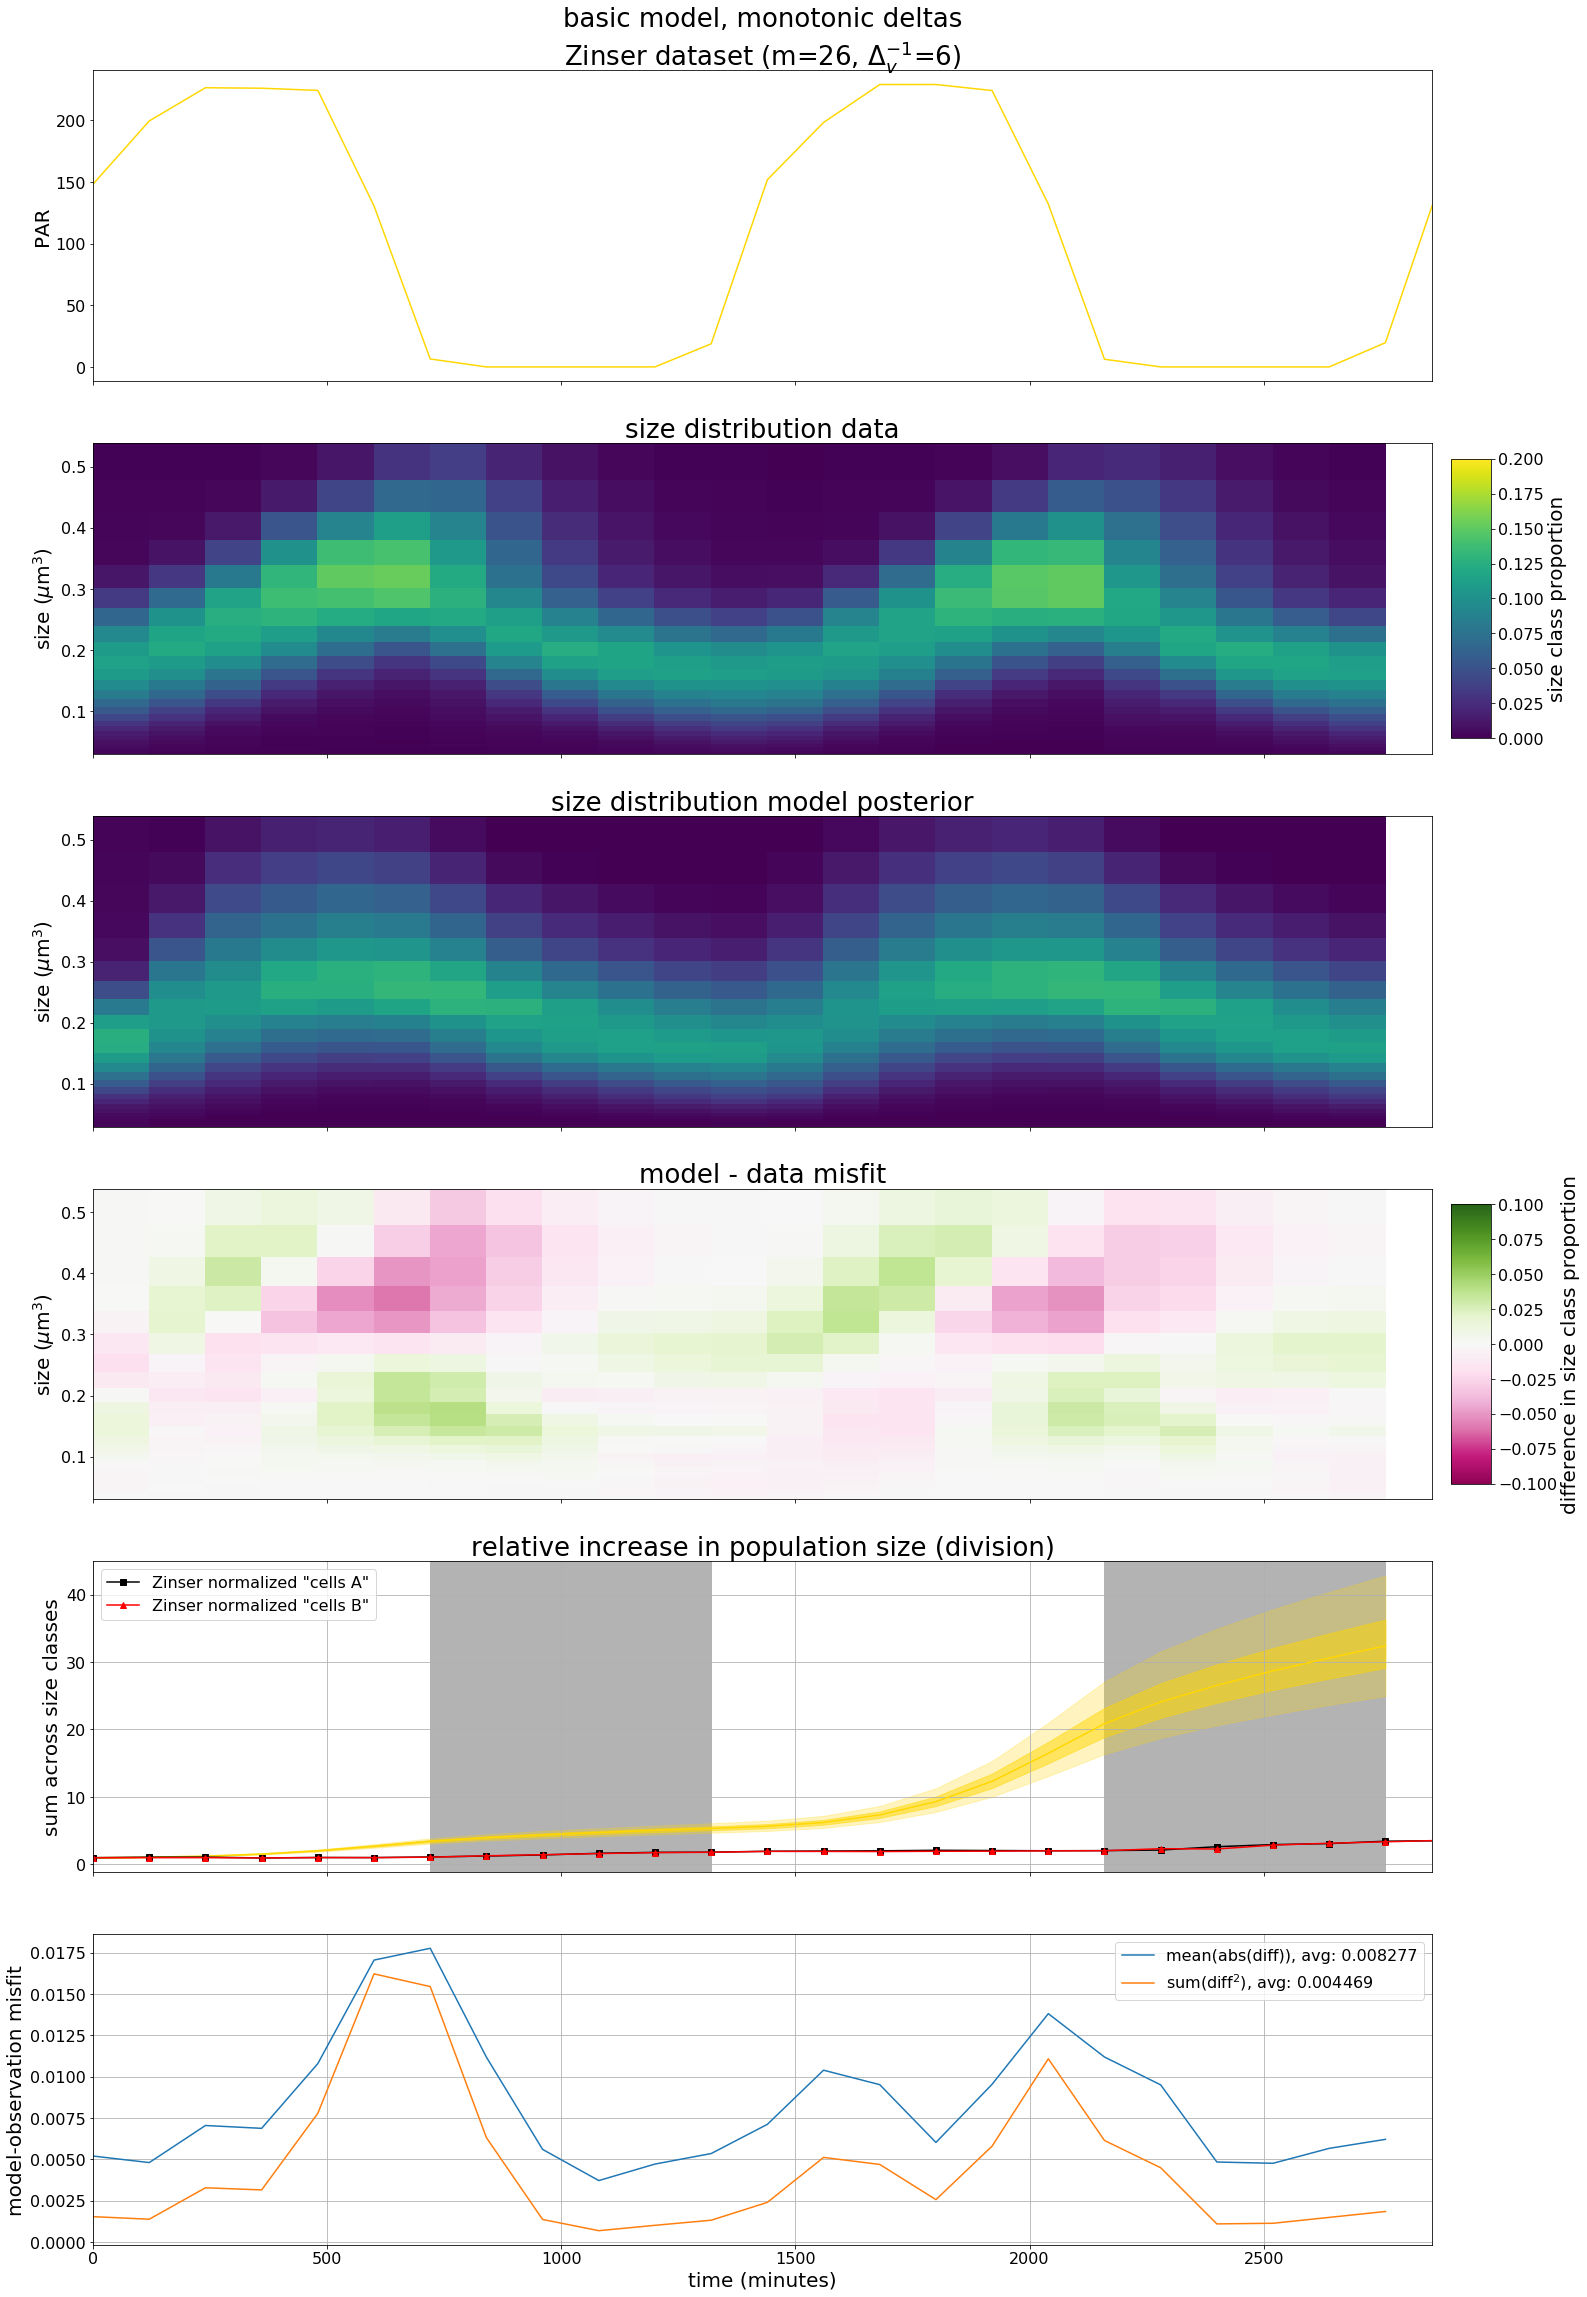

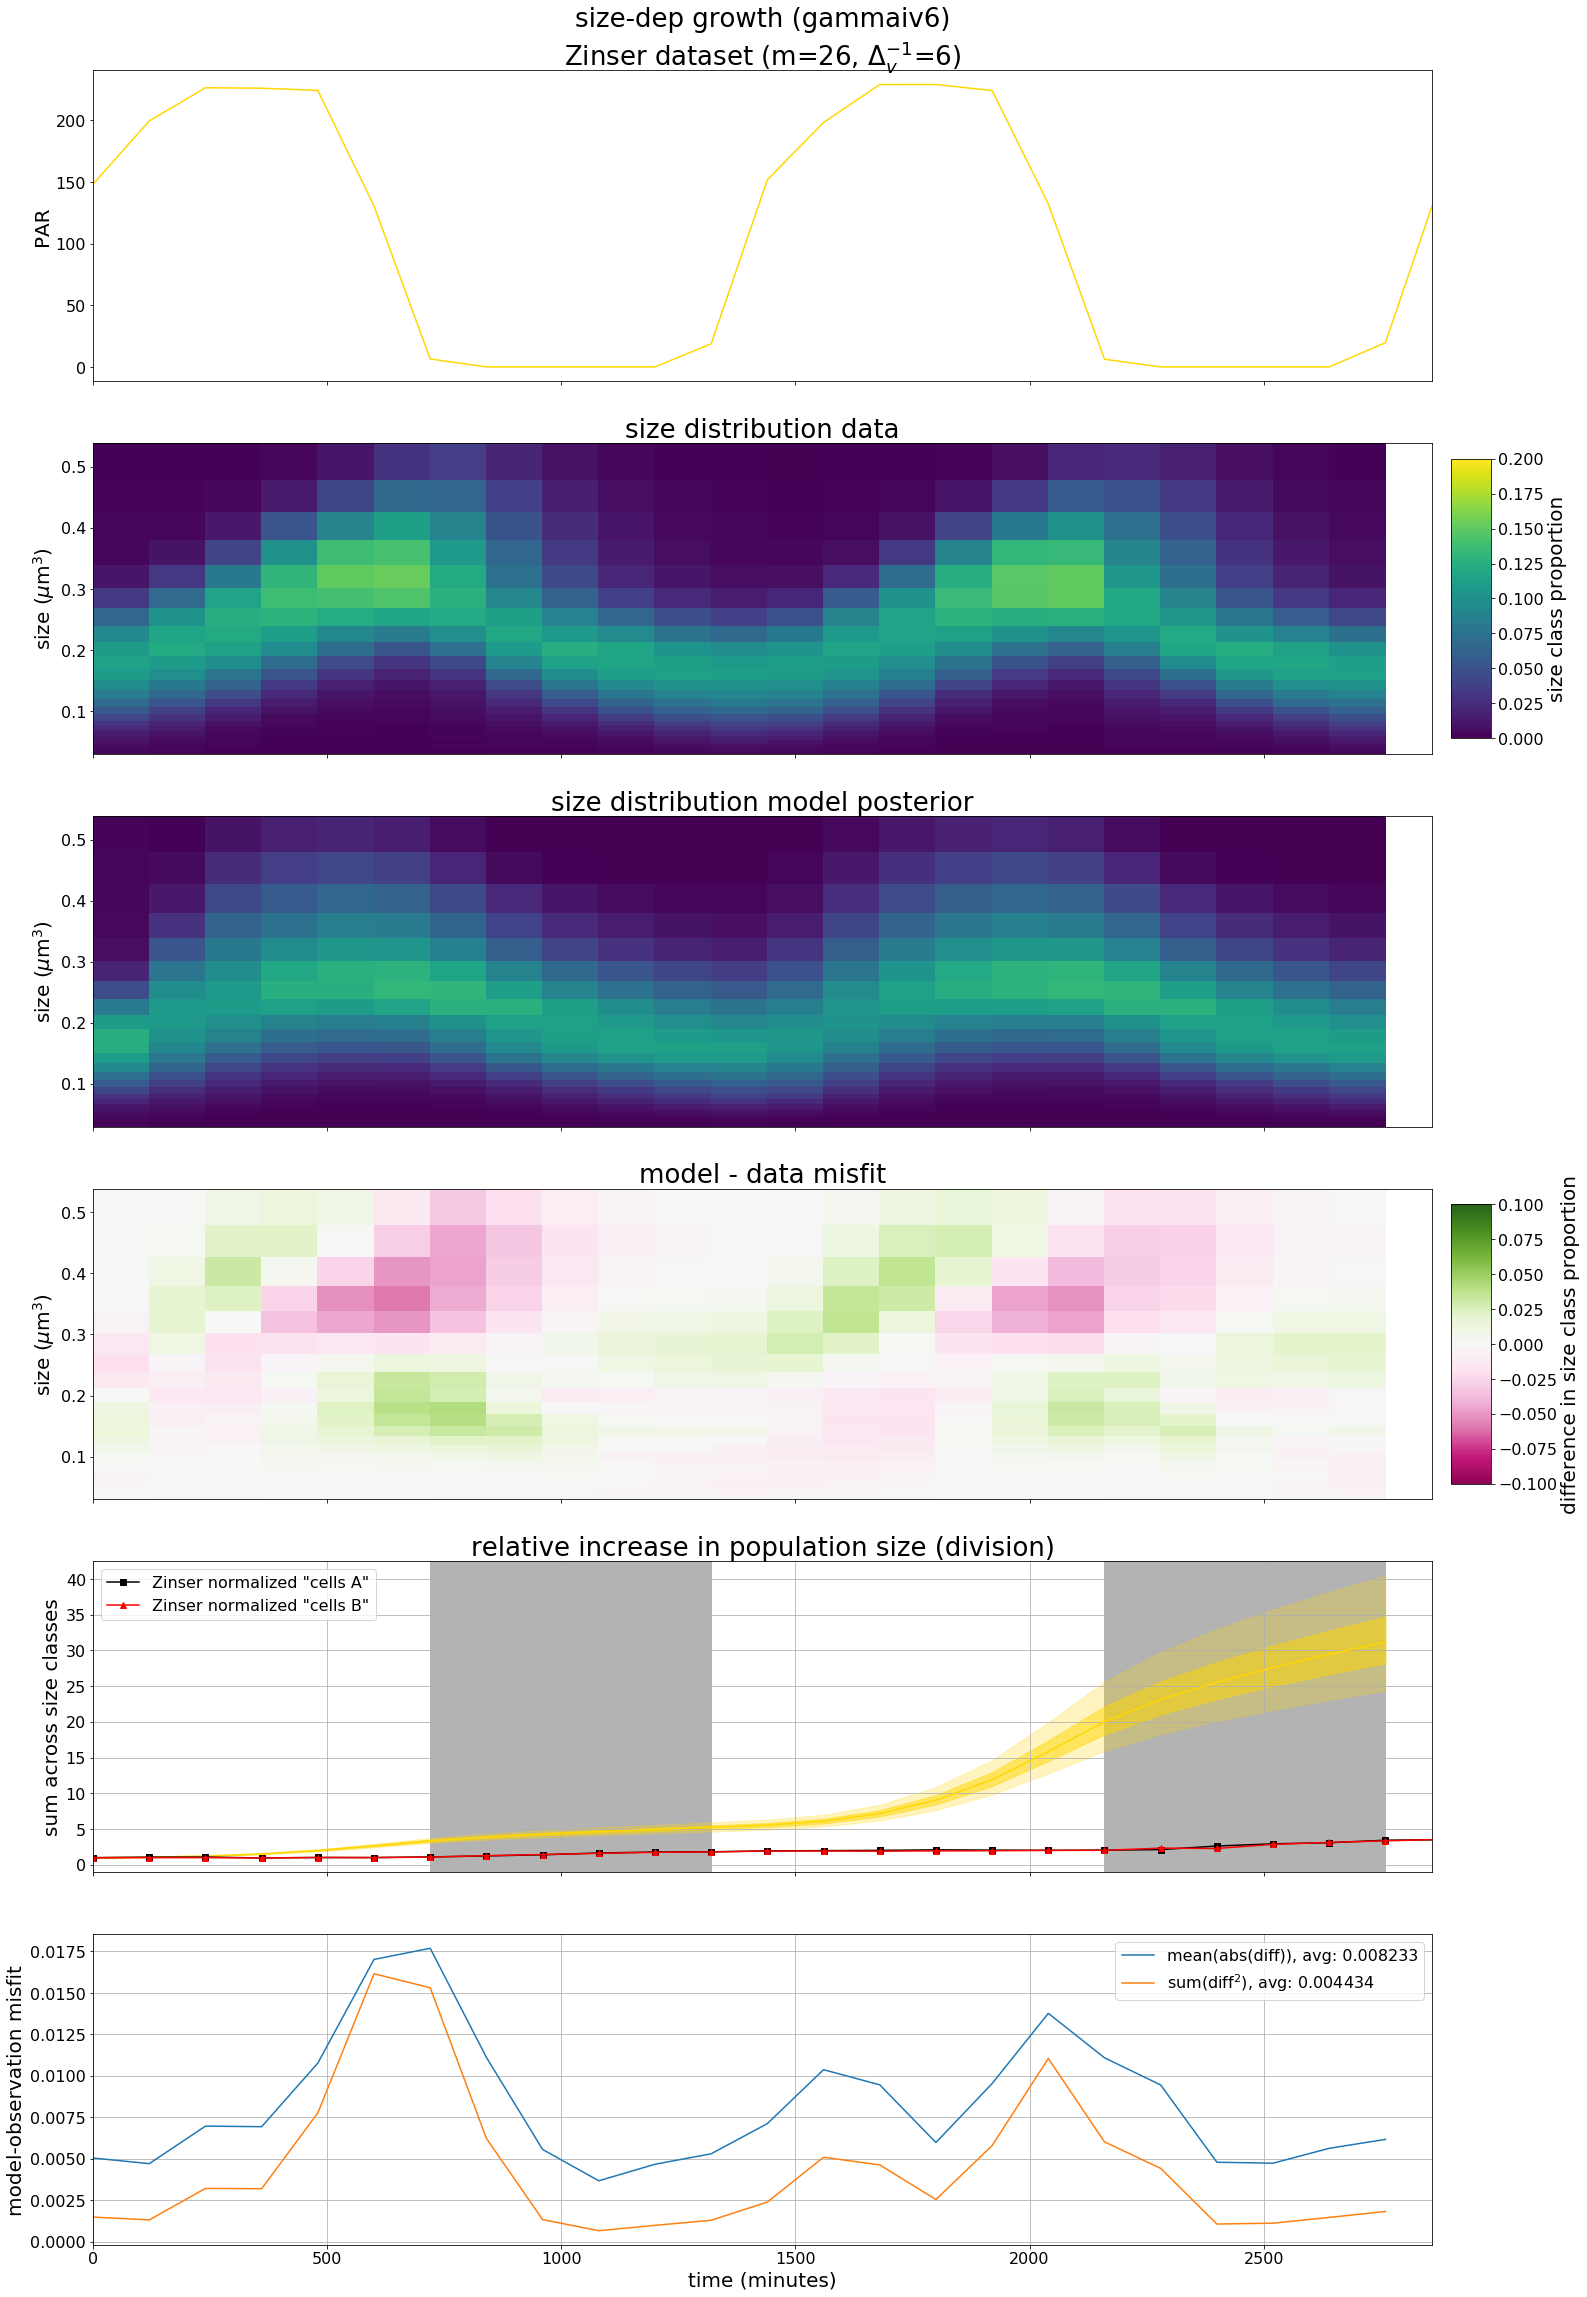

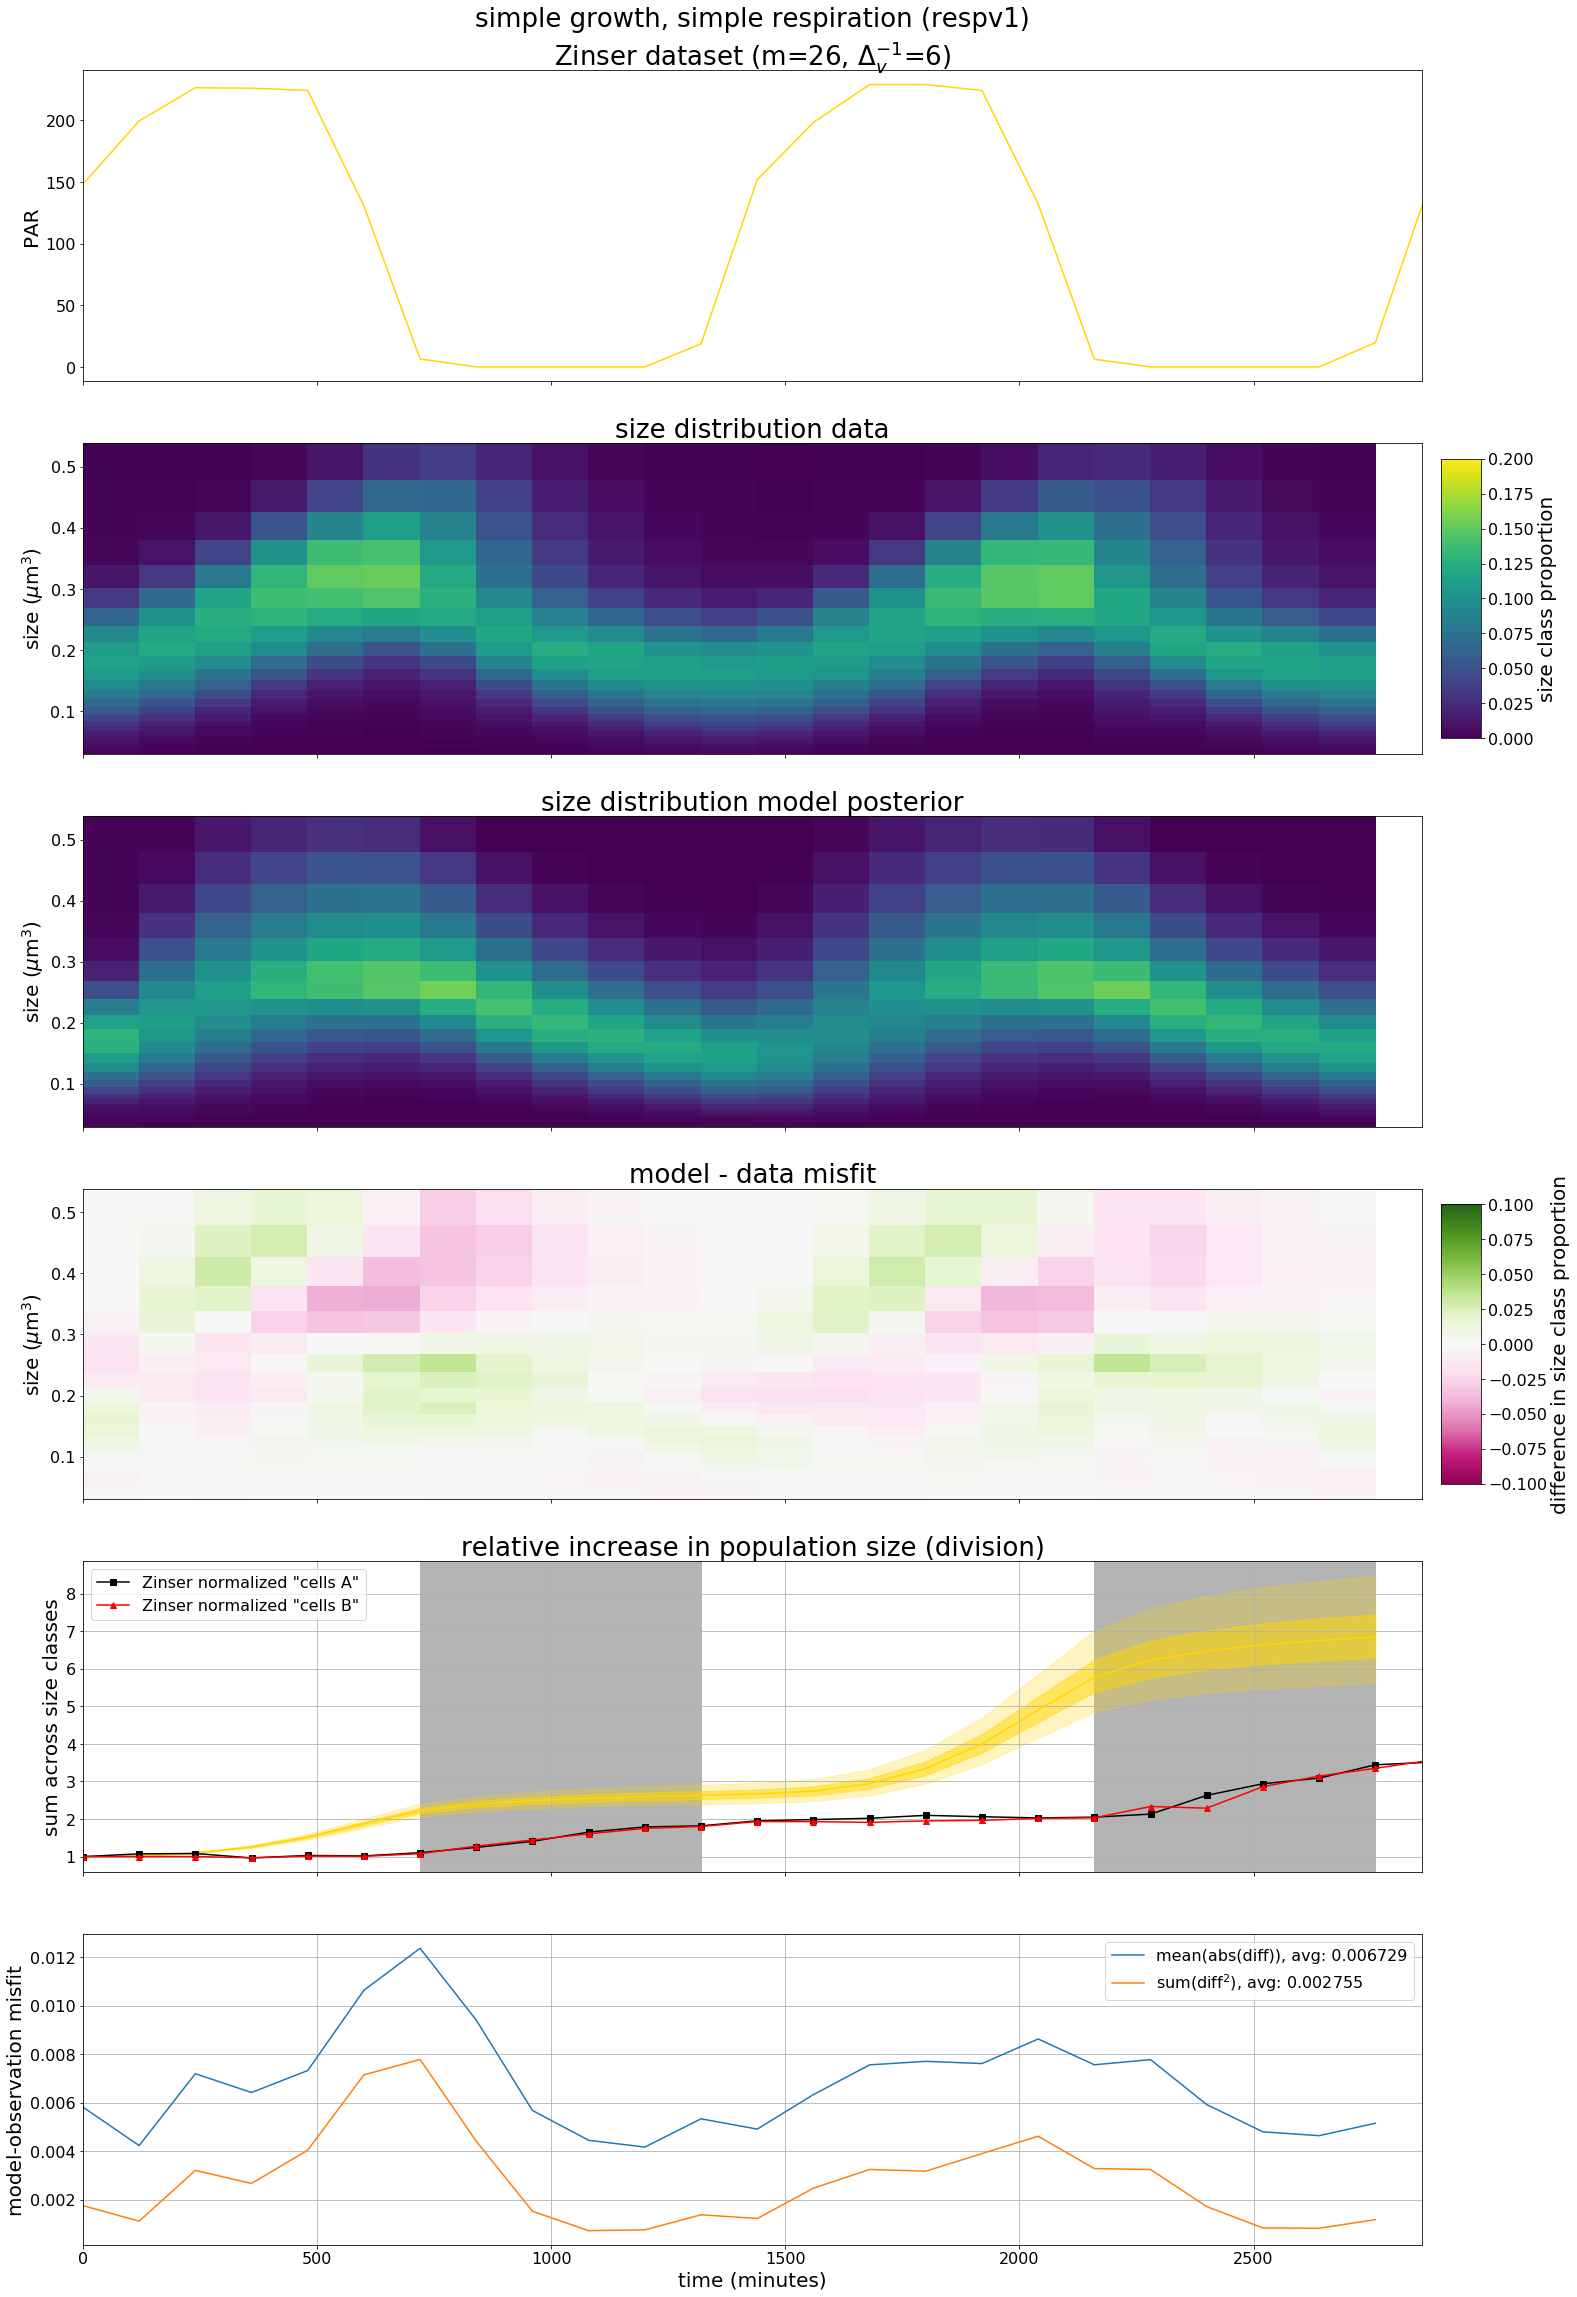

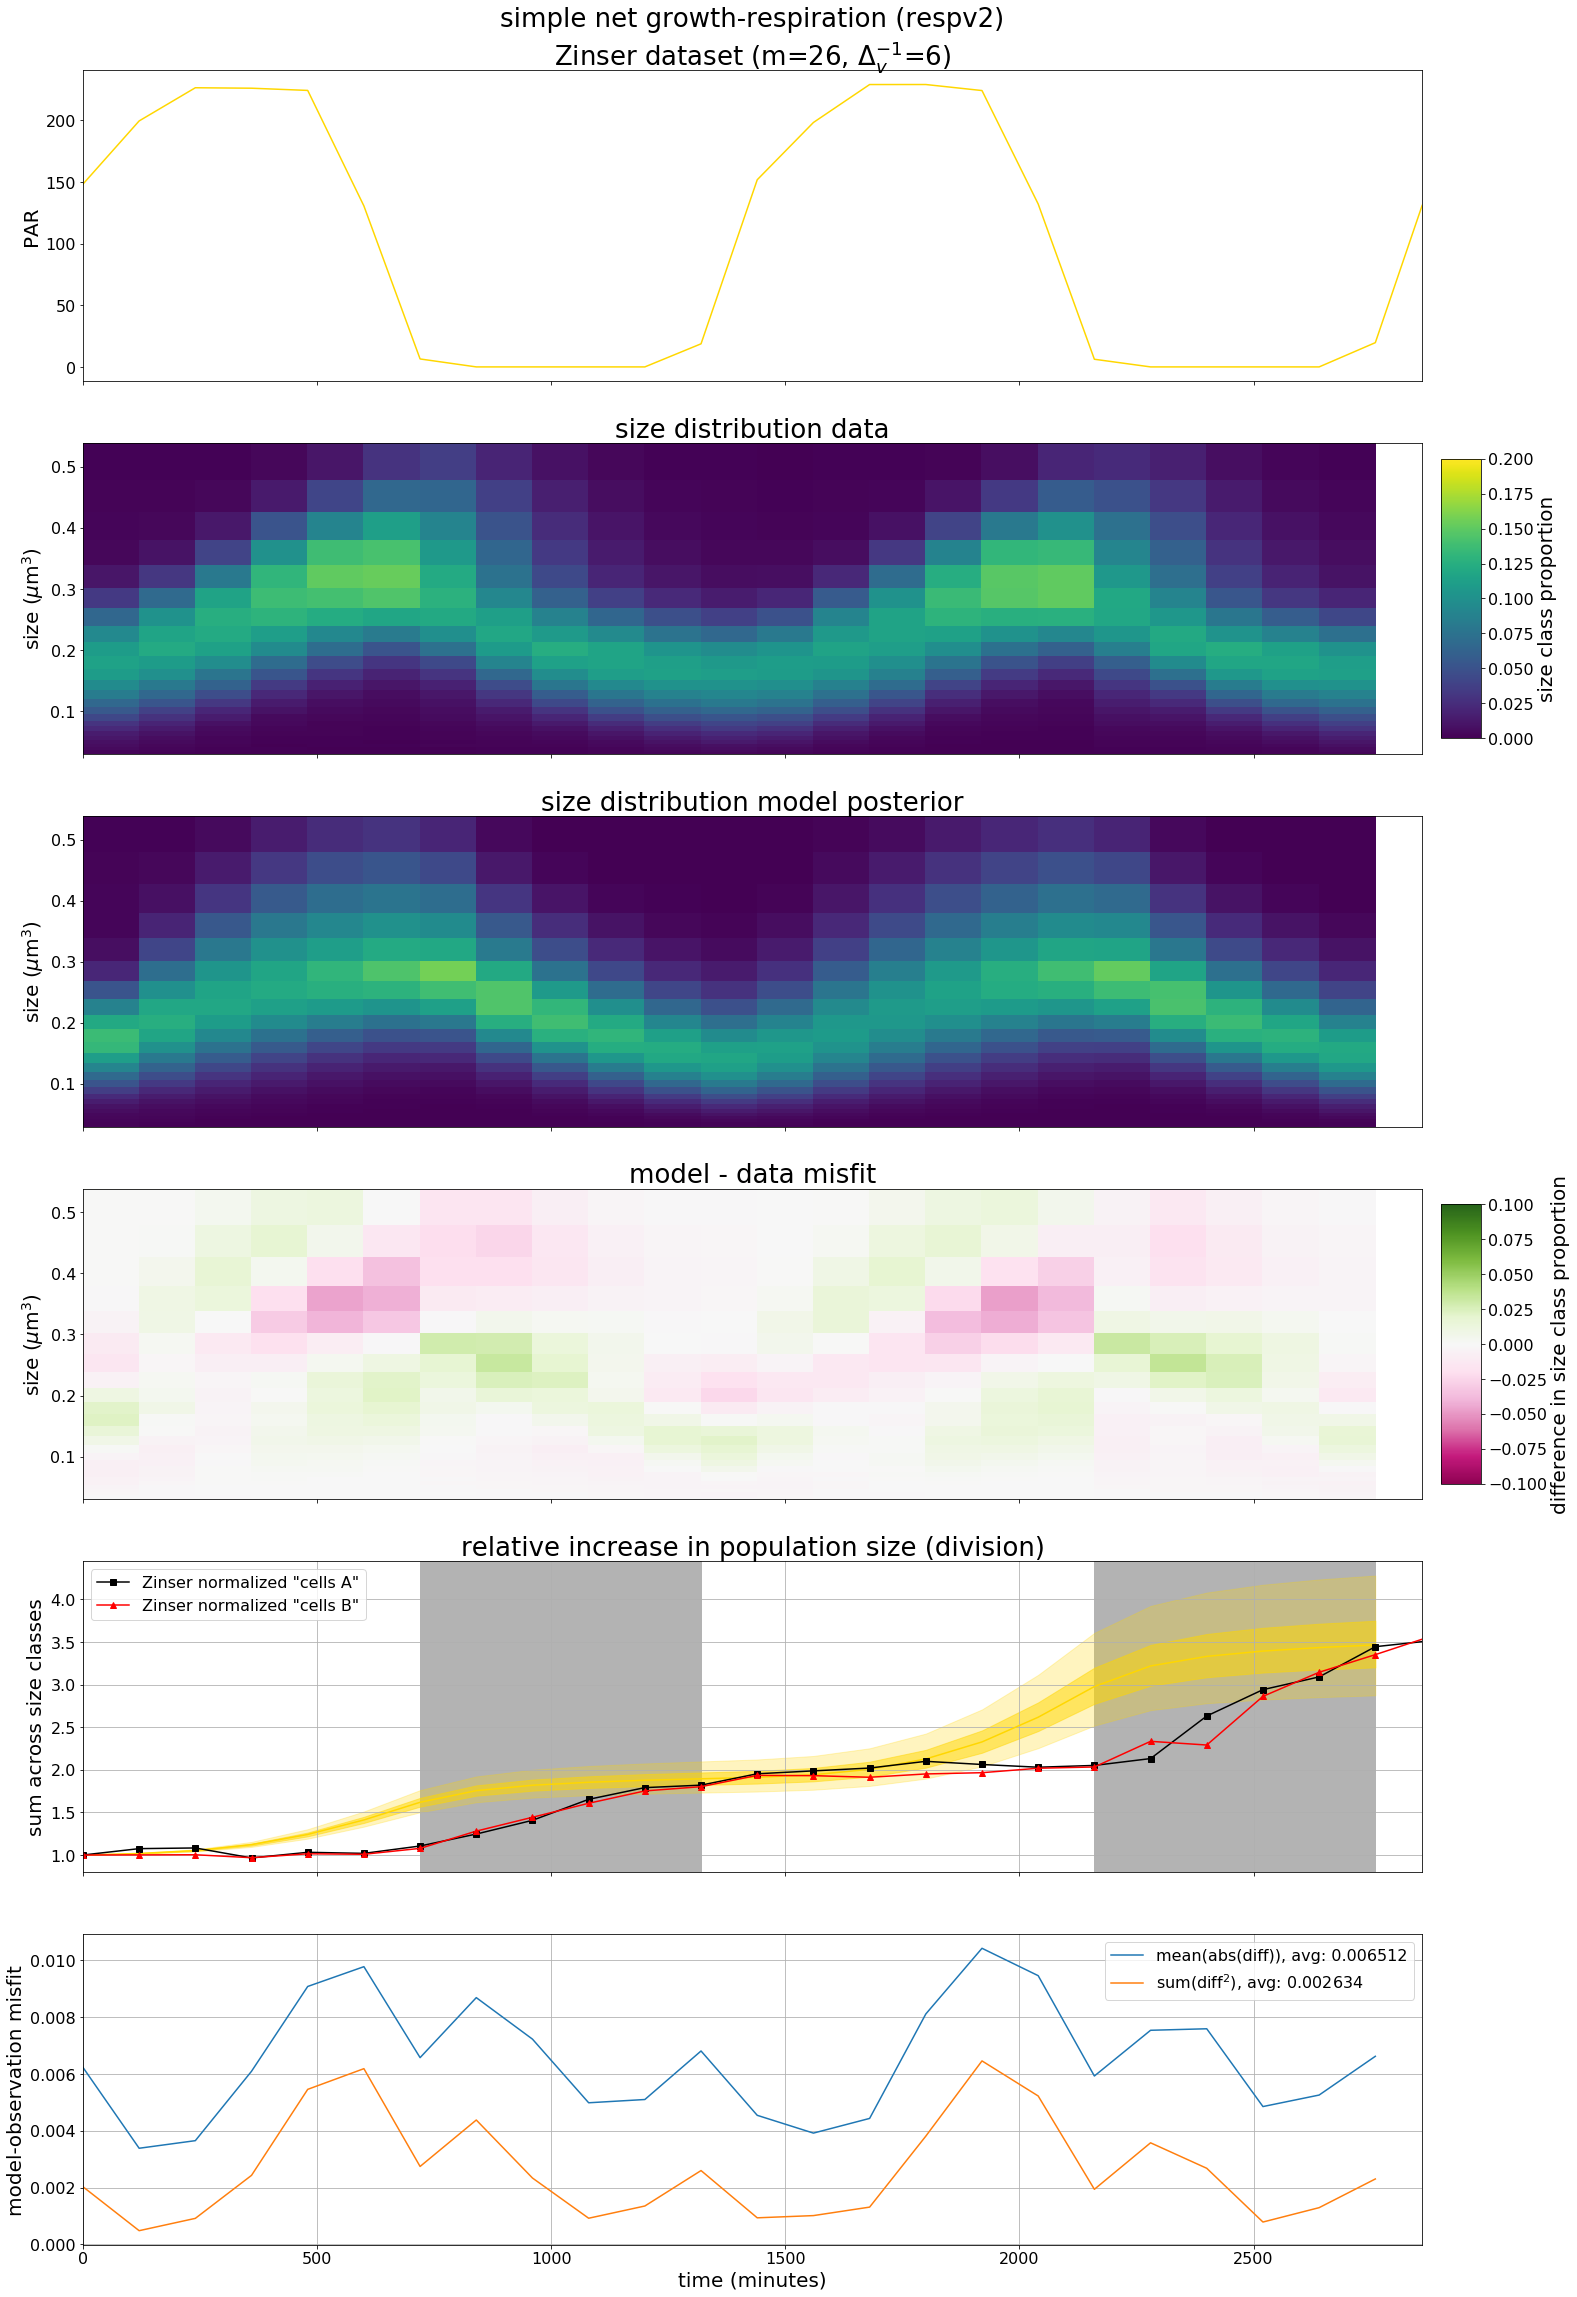

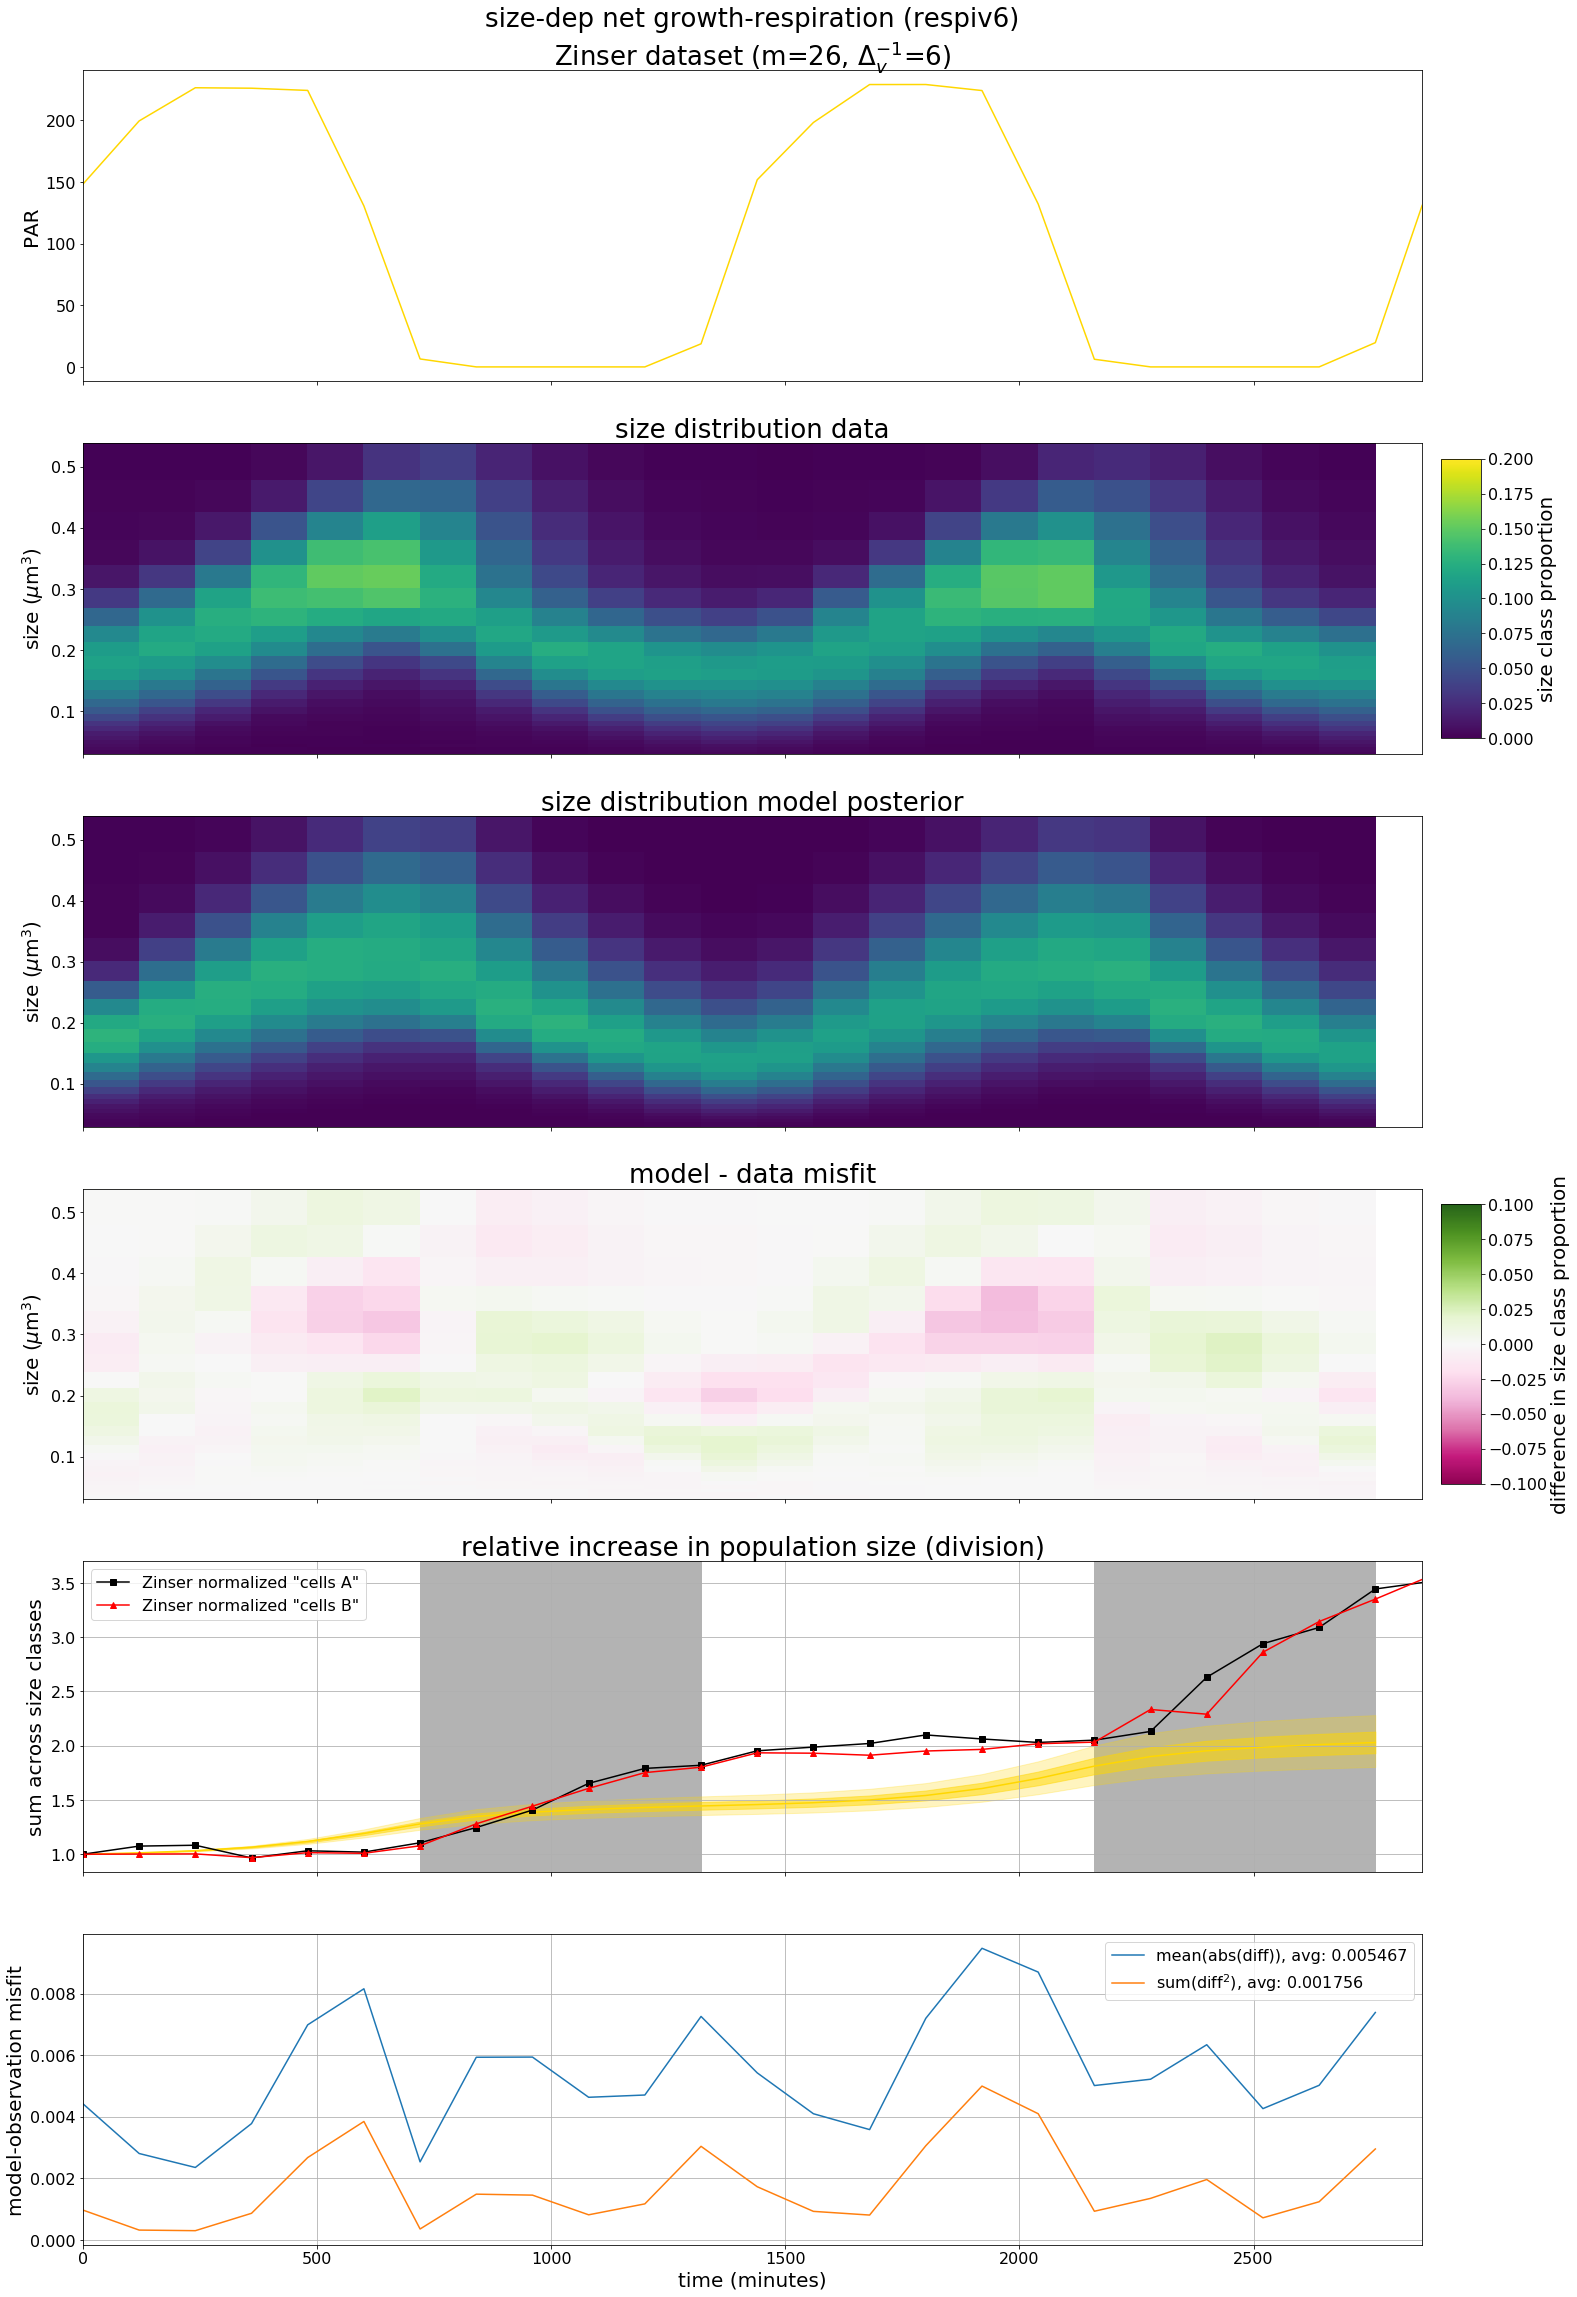

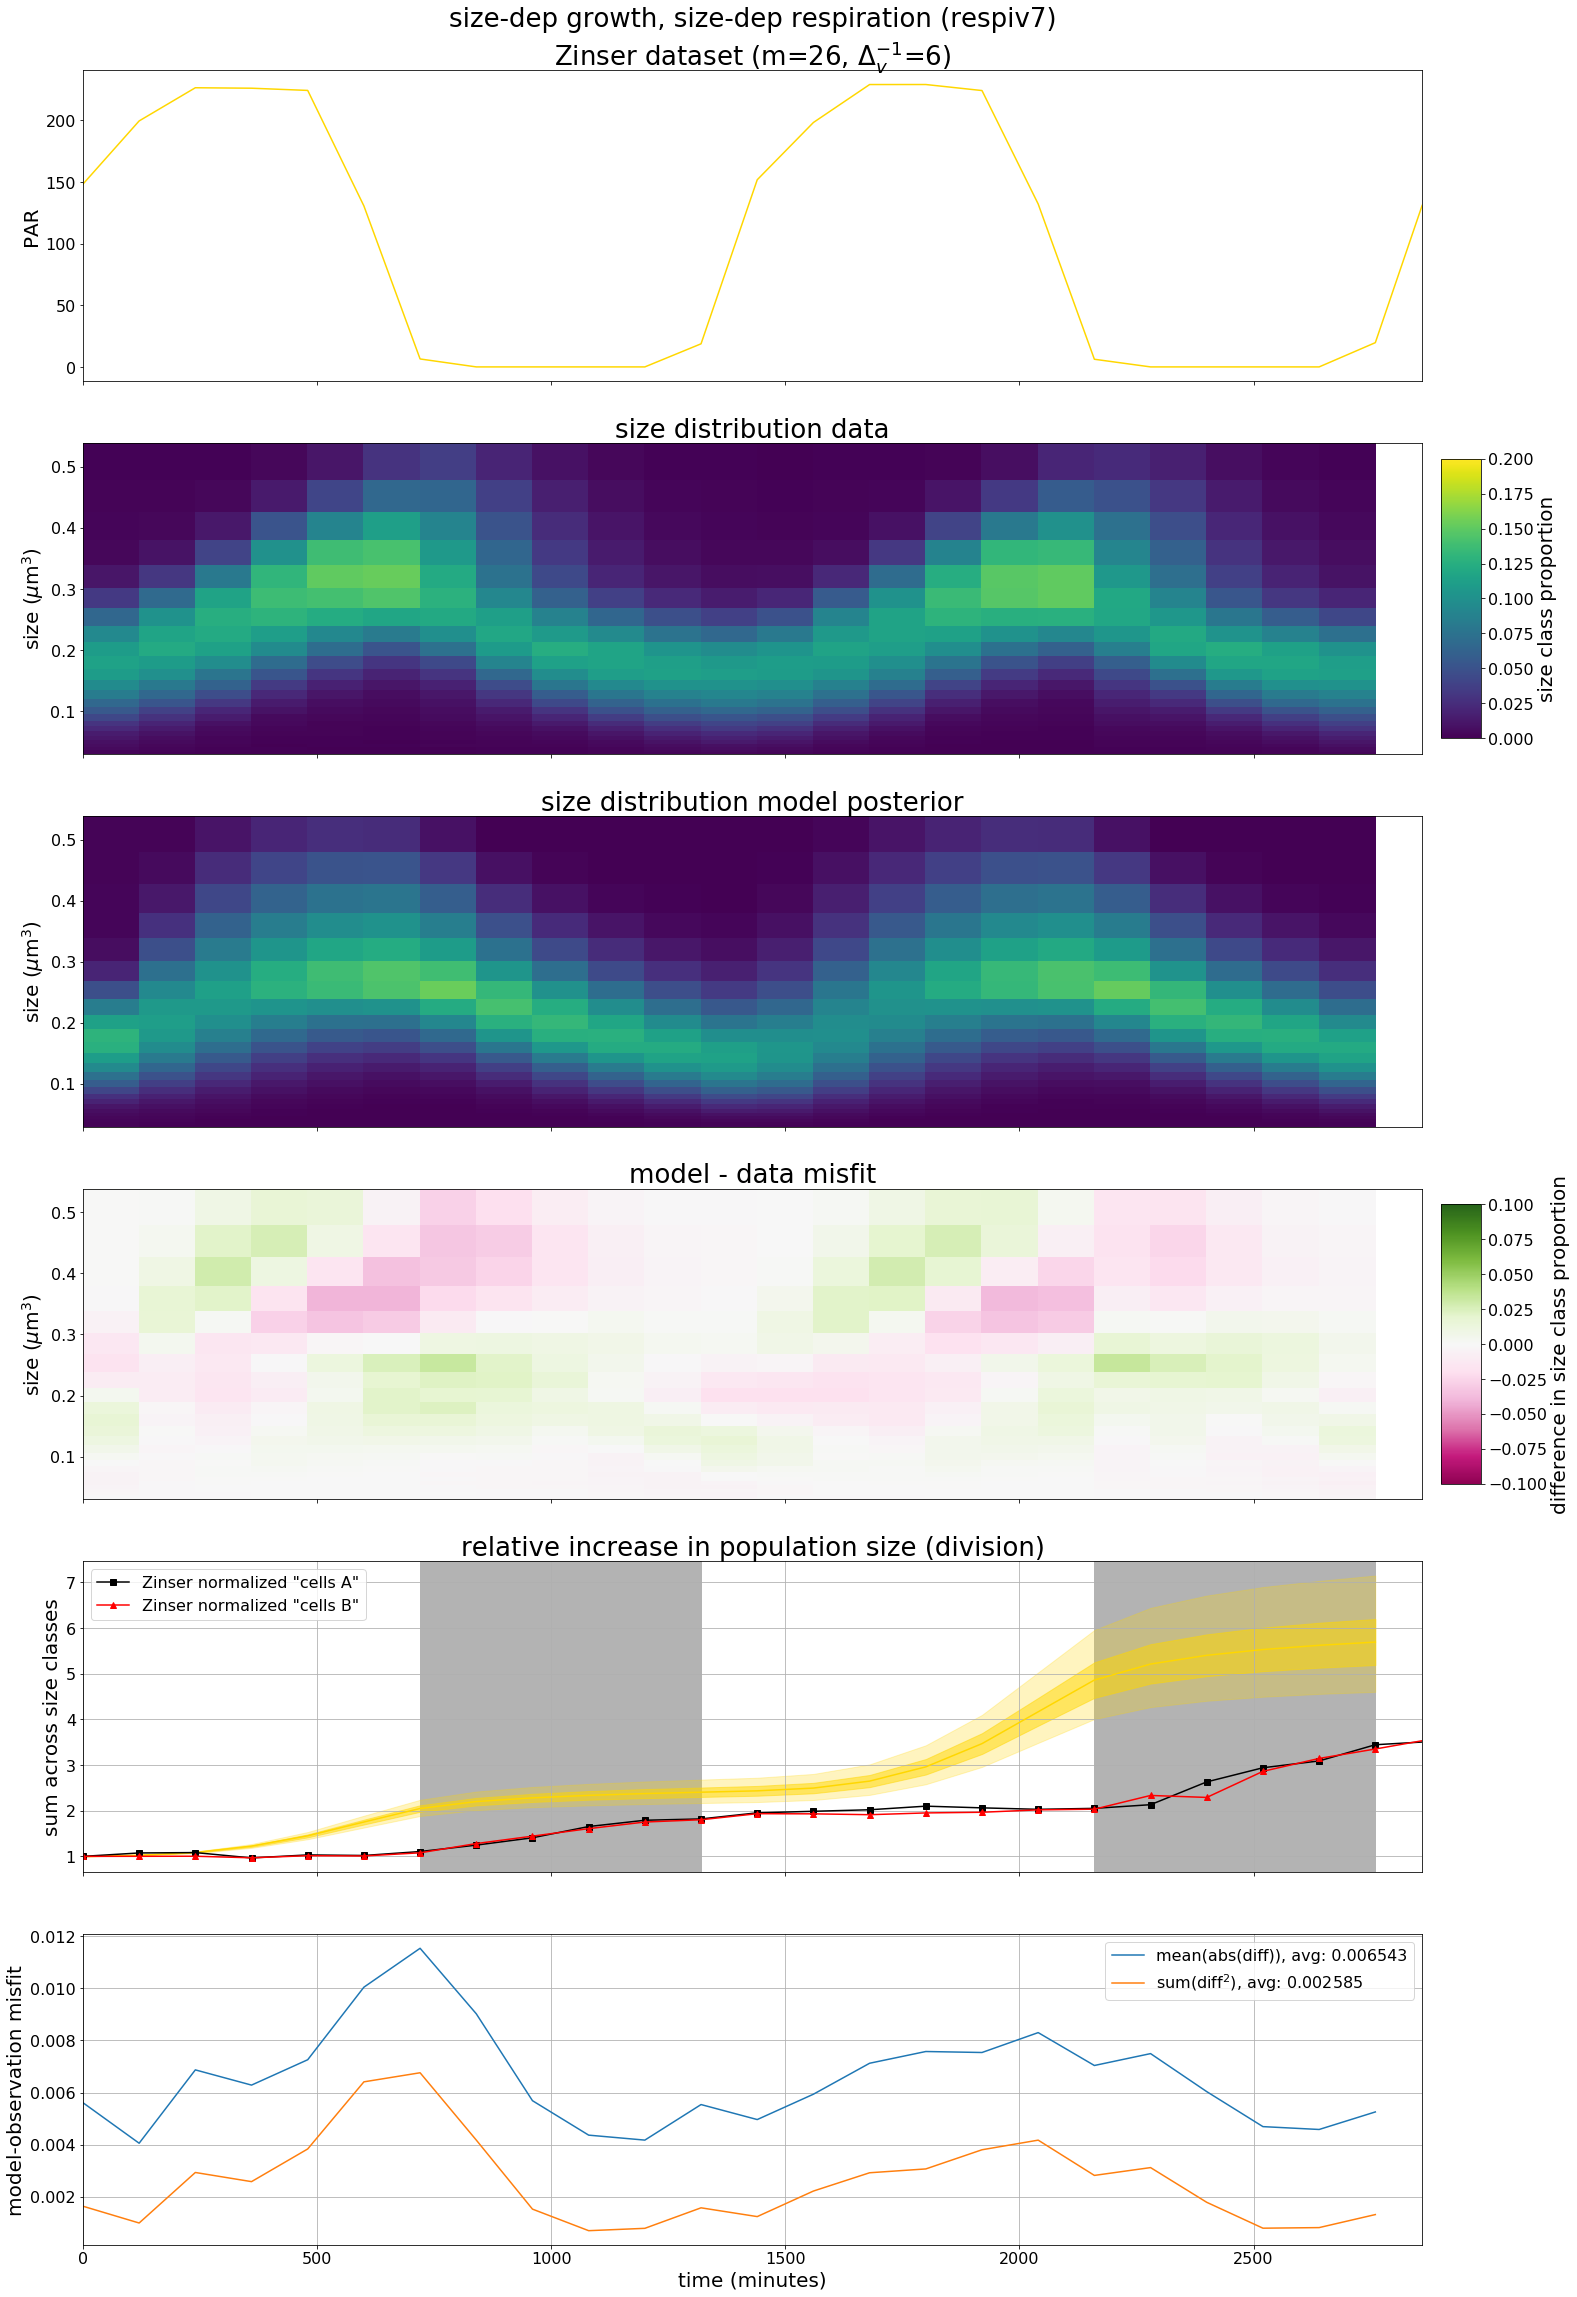

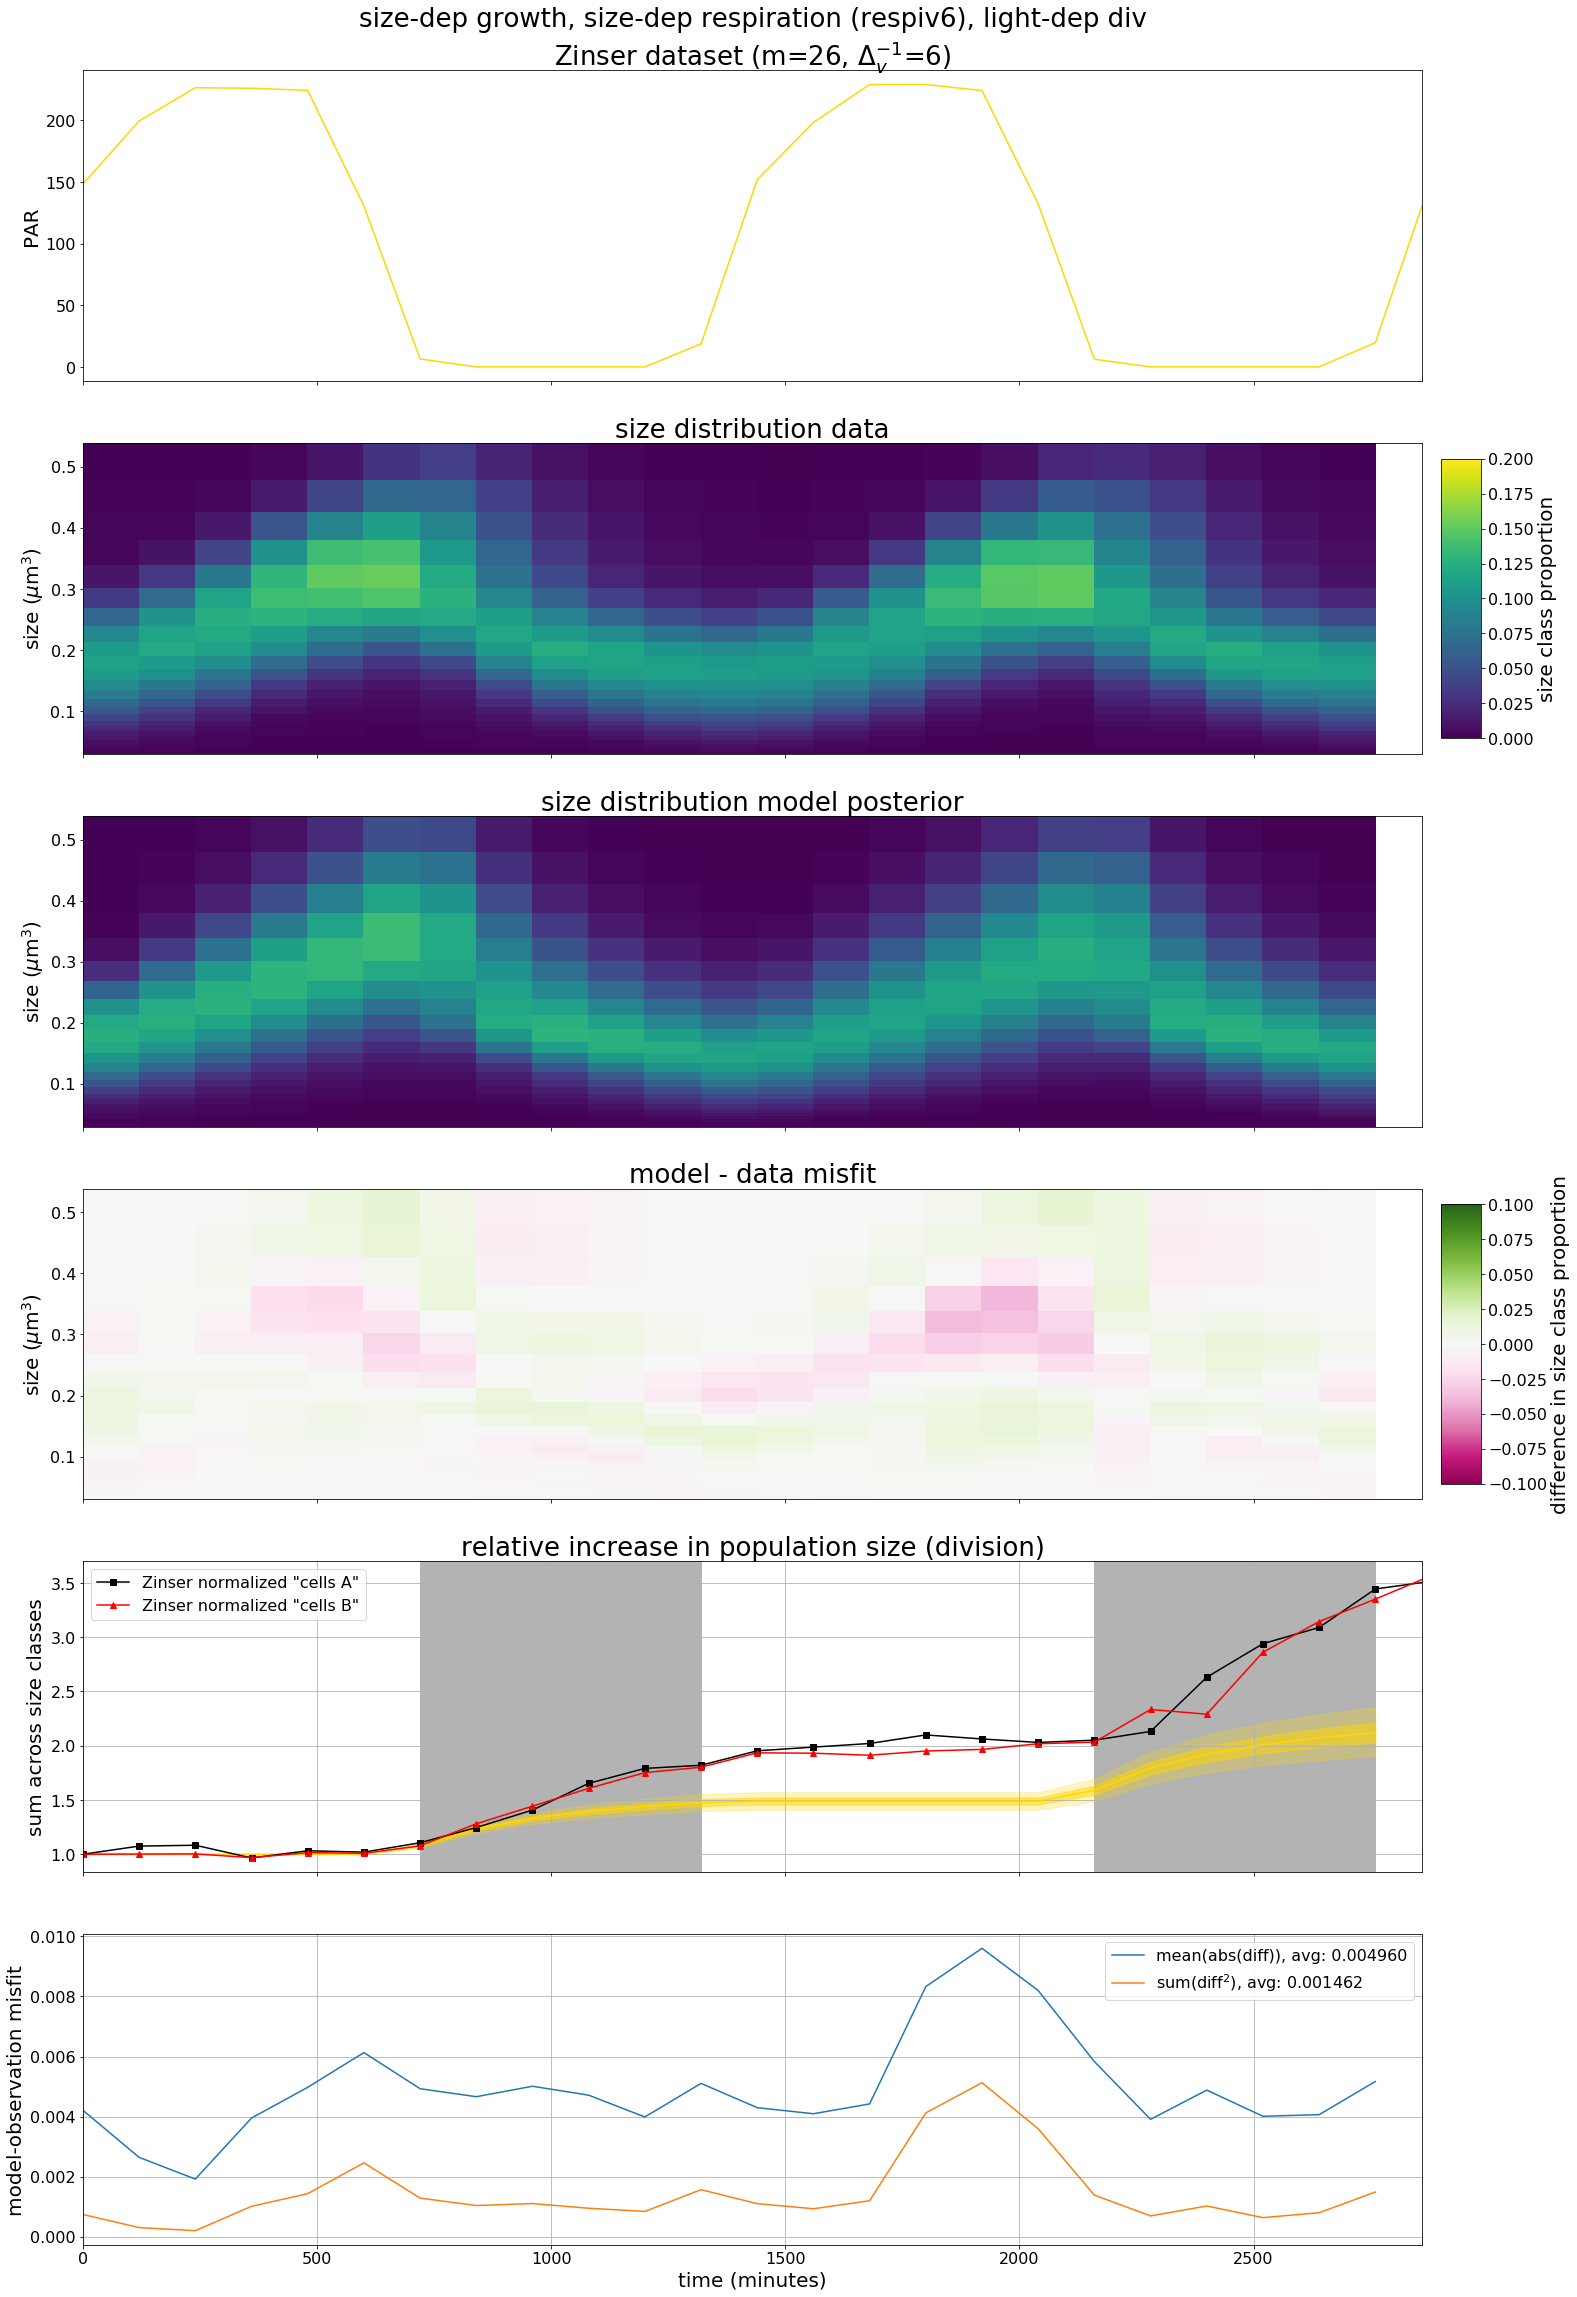

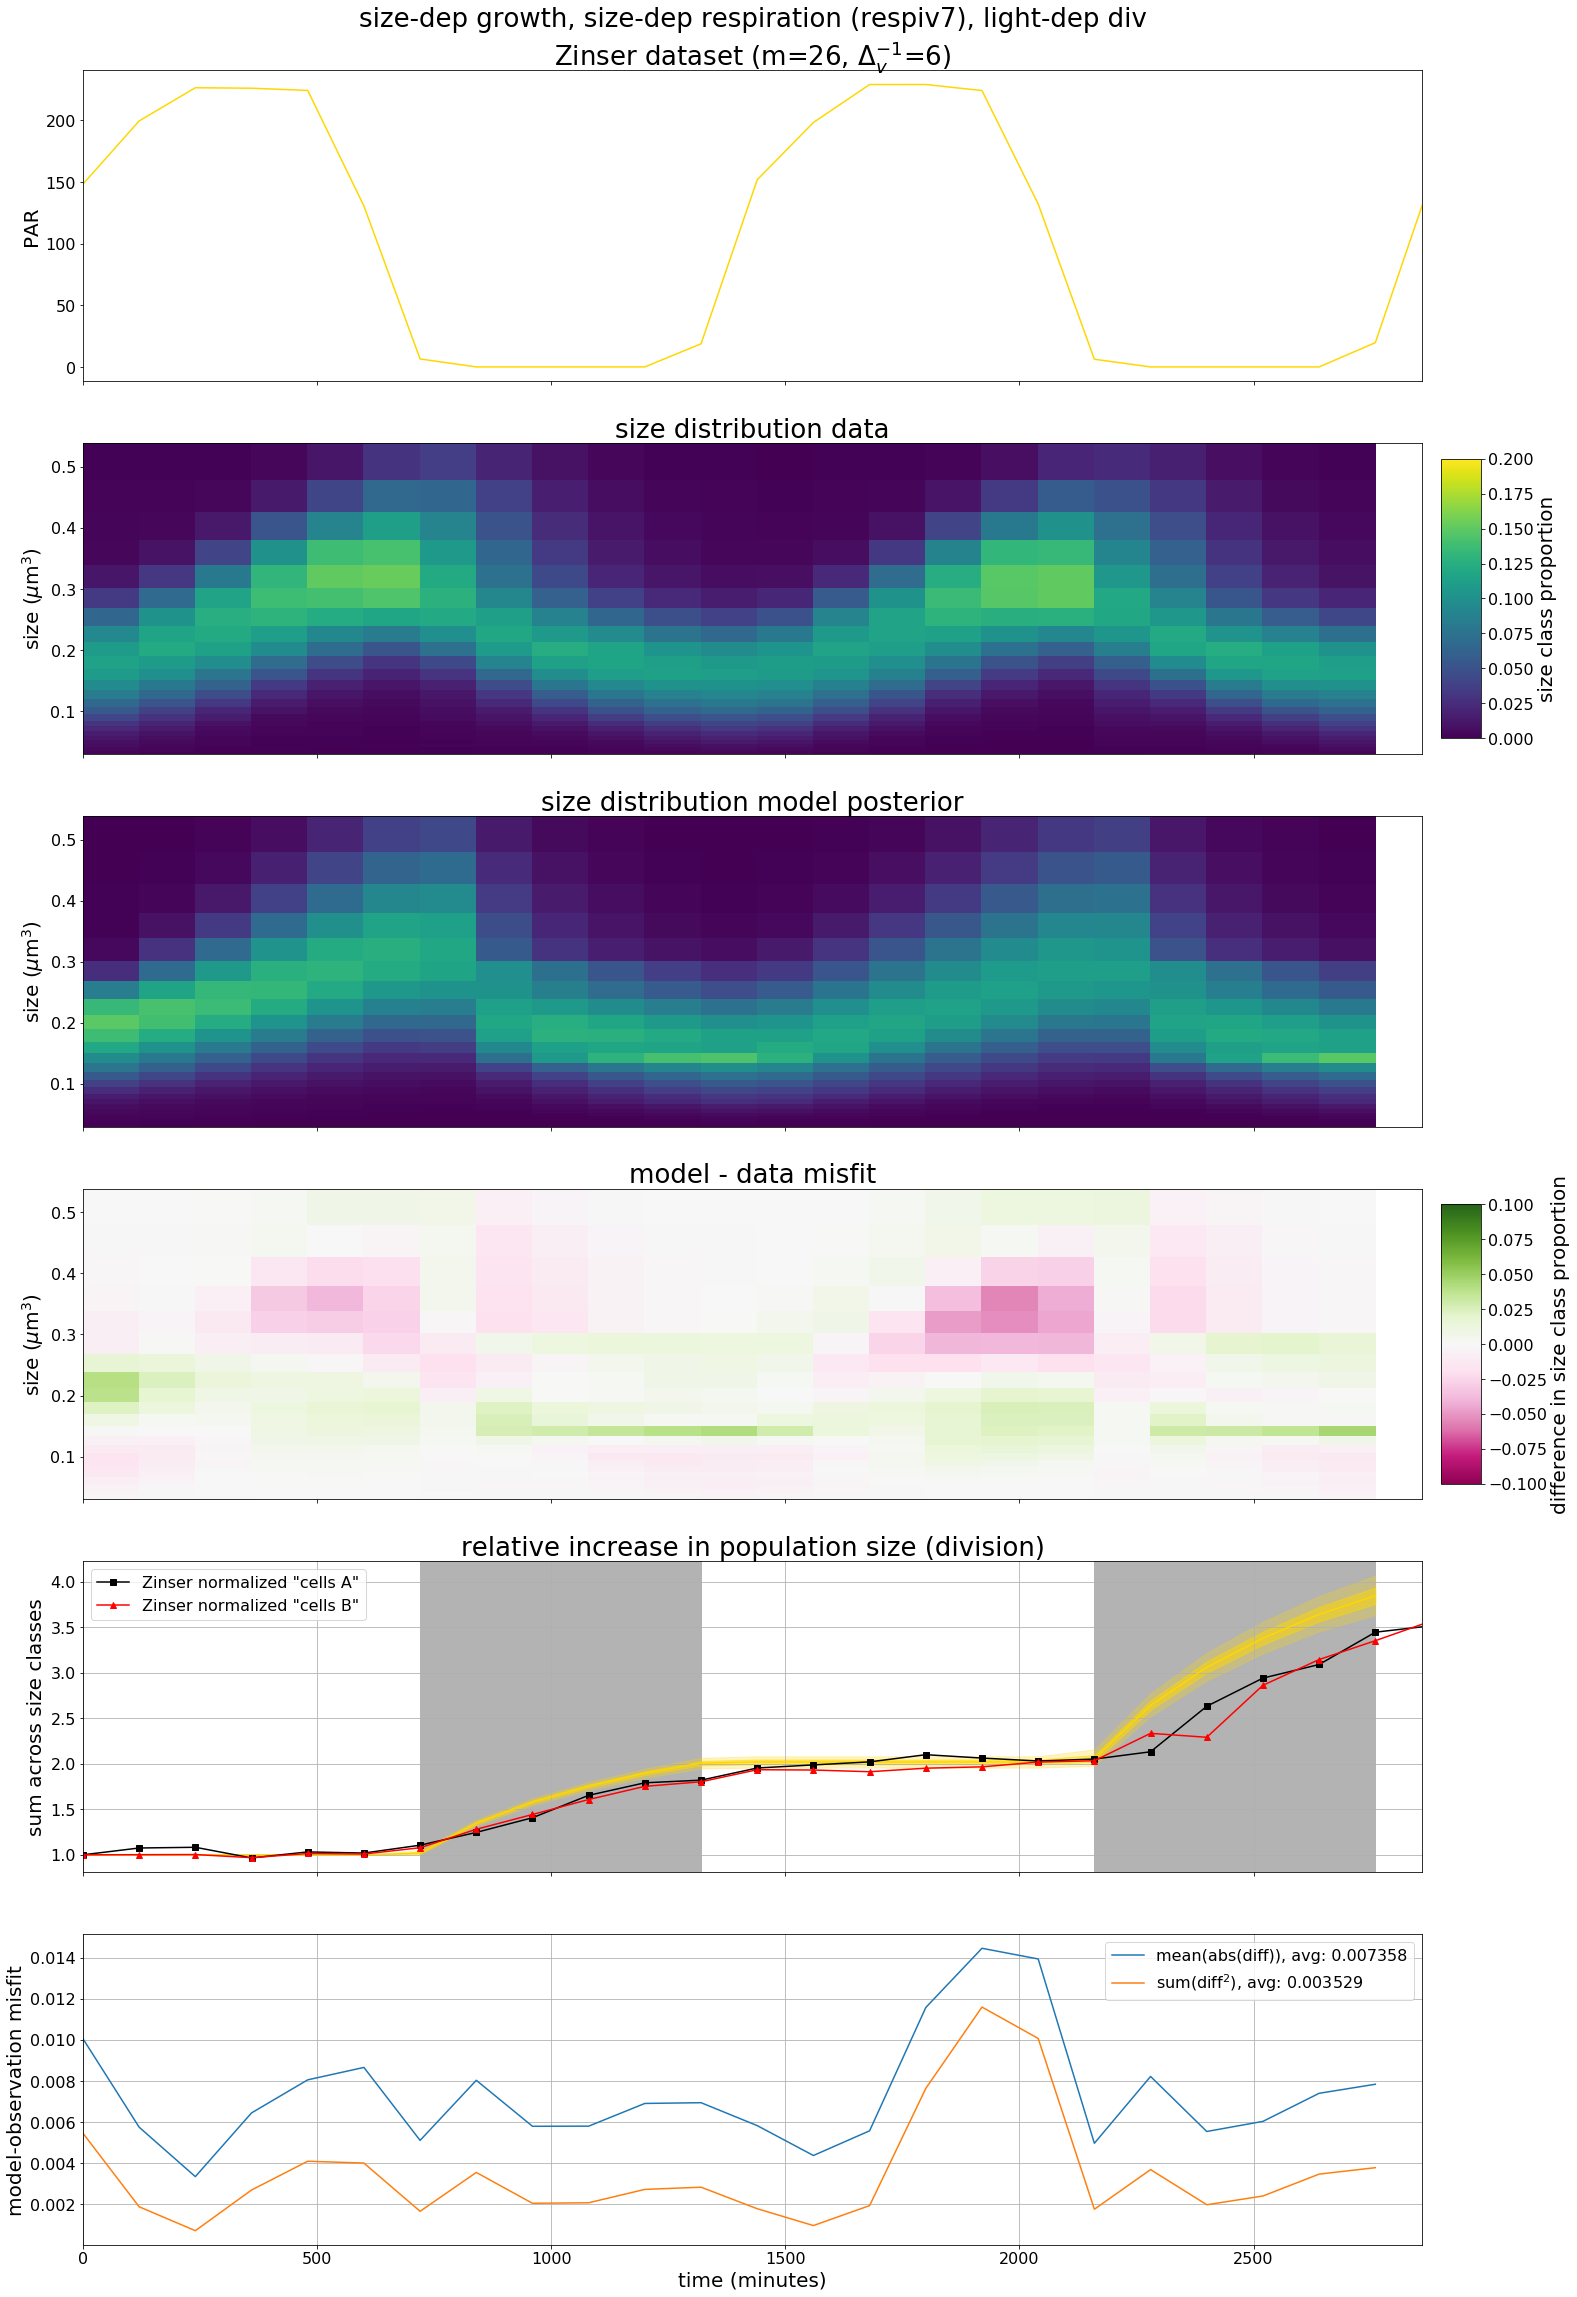

In [28]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    for name,mcmc in mcmcs.items():
        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
        v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

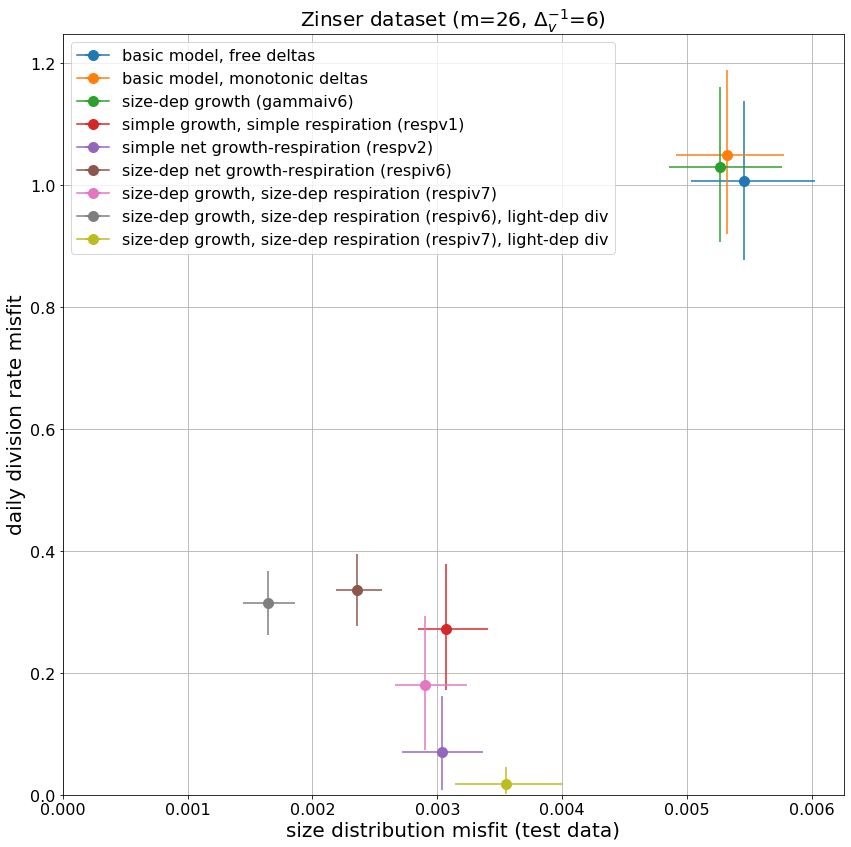

In [29]:
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))
        ax.set_title(desc[dataname], size=20)
        
        for name in mcmcs:
            # misfit to data

            obs = data[dataname]['obs']

            tmp = mcmcs[name][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
                xlabel_suffix = ''
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                xlabel_suffix = ' (test data)'
            
            # misfit to division rate

            e1 = np.abs(mcmcs[name][dataname]['divrate'] - reference_values[dataname]['divrate'])
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))
            
            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[name], color=colors_model[name])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
            if maxrhats_final[name][dataname] > 1.1:
                ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
        ax.grid(True)
        ax.legend()
        ax.set(xlabel='size distribution misfit'+xlabel_suffix, ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

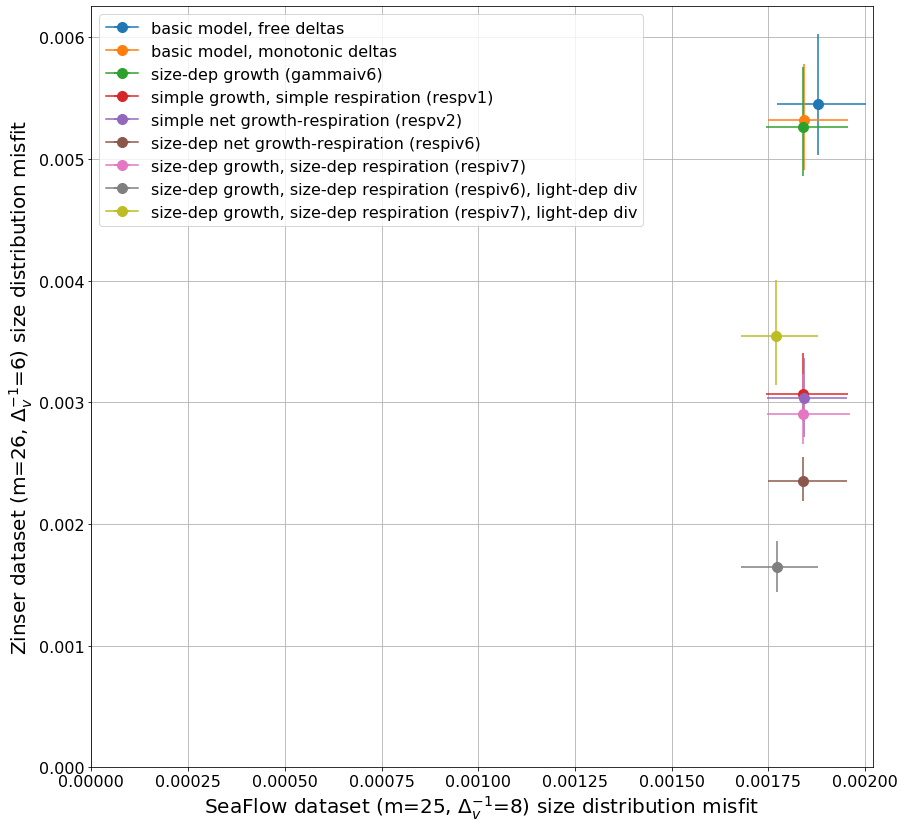

In [30]:
fig, ax = plt.subplots(figsize=(14,14))

datanames = tuple(data.keys())
for name in mcmcs:
    qq = {}
    # misfit to data
    for dataname in datanames:
        obs = data[dataname]['obs']

        tmp = mcmcs[name][dataname]['mod_obspos']
        tmp/= np.sum(tmp, axis=1)[:,None,:]
        tmp -= obs[None,:,:]
        tmp **= 2

        if np.all(data[dataname]['i_test'] == 0):
            e0 = np.mean(np.sum(tmp, axis=1), axis=1)
        else:
            e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)

        qq[dataname] = np.percentile(e0, q=(5,25,50,75,95))
    
    q0 = qq[datanames[0]]
    q1 = qq[datanames[1]]
    
    eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[name], color=colors_model[name])
    ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
    if maxrhats_final[name][dataname] > 1.1:
        ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
    
ax.grid(True)
ax.legend()
ax.set(xlabel='{} size distribution misfit'.format(desc[datanames[0]]), 
       ylabel='{} size distribution misfit'.format(desc[datanames[1]]))
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0)
None

In [31]:
'''
import netCDF4 as nc4

for dataname in data:

    ncname = 'data_exp_zs_20200624_gallery2_test_{}.nc'.format(dataname)

    with nc4.Dataset(ncname, 'w') as nc:
        for i,name in enumerate(mcmcs):
            if i == 0:
                nc.createDimension('model', len(mcmcs))
                nc.createDimension('sample', mcmcs[name][dataname]['divrate'].shape[0])
            
                nc.createVariable('divrate', float, ('model','sample'))
                nc.createVariable('sumsqdiff', float, ('model','sample'))
                nc.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')
                
            nc.variables['divrate'][i,:] = mcmcs[name][dataname]['divrate']
            
            obs = data[dataname]['obs']

            tmp = mcmcs[name][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
            
            for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                if i == 0:
                    nc.createVariable(v, float, ('model','sample'))
                if v in mcmcs[name][dataname].flatnames:
                    nc.variables[v][i,:] = mcmcs[name][dataname][v]
# '''
None